<a href="https://colab.research.google.com/github/pnjha/NLP-Assignments/blob/master/nlp_q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 47kB/s 
     |████████████████████████████████| 419kB 54.6MB/s 
     |████████████████████████████████| 3.0MB 52.2MB/s 


In [2]:
import unicodedata
import pandas as pd
import numpy as np
import tensorflow as tf

import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import copy
import math

import keras as keras
from keras.optimizers import SGD
from keras.initializers import RandomUniform
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM, Input, Embedding, TimeDistributed, Flatten, Dropout, Activation, dot, concatenate, Bidirectional
from keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [3]:
tf.__version__

'2.0.0-alpha0'

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [5]:
X = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.en', names=['src'])
Y_in = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.hi', names=['dest_in'])
Y_out = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/train.hi', names=['dest_out'])
lines = pd.concat([X[:1000],Y_in[:1000],Y_out[:1000]], axis=1)
print(len(lines))
# lines = shuffle(lines)
lines.sample(10)

1000


src  ...                                           dest_out
143  List of training test centres where cancer can...  ...  प्रशिक्षण जाँच केन्द्र की सूची जहाँ कैंसर का प...
584  Typhoid fever is such a disease that starts as...  ...  टाइफाईड ज्वर एक ऐसी बीमारी है , जो गैस्ट्रोइंट...
708  This disease is found more in women of dark co...  ...  गहरेरंग वाली महिलाओं में गोरे रंग वाली महिलाओं...
453  The details of the capital received from the G...  ...  राष्ट्रीय मातृत्व लाभ योजना के अन्तर्गत वर्ष 2...
782  This disease is a common thing in people of 50...  ...  50 वर्ष और इस से अधिक आयु के लोगों में यह रोग ...
913  If there is tendency for dysentery then by hav...  ...  भात को दही के साथ मिलाकर खाने से यदि दस्त लगे ...
857  In women the number of healthy women is less i...  ...  महिलाओं में स्वस्थ महिलाओं की संख्या पुरूषों क...
304  On the subject of population and development i...  ...  वर्ष 1994 में केरो ( मिश्र ) में एक अन्तराष्ट्...
276  Symptoms are dependent on the frequency of eme...  ...  लक्षणों के उभरने की बारंबारता तीव्रता व्यक्ति ...
938  If your eyes redden rapidly then keep eye clea...  ...  यदि आपकी आँखें जल्दी लाल हो जाती हैं तो आँखों ...

[10 rows x 3 columns]

In [0]:
def process_data(data,append_char):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: x.strip())
    data = data.apply(lambda x: re.sub("'", '', x))
    exclude = set(string.punctuation) # Set of all special characters
    data = data.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
    remove_digits = str.maketrans('', '', digits)
    data = data.apply(lambda x: x.translate(remove_digits))
    if append_char == 1:
        data = data.apply(lambda x : '<sos> '+ x)
    elif append_char == 2:
        data = data.apply(lambda x : x + ' <eos>')
    return data

In [7]:
lines.src = process_data(lines.src,0)
lines.dest_in = process_data(lines.dest_in,1)
lines.dest_out = process_data(lines.dest_out,2)
lines.src.sample(10),lines.dest_in.sample(10),lines.dest_out.sample(10)

(122    change of tissues of mouth can be easily seen ...
 473    this contagious virus spreads generally throug...
 471    a comparative detail of the achievements under...
 831    cancer of skin generally spreads through lymph...
 341    on the directions of the government of india s...
 767    if having vision syndrome then the person must...
 71                          difficult tumors are cancer 
 835    at times lymph glands are also cut and removed...
 180    all the hospitals  superintendant base hospita...
 702    this fact has come forward from regular sonogr...
 Name: src, dtype: object,
 686    <sos> जब यकृत विद्रधि फटती है  तो उपद्रव स्वरू...
 765    <sos> छोटे बच्चों में अगर आँखों में तिरछेपन की...
 67     <sos> कोशिका एक गिल्टी या घाव का रूप ले लेती ह...
 782    <sos>  वर्ष और इस से अधिक आयु के लोगों में यह ...
 420    <sos> इसे पीतज्वर इसलिये कहते है क्योंकि इसके ...
 881    <sos> इस सब के लिए जो सबसे आवश्यक है वह है महि...
 186    <sos> हवा में निहित बूंदों द्वारा आमत

In [0]:
def reverse_train_sentences(data):
  l = data.tolist()
  t = []
  for item in l:
    p = item.strip().split()
    p.reverse()
    k = []
    for i in p:
      i = i.strip()
      if len(i) > 0:
        k.append(i)
    p = k
    p = " ".join(p)
    p = p.strip()
    t.append(p)
  df = pd.DataFrame({'data':t})
  return df.data  

In [0]:
X, y_in, y_out = lines.src.values, lines.dest_in.values, lines.dest_out.values 
X_train, X_test, y_in_train, y_in_test, y_out_train, y_out_test = train_test_split(X, y_in, y_out, test_size = 0.2,shuffle=False)
X_train_normal = copy.deepcopy(X_train)
X_train = reverse_train_sentences(X_train)

In [12]:
src_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
src_tokenizer.fit_on_texts(X_train)

data_src = src_tokenizer.texts_to_sequences(X_train)
data_src = tf.keras.preprocessing.sequence.pad_sequences(data_src,padding='post')

print(src_tokenizer.word_index)
print(data_src)
print(len(data_src[0]))

{'the': 1, 'of': 2, 'in': 3, 'and': 4, 'is': 5, 'to': 6, 'a': 7, 'or': 8, 'be': 9, 'can': 10, 'disease': 11, 'with': 12, 'this': 13, 'are': 14, 'for': 15, 'cancer': 16, 'it': 17, 'on': 18, 'that': 19, 'not': 20, 'from': 21, 'at': 22, 'by': 23, 'also': 24, 'if': 25, 'women': 26, 'which': 27, 'has': 28, 'due': 29, 'through': 30, 'treatment': 31, 'patient': 32, 'more': 33, 'symptoms': 34, 'as': 35, 'health': 36, 'rrb': 37, 'lrb': 38, 'should': 39, 'any': 40, 'fever': 41, 'then': 42, 'body': 43, 'there': 44, 'out': 45, 'percent': 46, 'after': 47, 'been': 48, 'pain': 49, 'eyes': 50, 'most': 51, 'test': 52, 'an': 53, 'children': 54, 'tuberculosis': 55, 'blood': 56, 'patients': 57, 'done': 58, 'one': 59, 'have': 60, 'state': 61, 'diseases': 62, 'other': 63, 'than': 64, 'during': 65, 'may': 66, 'about': 67, 'age': 68, 'found': 69, 'rate': 70, 'years': 71, 'time': 72, 'its': 73, 'occurs': 74, 'very': 75, 'virus': 76, 'but': 77, 'get': 78, 'such': 79, 'some': 80, 'being': 81, 'under': 82, 'sprea

In [13]:
dest_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')

dest_tokenizer.fit_on_texts(y_in_train)
dest_tokenizer.fit_on_texts(y_out_train)

data_dest_in = dest_tokenizer.texts_to_sequences(y_in_train)
data_dest_in = tf.keras.preprocessing.sequence.pad_sequences(data_dest_in,padding='post')

data_dest_out = dest_tokenizer.texts_to_sequences(y_out_train)
data_dest_out = tf.keras.preprocessing.sequence.pad_sequences(data_dest_out,padding='post')

print(data_dest_in.shape)
print(data_dest_out.shape)

(800, 58)
(800, 58)


In [0]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size):
        super(Encoder, self).__init__()
        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm_1 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.lstm_2 = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)

    def call(self, sequence, states):
        embed = self.embedding(sequence)
        output, state_h, state_c = self.lstm_1(embed, initial_state=states)
        output, state_h, state_c = self.lstm_2(output, initial_state=[state_h,state_c])
        return output, state_h, state_c

    def init_states(self, batch_size):
        return (tf.zeros([batch_size, self.lstm_size]),
                tf.zeros([batch_size, self.lstm_size]))

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size):
        super(Decoder, self).__init__()
        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm = tf.keras.layers.LSTM(lstm_size, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, sequence, state):
        embed = self.embedding(sequence)
        lstm_out, state_h, state_c = self.lstm(embed, state)
        logits = self.dense(lstm_out)

        return logits, state_h, state_c

In [0]:
BATCH_SIZE = 5
EMBEDDING_SIZE = 256
LSTM_SIZE = 256

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((data_src, data_dest_in, data_dest_out))
dataset = dataset.shuffle(20).batch(BATCH_SIZE)
print(dataset)

<BatchDataset shapes: ((None, 57), (None, 58), (None, 58)), types: (tf.int32, tf.int32, tf.int32)>


In [0]:
def get_model():
  src_vocab_size = len(src_tokenizer.word_index) + 1
  dest_vocab_size = len(dest_tokenizer.word_index) + 1

  encoder = Encoder(src_vocab_size, EMBEDDING_SIZE, LSTM_SIZE)
  decoder = Decoder(dest_vocab_size, EMBEDDING_SIZE, LSTM_SIZE)
  return encoder, decoder

In [0]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    loss = crossentropy(targets, logits)
    return loss

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
# optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01,initial_accumulator_value=0.2)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.03)

In [0]:
def train_step(model,source_seq, target_seq_in, target_seq_out, en_initial_states):
    loss = 0
    encoder = model["encoder"]
    decoder = model["decoder"]
    with tf.GradientTape() as tape:
        en_outputs = encoder(source_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_states = en_states

        de_outputs = decoder(target_seq_in, de_states)
        logits = de_outputs[0]
        loss = loss_func(target_seq_out, logits)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [0]:
def predict(model,test_source_text):
    
    encoder = model["encoder"]
    decoder = model["decoder"]
    src_tokenizer = model["src_tokenizer"]
    dest_tokenizer = model["dest_tokenizer"]
    
    test_source_seq = src_tokenizer.texts_to_sequences([test_source_text])

    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(test_source_seq), en_initial_states)

    de_input = tf.constant([[dest_tokenizer.word_index['<sos>']]])
    de_state_h, de_state_c = en_outputs[1:]
    out_words = []

    while True:
        de_output, de_state_h, de_state_c = decoder(de_input, (de_state_h, de_state_c))
        de_input = tf.argmax(de_output, -1)
        try:
          out_words.append(dest_tokenizer.index_word[de_input.numpy()[0][0]])
        except:
          out_words.append('<unk>')
        if out_words[-1] == '<eos>' or len(out_words) >= 50:
            break

    output = ' '.join(out_words)
    return output 

In [0]:
def train_model(NUM_EPOCHS):
  encoder, decoder = get_model()
  model = {"encoder":encoder,"decoder":decoder}
  loss_list = []
  ep_list = []

  for e in range(NUM_EPOCHS):
      en_initial_states = encoder.init_states(BATCH_SIZE)
      for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
          loss = train_step(model, source_seq, target_seq_in,target_seq_out, en_initial_states)
      
      ep_list.append(e+1)
      loss_list.append(loss.numpy())
      print('Epoch {} Loss {:.8f}'.format(e + 1, loss.numpy()))
  return encoder, decoder, loss_list, ep_list

In [0]:
def calculate_bleu_score(actual_string, predicted_string):
    actual_string = copy.deepcopy(actual_string)
    predicted_string = copy.deepcopy(predicted_string)
    reference = re.split("\s",actual_string.strip())
    candidate = re.split("\s",predicted_string.strip())
    try:
      reference.remove('<eos>')
      candidate.remove('<sos>')
    except:
      pass
    smoothie = SmoothingFunction().method4
    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    return score

In [0]:
def get_prediction(X,y,model):
  for index,line in enumerate(X):
    output = predict(model,line)
    print("source: ",line)
    print("actual: ",y[index])
    print("predicted: ",output)
    print("BLEU Score: ",calculate_bleu_score(output,y[index]))

In [0]:
def plot_graph(xlist,ylist,xname,yname):
  x = np.array(xlist)
  y = np.array(ylist)
  d = {xname: x, yname: y}
  data = pd.DataFrame(d)
  sns.lineplot(x=xname, y=yname,data = data)
  plt.show()

In [0]:
NUM_EPOCHS = 200
encoder, decoder, loss_list,epoch_list = train_model(NUM_EPOCHS)
model = {"encoder":encoder, "decoder":decoder, "src_tokenizer":src_tokenizer, "dest_tokenizer":dest_tokenizer}
plot_graph(epoch_list,loss_list,"Epochs","Loss")

Epoch 1 Loss 1.86803269
Epoch 2 Loss 1.59864712
Epoch 3 Loss 1.43277144
Epoch 4 Loss 1.23545516
Epoch 5 Loss 1.11026967
Epoch 6 Loss 0.99116707
Epoch 7 Loss 0.97103620
Epoch 8 Loss 0.87125623
Epoch 9 Loss 0.75599521
Epoch 10 Loss 0.65103757
Epoch 11 Loss 0.53787422
Epoch 12 Loss 0.39115199
Epoch 13 Loss 0.35080191
Epoch 14 Loss 0.32426998
Epoch 15 Loss 0.24544302
Epoch 16 Loss 0.21613958


In [0]:
nameoffile = "q1"
with open(nameoffile, "wb") as dill_file:
    dill.dump(model, dill_file)

model = {}
with open(nameoffile, "rb") as dill_file:
  model = dill.load(dill_file)

In [0]:
get_prediction(X_test,y_in_test)
get_prediction(X_train,y_in_train)

NameError: ignored

In [0]:
_X = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/dev.en', names=['src'])
_Y = pd.read_table('./NLA S20 - Assignment 2 Data/enghin/dev.hi', names=['dest'])
_lines = pd.concat([_X,_Y], axis=1)
print(len(_lines))
_lines.sample(10)

401


src                                               dest
139  Laparoscopic method takes double time in compa...  लैपरोस्कोपिक विधि में सामान्य चिकित्सा के मुका...
0        but you will also be safe from eye diseases .             बल्कि आप नेत्ररोगों से भी बचे रहेंगे ।
366  Situated behind popular Himalaya Mall and equi...  लोकप्रिय हिमालय मॉल के पीछे स्थित और वाजिब कीम...
36   Therefore medicines should be taken in the beg...  इसलिए शुरू में औषधियों का सेवन किया जाए और साथ...
400  While roaming in huge airplanes if suddenly on...  बड़े-बड़े हवाईजहाजों में घूमते हुए अचानक आपके सा...
65     Brain exercise works on this very fundamental .          ब्रेन एक्सरसाइज इसी फंडे पर काम करती है ।
46   Staying in this position for a comfortable per...  इस स्थिति में आरामदायक अवधि तक रखकर वापस पूर्व...
209  Tou trains enhance the journey in the tour of ...  दार्जिलिंग की सैर में ट्‍वाय ट्रेनें सफर में च...
141  Key hole surgery ' is a revolutionary inventio...  शल्यचिकित्सा के क्षेत्र में ’ की होल सर्जरी ’ ...
47            Do the same exercise another side also .                     यही क्रिया दूसरी तरफ भी करें ।

In [0]:
_X, _y = _lines.src.values, _lines.dest.values 

source:  but you will also be safe from eye diseases .
actual:  बल्कि आप नेत्ररोगों से भी बचे रहेंगे ।
predicted:  घर स्वंय पश्‍चात करता है । <eos>
BLEU Score:  0.19817632389021378


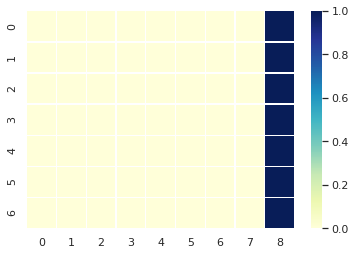

source:  The chairperson of the Department of Ophthalmology of Liverpool University Dr . Ian Greerson says .
actual:  लिवरपूल यूनिवर्सिटी के आप्थैमोलॉजी विभाग के अध्यक्ष व विख्यात नेत्ररोग शोधकर्ता डॉ. इयान ग्रीयरसन कहते हैं ।
predicted:  ईएजी कार्यक्रम के सामने साफ लग सकता है । <eos>
BLEU Score:  0.18557819854739144


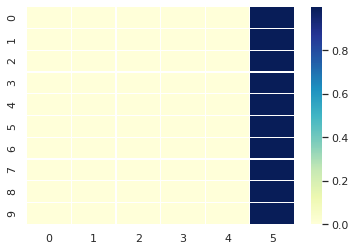

source:  Common blindness causing diseases like cataract and glaucoma can be prevented by increasing the amount of vitamin-C and omega-3 oils and some special plants in diet .
actual:  कि खाने में विटामिन-सी और ओमेगा-3 तेलों व कुछ विशेष पौधों की मात्रा बढ़ाने से आमतौर पर अंधेपन का कारण बनने वाले मोतियाबिंद व ग्लूकोमा जैसे रोगों से बचा जा सकता है ।
predicted:  घर तथा आसपास वातावरण को वातावरण में पानी को साफ लग सकता है । <eos>
BLEU Score:  0.22275423336274477


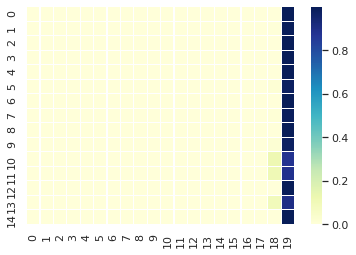

source:  So let us know how your diet should be to keep eyes healthy .
actual:  तो आइए जानते है कि नजर को स्वस्थ बनाए रखने के लिए कैसा हो आपका आहार ।
predicted:  घर स्वंय प्रकार के बचाव या पास लाता है । <eos>
BLEU Score:  0.18557819854739144


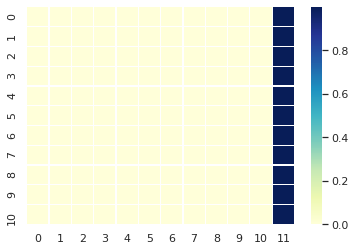

source:  You should include green vegetables in your diet to keep eyes sharp .
actual:  नजर तेज बनी रहे , इसके लिए आपको चाहिए की अपने आहार में आप हरी सब्जियाँ शामिल करें ।
predicted:  घर से नजदीक पर लग सकता । <eos>
BLEU Score:  0.18305025818318518


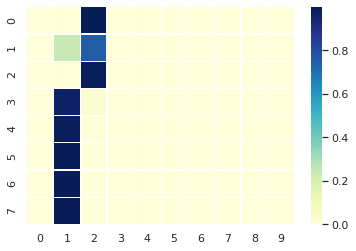

source:  Eating spinach , broccoli , germinated grains may be beneficial in this regard .
actual:  पालक , ब्रोकोली , अंकुरित अनाज खाना इस लिहाज से फायदेमंद साबित हो सकता है ।
predicted:  कैंसर के काटने के पश्‍चात मुख्यालय लगवाने को देखने के दर्द होने व नीचे दिया जा रहा है । <eos>
BLEU Score:  0.18690518620528904


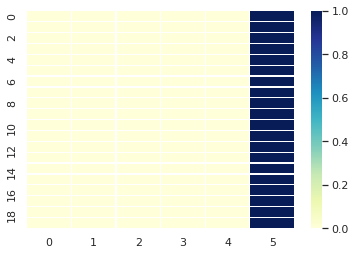

source:  There are two important elements like lutein , zeaxanthin which are responsible to keep vision sharp .
actual:  इसमें ल्यूटिन , जीजेनथिन जैसे दो अहम तत्व होते हैं , जो नजर को तेज बनाए रखने के लिए जिम्मेदार होते हैं ।
predicted:  घर बुखार या क्षति सर्वाधिक प्रभावी जो अकसर चकत्तों के रक्त सर्वाधिक बढ़ जाता है । <eos>
BLEU Score:  0.17847260705223245


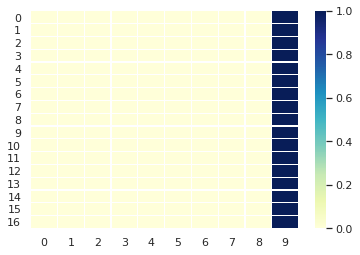

source:  This has been testified in the six-year study by the American National Eye Institute that this element saves old people from blindness .
actual:  अमेरिकी नेशनल आई इंस्टीट्यूट के 6 साल के अध्ययन में यह साबित हुआ है कि यह तत्व बुजुर्गों को अंधेपन से बचाते हैं ।
predicted:  पूरी आस्तीन से स्वंय परीक्षण के पास पपीता आम तरल । <eos>
BLEU Score:  0.17741926041310546


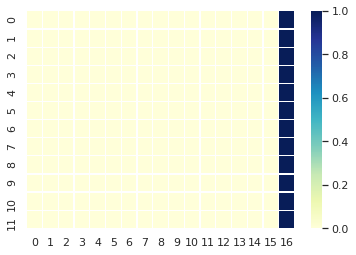

source:  Therefore everybody should eat hundred grams of green vegetables in the form of salad .
actual:  अमेरिकी नेशनल आई इंस्टीट्यूट के 6 साल के अध्ययन में यह साबित हुआ है कि यह तत्व बुजुर्गों को अंधेपन से बचाते हैं ।
predicted:  कैंसर के बाद हर्निया दुबारा न rpneg हो जाती है । <eos>
BLEU Score:  0.17741926041310546


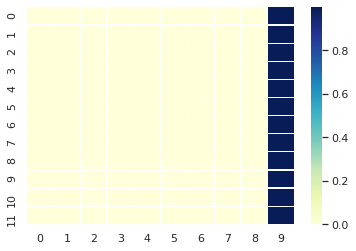

source:  You must eat two or three eggs daily in breakfast .
actual:  नाश्ते में रोज दो या तीन अंडे जरूर खाएँ ।
predicted:  आरसीएच किट भारत सरकार से अधिक आयु के रक्त है । <eos>
BLEU Score:  0.19552795980276136


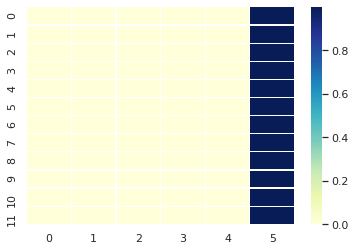

source:  Bilberry or blackberry anthocyanin saves from blindness or cataract .
actual:  बिलबैरी या ब्लैकबैरी एंथोसाइनिन अंधेपन या मोतियाबिंद से बचाती है ।
predicted:  तकलीफ अधिक स्थिति मीजल्स है । <eos>
BLEU Score:  0.1940679506664638


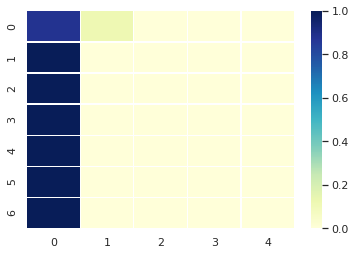

source:  It is also found in the research that it strengthens the cell which brings blood and nutritious elements into the eyes .
actual:  शोध में यह भी पाया गया है कि यह आँखों में खून और पोषक तत्व पहुँचाने वाली कोशिकाओं को मजबूत बनाती हैं ।
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0.17847260705223245


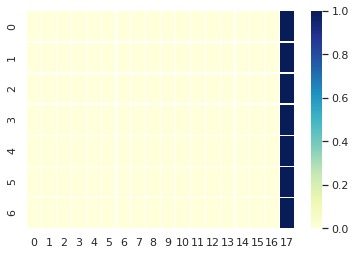

source:  That is why you can also eat bilberry or blackberry in breakfast or with fruit salad .
actual:  इसलिए नाश्ते या फ्रूट सलाद के साथ आप बिलबैरी या ब्लैकबैरी भी खा सकते हैं ।
predicted:  कैंसर में आसपास वातावरण में चिकित्सा विभाग के कारण लगभग से तरह से ठीक उन्हें वर्ष में अधिक कैंसर व बाद ताजे जाता है । <eos>
BLEU Score:  0.18690518620528904


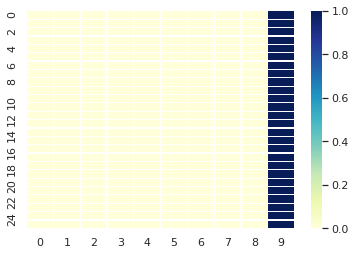

source:  There is no better solution but to eat fish for keeping eyes healthy if you are a non-vegetarian .
actual:  अगर आप मांसाहारी हैं तो आँखों को स्वस्थ बनाए रखने के लिए मछली का सेवन करने से अच्छा कोई उपाय नहीं ।
predicted:  घर स्वंय परिवार कल्याण कार्यक्रम के वायरल निम्न प्रकार के प्रभावित चाहिए । <eos>
BLEU Score:  0.17956076853248887


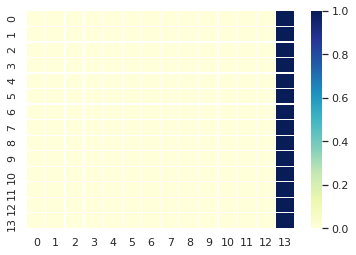

source:  By eating fish not only your skin , hair , brain remain healthy but eyes also sharpen .
actual:  मछली खाने से न केवल आपकी त्वचा , बाल , दिमाग स्वस्थ रहता बल्कि नजर भी तेज होती है ।
predicted:  कैंसर के बाद हमें पता लग जायेगा कि राज्य में लिए चिकित्सक से लग सकता है कि यहाँ ट्यूमर है या नहीं हो सकती है । <eos>
BLEU Score:  0.21625498394615908


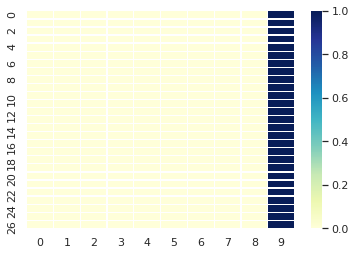

source:  Omega-3 fat found in fish decreases the danger of glaucoma and weak eyes in old age .
actual:  मछली में पाया जाने वाला ओमगा-3 फैट आँखों को ग्लूकोमा और बुढ़ापे में नजर कमजोर होने का खतरा कम करता है ।
predicted:  आरसीएच किट भारत तक भागीदारी को विषाणु एड्स पैदा किया गया । <eos>
BLEU Score:  0.17956076853248887


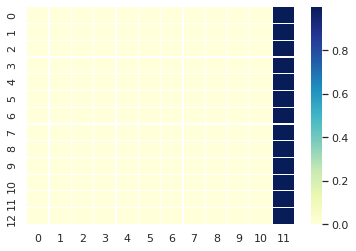

source:  Not only this , it saves you from dry eye syndrome .
actual:  यही नहीं , यह आपको ड्राय आई सिंड्रोम से बचाता है ।
predicted:  आरसीएच किट भारत सरकार में जन्मे को के रक्त सर्वाधिक देने पर सर्वाधिक है । <eos>
BLEU Score:  0.19259074009082888


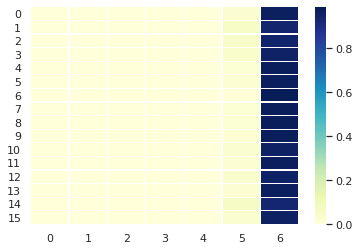

source:  It is stated in another study that women suffering from ophthalmic problems such as dry eye syndrome can decrease this problem up to 68 percent by eating tuna fish .
actual:  एक अन्य अध्ययन में बताया गया है कि ड्राय आई सिंड्रोम जैसे नेत्र समस्या से परेशान महिलाएँ हफ्ते में पाँच बार ट्यूना मछली खाकर , इस तकलीफ को 68 फीसदी कम कर सकती हैं ।
predicted:  इसके अलावा लक्षण रोगियों को पश्‍चात करता है । <eos>
BLEU Score:  0.1677077171881632


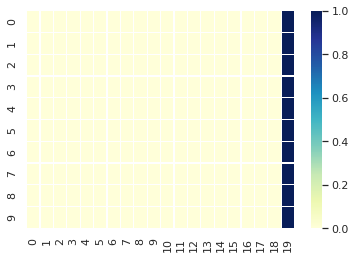

source:  The use of dry fruits etcetera in Indian cuisines has been continuing for centuries .
actual:  भारतीय व्यंजनों में मेवे आदि का इस्तेमाल सदियों से होता आ रहा है ।
predicted:  डायबिटीज से निम्न समस्याएँ एवं ग्रामीण से जटिलताओं का खतरा होने से लगाने के रक्त नहीं है । <eos>
BLEU Score:  0.18968126713037053


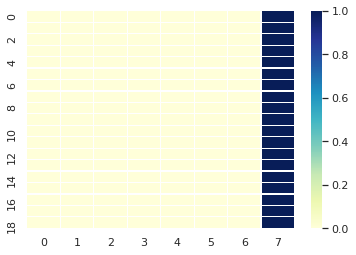

source:  But do you know that all the dry fruits such as almond , cashew nut , walnut , raisins etcetera are also very beneficial for eyes besides being nutritious .
actual:  लेकिन क्या आप जानते हैं कि बादाम , काजू , अखरोट , किशमिश आदि यह सारे मेवे पौष्टिक होने के अलावा आँखों के लिए भी बहुत फायदेमंद होते हैं ।
predicted:  कैंसर के बाद चमड़ी के सम्बन्ध में उपरोक्त तेज पूरी आस्तीन का कपड़ा आये निकाल तो रोग नहीं कमजोरी थकान बुखार पहनायें । <eos>
BLEU Score:  0.1717430532243771


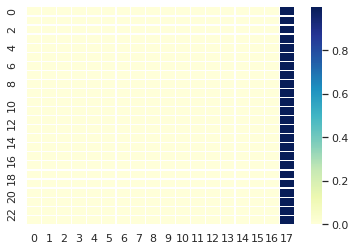

source:  Plenty of vitamin-B is found in these , which not only saves from cataract , many kind of blindness and other eye diseases but also protect eyes from the harms of ultraviolet rays .
actual:  इनमें विटामिन ई प्रचुर मात्रा में पाया जाता है , जो न केवल मोतियाबिंद , कई प्रकार के अंधेपन और अन्य नेत्र रोगों से बचाने के अलावा पराबैंगनी किरणों से पहुँच रहे नुकसान से भी आँखों की रक्षा करता है ।
predicted:  पूरी आस्तीन समय व पश्‍चात क्षेत्र में परिवर्तन के जिला लाख व मदद सकती है । <eos>
BLEU Score:  0.1944387569440379


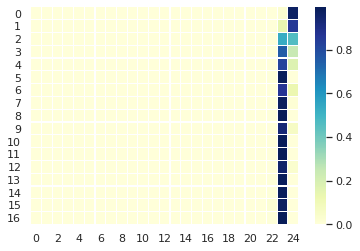

source:  Start eating pieces of dry fruits in sweets daily at the time of breakfast or meals .
actual:  रोज नाश्ते या खाने के समय मीठे में मेवे की कतरन बुरक के खाना शुरू कर दें ।
predicted:  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम चलाया जा रहा है । <eos>
BLEU Score:  0.18429333166740366


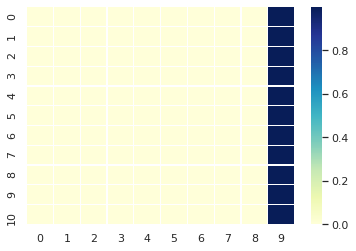

source:  Whether it is about dropping weight or care of skin , the advice of fresh fruits in meals is given in all the cases .
actual:  बात वजन घटाने की हो या त्वचा की देखभाल की , खाने में ताजे फल खाने की सलाह सभी मामलों में दी जाती है ।
predicted:  पूरी आस्तीन से स्वंय परीक्षण या उसके अजन्में या नवजात शिशु लगता है । <eos>
BLEU Score:  0.17639910709395284


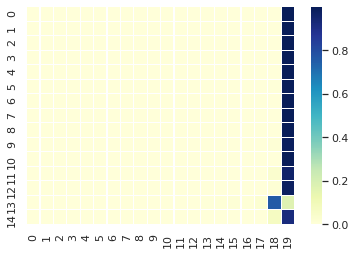

source:  So , why should it be left for eyes .
actual:  तो भला , आँखों के लिए क्यों इन्हें छोड़ा जाए ।
predicted:  घर स्वंय पश्‍चात करता है । <eos>
BLEU Score:  0.1940679506664638


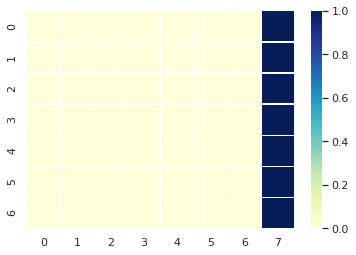

source:  The danger of glaucoma , cataract , and blindness can be decreased to a great extent by taking diet rich in vitamin-C .
actual:  विटामिन-सी से भरपूर आहार लेने से ग्लूकोमा , मोतियाबिंद और अंधेपन का खतरा काफी हद तक कम किया जा सकता है ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन या मल के काटता है । <eos>
BLEU Score:  0.17956076853248887


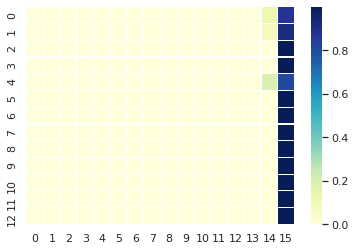

source:  Including fruit , vegetable in meal is enough to maintain the eyes healthy .
actual:  आँखों को स्वस्थ बनाए रखने के लिए आहार में फल सब्जियाँ शामिल करना काफी है ।
predicted:  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम चलाया जा रहा है । <eos>
BLEU Score:  0.18690518620528904


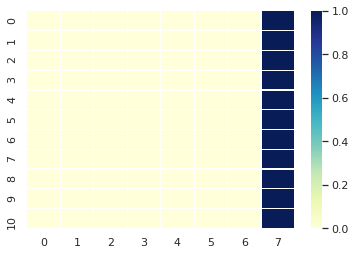

source:  Including these things in your diet you can save your eyes from getting weakened .
actual:  इन्ही चीजों को अपने आहार में शामिल कर आप आँखों को कमजोर होने से बचा सकते हैं ।
predicted:  घर में कूलर टीन जटिलताओं का खतरा होने को रूप से प्रभावित करता है । <eos>
BLEU Score:  0.18429333166740366


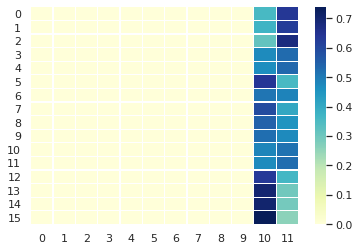

source:  Besides this drinking milk , eating carrot is also proved to be beneficial .
actual:  इसके अलावा दूध पीना , गाजर खाना भी फायदेमंद साबित होता है ।
predicted:  घर बुखार समय या व्यक्ति को आये लग जायेगा <eos>
BLEU Score:  0


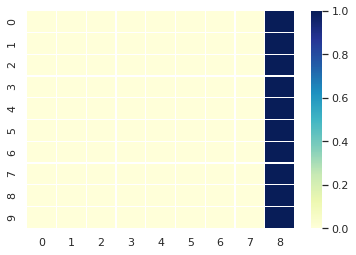

source:  Taking diet rich in vitamin-A can also be helpful in keeping eyes healthy .
actual:  विटामिन-ए से भरपूर आहार लेना भी आँखों को स्वस्थ बनाए रखने में मददगार साबित हो सकता है ।
predicted:  घर स्वंय पश्‍चात केयर में रखा जाता है जिससे उनकी शारीरिक मानसिक नही और किया गया तो स्तन होना । <eos>
BLEU Score:  0.18429333166740366


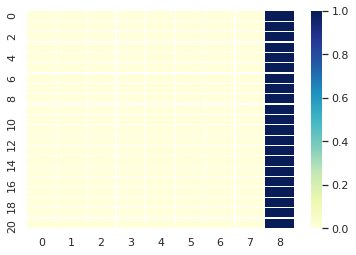

source:  A little care taken in diet may also put new life in your eyes .
actual:  खान-पान में बरती गई थोड़ी सी सावधानी भी आपकी आँखों में नई जान डाल सकती है ।
predicted:  घर स्वंय पश्‍चात केयर में रखा जाता है और यह रोग है । <eos>
BLEU Score:  0.18557819854739144


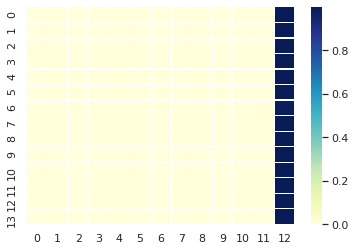

source:  Paralysis may be controlled by yoga .
actual:  योग से काबू हो सकता है लकवा ।
predicted:  घर अथवा मच्छररोधी अगरबत्ती का सर्वाधिक पक्षाघात और रक्त है । <eos>
BLEU Score:  0.19817632389021378


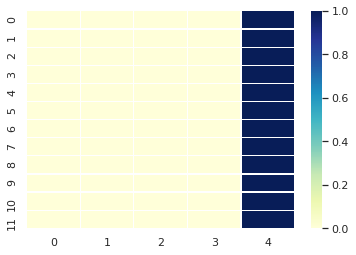

source:  Paralysis - when generally the functionalism , and dynamism of muscles and pulse of the right or left side of the body go less or end this problem is said to be paralysis .
actual:  पक्षाघात - आमतौर पर शरीर के दाएँ या बाएँ भाग की मांसपेशियों व नसों की क्रियाशीलता एवं गतिशीलता कम या समाप्त हो जाती है तो इस समस्या को लकवा या पक्षाघात कहते हैं ।
predicted:  कैंसर के लाईलाज रोगियों को पश्‍चात केयर में रखा जाता है जिससे उनकी उन्हें महिला से साफ गर्भनिरोधक की विधियों का उपयोग चाहिए । <eos>
BLEU Score:  0.20034805972722955


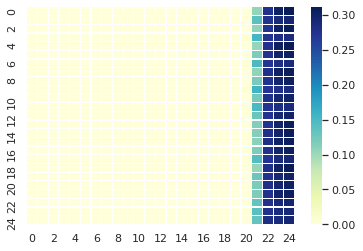

source:  Paralysis is limited to half of the body , whole of the body or only till face .
actual:  पक्षाघात आधे शरीर , संपूर्ण शरीर या केवल चेहरे तक होता है ।
predicted:  पूरी आस्तीन से पश्‍चात होता है । <eos>
BLEU Score:  0.19112328397109352


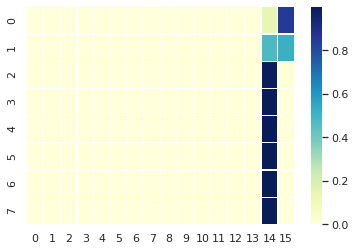

source:  The main reason of this problem is increasing high blood pressure , blood clotting in brain , the situation of extreme happiness or sorrow etc .
actual:  इस समस्या का प्रमुख कारण उच्च रक्तचाप का अधिक बढ़ना , मस्तिष्क में रक्त का थक्का बनना अत्यंत हर्ष या विषाद की स्थिति आदि है ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन एवं ग्रामीण क्षेत्रों में कुष्ठ परिवार का माह व यह प्रभावित हो सकता है । <eos>
BLEU Score:  0.17541056564995905


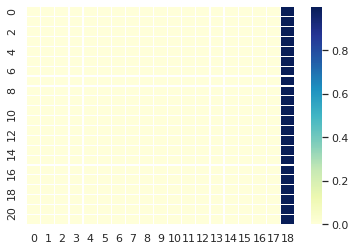

source:  By yogic exercise this disease can be overcome surely .
actual:  यौगिक अभ्यास से इस रोग पर निश्‍चित ही विजय प्राप्त की जा सकती है ।
predicted:  कीटनाशक दवाओं के छिड़काव तथा लिंग के बनाता है । <eos>
BLEU Score:  0.18827362913939635


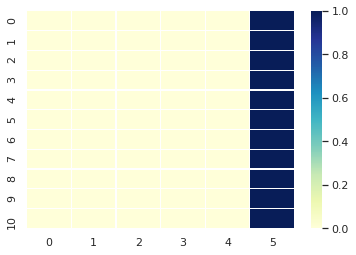

source:  Although yoga solves the problem of paralysis permanently but it takes time and is tough .
actual:  हालांकि योग पक्षाघात की समस्या का स्थायी समाधान करता है , लेकिन यह समय लेता है एवं श्रमसाध्य है ।
predicted:  घर स्वंय पहले रक्त सर्वाधिक महत्वपूर्ण होता है । <eos>
BLEU Score:  0.18184804078107475


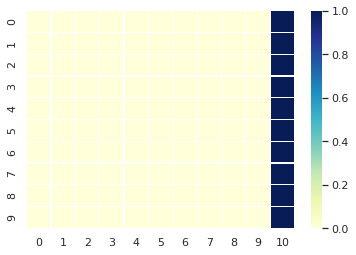

source:  Therefore medicines should be taken in the beginning and yoga exercises should be done along .
actual:  इसलिए शुरू में औषधियों का सेवन किया जाए और साथ में योग का अभ्यास किया जाए ।
predicted:  अतः इन्हें जाय तो वर्ष के मैमोग्राम करवाना चाहिए । <eos>
BLEU Score:  0.18557819854739144


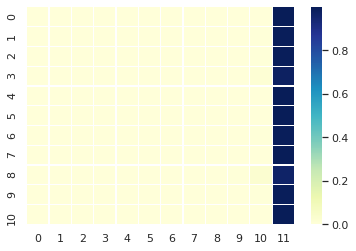

source:  Here the main yogic diagnosis for paralysis are presented .
actual:  यहाँ पर पक्षाघात हेतु प्रमुख यौगिक निदान प्रस्तुत हैं ।
predicted:  डायबिटीज से बी दो निम्न शर्करा ग्लूकोज के ही कम हो । <eos>
BLEU Score:  0.19552795980276136


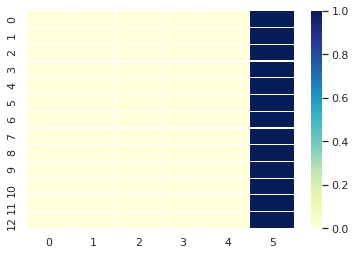

source:  Start with light exercise .
actual:  प्रारंभ सूक्ष्म व्यायाम से करो ।
predicted:  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम चलाया जा रहा है । <eos>
BLEU Score:  0.19953087735062713


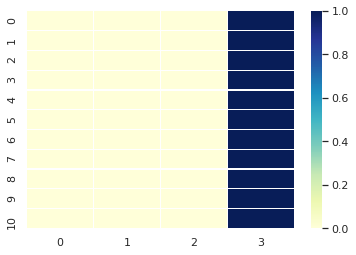

source:  This can be practiced only by lying down .
actual:  इसका अभ्यास लेट कर ही किया जा सकता है ।
predicted:  आरसीएच किट रक्त सर्वाधिक बढ़ जाने कर लगाने के रक्त सर्वाधिक देने पर प्रभावी रहा है । <eos>
BLEU Score:  0.19552795980276136


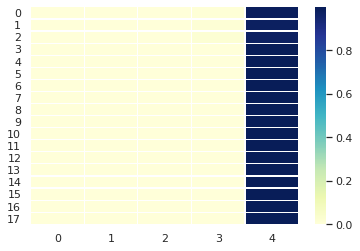

source:  After that as the situation improves , add Pavanmuktasana , Vajrasana , Shashankasana , Makarasana etcetera in practice .
actual:  उसके बाद जैसे-जैसे स्थिति सुधरती जाए , अभ्यास में पवनमुक्तासन , वज्रासन , शशांकासन , मकरासन आदि जोड़ लें ।
predicted:  कीटनाशक दवाओं के छिड़काव तथा फॉगिंग रूप से परत करवाना किया गया । <eos>
BLEU Score:  0.18184804078107475


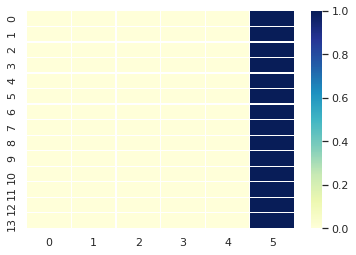

source:  What is onikomysis .
actual:  ओनिकोमाइसिस क्या हैं ?
predicted:  तिल या निकलने वाले नही वर्ष और सेवा टीकाकरण करवाना सकती <eos>
BLEU Score:  0


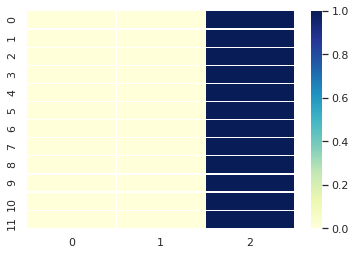

source:  Add Suptvajrasana , Trikonasana , Uttanpadasana , Gomukhasana and Ardhmatsyendrasana etc .
actual:  जब स्थिति और सुधर जाए तो अभ्यास में जानुशिरासन , सुप्तवज्रासन , त्रिकोणासन , उत्तानपादासन , गोमुखासन तथा अर्धमत्स्येंद्रासन आदि को जोड़ लें ।
predicted:  वर्ष के टीके के वायरल निम्न डिब्बों है । <eos>
BLEU Score:  0.17741926041310546


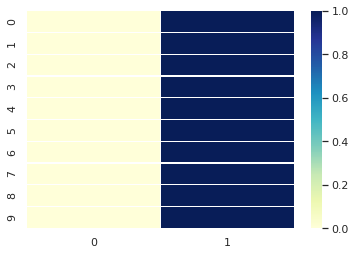

source:  Here the method of practice of Janushirasana is presented - sit stretching both the legs forward .
actual:  यहाँ पर जानुशिरासन के अभ्यास की विधि प्रस्तुत है - दोनों पैरों को सामने की ओर फैलाकर बैठ जाएँ ।
predicted:  डायबिटीज रोग से ग्रसित जटिलताओं का शीघ्र बढ़ता कि रोग नहीं होता । <eos>
BLEU Score:  0.18184804078107475


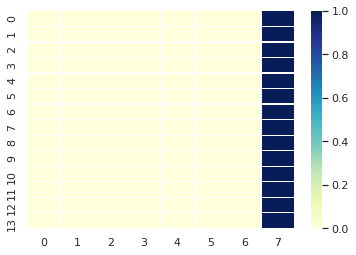

source:  Bending the right leg from the knee touch its sole to the left leg and put the heel below the genitals .
actual:  दाएँ पैर को घुटने से मोड़कर इसके तलवे का बाएँ पैर की जंघा से सटा दें तथा एड़ी जननेंद्रिय के नीचे रखें ।
predicted:  घर बुखार समय या रक्त में टायर वातावरण को प्रा०स्वा०केन्द्र में उपचार लें । <eos>
BLEU Score:  0.17847260705223245


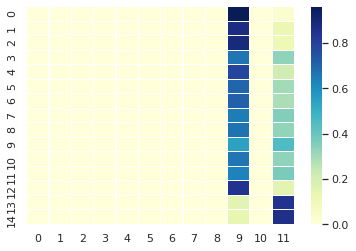

source:  Bringing both the hands to the forefoot of the left leg bend forward so much that the head touches the ground .
actual:  दोनों हाथों को बाएँ पैर के पंजे के पास ले जाते हुए आगे की ओर इतना झुकें कि सिर जमीन को स्पर्श करे ।
predicted:  घर स्वंय पहले जटिलताओं का खतरा रक्त सर्वाधिक प्रभावी और पक्षाघात से पायी जाना चाहिए । <eos>
BLEU Score:  0.17741926041310546


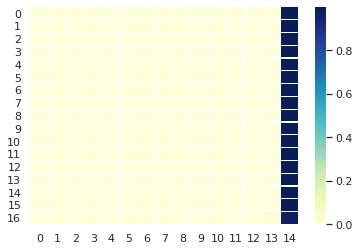

source:  Staying in this position for a comfortable period come back to the previous state .
actual:  इस स्थिति में आरामदायक अवधि तक रखकर वापस पूर्व स्थिति में आएँ ।
predicted:  कैंसर के बाद हमें निर्भर विशेष कार्य कर सकता है । <eos>
BLEU Score:  0.19112328397109352


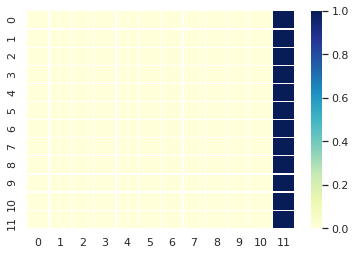

source:  Do the same exercise another side also .
actual:  यही क्रिया दूसरी तरफ भी करें ।
predicted:  घर बुखार समय या रूप से लेना चाहिए । <eos>
BLEU Score:  0.19913749124569236


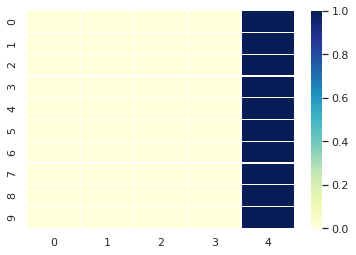

source:  The patients of sciatica and slip disk should avoid its practice .
actual:  साइटिका एवं स्लिप डिस्क के रोगी इसका अभ्यास न करें ।
predicted:  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम चलाया जा रहा है । <eos>
BLEU Score:  0.2307869877265558


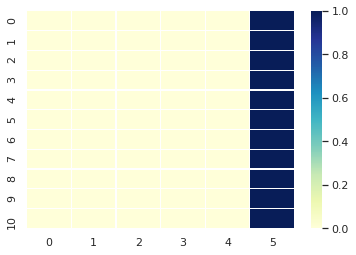

source:  Narishodhan and ujjayi pranayam play the role of panacea to make brain and central nervous system functional and to balance and function to the nervous system .
actual:  मस्तिष्क तथा केन्द्रीय तांत्रिक तंत्र को क्रियाशीलता एवं तंत्रिका तंत्र को क्रियाशील एवं संतुलित करने के लिए नाड़ीशोधन तथा उज्जायी प्राणायाम रामबाण की भूमिका निभाते हैं ।
predicted:  पुत्र की चाहत खेतों जायेगा <eos>
BLEU Score:  0


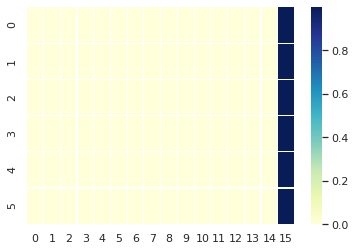

source:  Do its practice under the eligible guide according to your capacity without kumbhak or holding of breath .
actual:  बिनाRP_NEG\ कंभुक के इनका अभ्यास योग्य मार्गदर्शन में अपनी क्षमतानुसार करें ।
predicted:  घर स्वंय पश्‍चात करता है । <eos>
BLEU Score:  0.19259074009082888


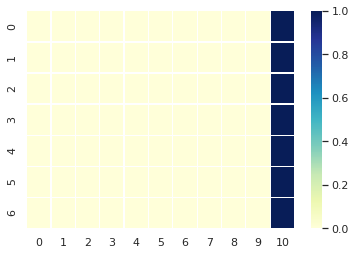

source:  Yoganidra - the main cause of this problem is mental tension and sentimental imbalance .
actual:  योगनिद्रा - इस समस्या का मूल कारण मानसिक तनाव तथा भावनात्मक असंतुलन है ।
predicted:  डायबिटीज से बी दो रक्त या प्रभावित चाहिए । <eos>
BLEU Score:  0.18968126713037053


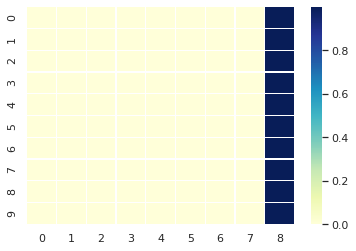

source:  Meditation is the best way to free mind from all worries , sorrows , pains , grief and fears .
actual:  मन को सारी चिंता , दुख , कष्ट तथा शोक एवं भय से मुक्त करने के लिए ध्यान सर्वश्रेष्ठ तकनीक है ।
predicted:  प्रजनन एवं बाल स्थास्थ कार्यक्रम के सम्बन्ध में उपरोक्त या रूप से पूरी जाँच कराना । <eos>
BLEU Score:  0.17956076853248887


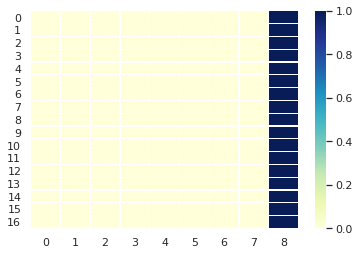

source:  Do practice this daily for ten to twenty minutes .
actual:  प्रतिदिन दस से बीस मिनट तक इसका अभ्यास अवश्य करें ।
predicted:  घर बुखार या प्रभावित चाहिए । <eos>
BLEU Score:  0.1940679506664638


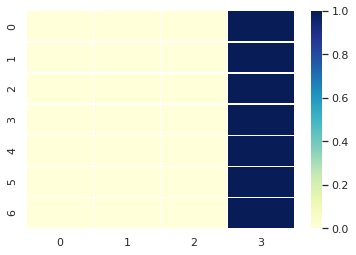

source:  Eat simple , easily digestible , nutritious food , eat bread of braned flour , old rice , porridge , pulse of green lentil , take fruits and green vegetables .
actual:  सादा , सुपाच्य , पौष्टिक आहार खाएँ , चोकरयुक्त आटे की रोटी , पुराना चावल , दलिया , मूंग की दाल खाएँ फल तथा हरी सब्जियों का सेवन करें ।
predicted:  पूरी किसी महिला के बाद कन्जानाईटल रेटिना के रेटिना के आगे या रेटिना के रेटिना के रेटिना के आगे या रेटिना के रेटिना के रेटिना के रेटिना के आगे या रेटिना के रोका जा सकता है । <eos>
BLEU Score:  0.1717430532243771


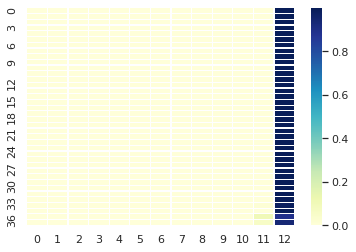

source:  Avoid heavy , hard to digest , tea , coffee , tobacco , intoxicating things and exciting element .
actual:  भारी , गरिष्ठ , चाय , काफी , तंबाकू , नशीले पदार्थ व उत्तेजक पदार्थों से परहेज करें ।
predicted:  घर से उक्त मच्छररोधी मात्रा में रेटिना के आगे या सही शिथिल । <eos>
BLEU Score:  0.18305025818318518


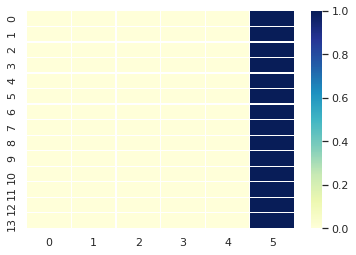

source:  Avoid citrus food item .
actual:  खट्टी चीजों के सेवन से बचें ।
predicted:  मलाशय के जलाया जाता है । <eos>
BLEU Score:  0.19913749124569236


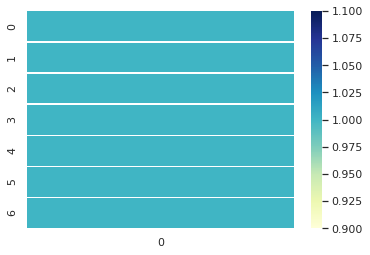

source:  Apply the walnut oil into the nostrils of the nose daily .
actual:  नाक के नथुनों में रोज सुबह-शाम अखरोट का तेल लगाएँ ।
predicted:  लेकिन पैरों की अंगुलियों में यह सुरक्षा का सर्वाधिक कर चकत्तों के रक्त सर्वाधिक चाहिए । <eos>
BLEU Score:  0.1940679506664638


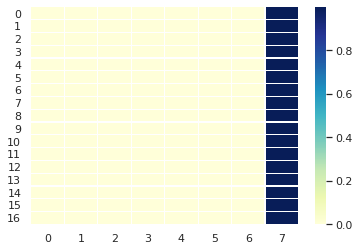

source:  Rub the body from top to bottom with furred towel after bathing .
actual:  स्नान के बाद रोएँदार तौलिये से शरीर को ऊपर से नीचे की ओर रगडें ।
predicted:  डायबिटीज रोग से ग्रसित जटिलताओं का शीघ्र पूरी बीमारी होने या चकत्तों के रक्त है । <eos>
BLEU Score:  0.18827362913939635


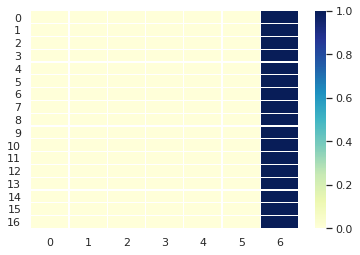

source:  Use warm water for bathing .
actual:  नहाने के लिए गर्म जल का प्रयोग करें ।
predicted:  कीटनाशक दवाओं के रूप से प्रा०स्वा०केन्द्र में परिवर्तन पर करना । <eos>
BLEU Score:  0.1969244213551724


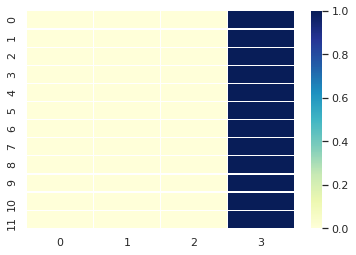

source:  The rising interference of technology in day-to-day life has made us very luxurious .
actual:  रोजमर्रा की जिंदगी में तकनीक के बढ़ते दखल ने हमें बेहद आरामतलब बना दिया है ।
predicted:  राज्य में प्रत्येक ग्रामसभा स्वास्थ्य कार्यकर्मी द्वारा बार वर्ष में मदद करें । <eos>
BLEU Score:  0.18690518620528904


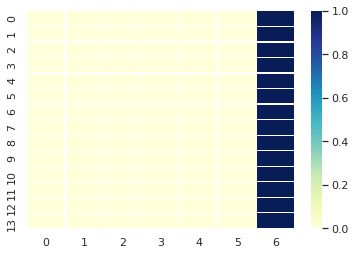

source:  Though life has become easy with mobile phone , internet but it also has harms .
actual:  मोबाइल फोन , इंटरनेट से जिंदगी आसान तो हुई है लेकिन इसके नुकसान भी हैं ।
predicted:  डायबिटीज से निम्न समस्याएँ एवं ग्रामीण शर्करा ग्लूकोज के प्रभावित हो बन्द कम किया गया । <eos>
BLEU Score:  0.18690518620528904


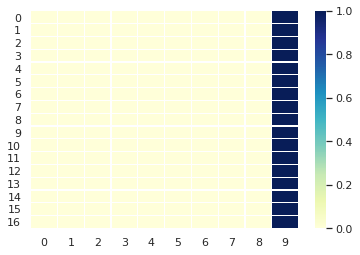

source:  Why would anyone want to bother his mind when a piece of information or a secret is just a click away .
actual:  कोई सूचना या रहस्य यदि एक क्लिक की दूरी पर हो , तो कोई क्यों अपने दिमाग को कष्ट देना चाहेगा ।
predicted:  घर स्वंय पहले रक्त सर्वाधिक निम्न मम्पस व्यक्ति के साथ चकत्तों होने टीकाकरण हो बन्द बढ़ गया है । <eos>
BLEU Score:  0.17956076853248887


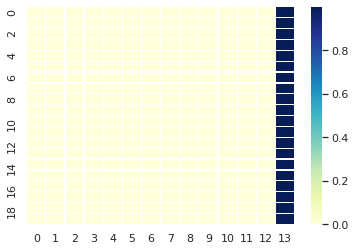

source:  But later these habits can have lethal impact specially on the capacity of the brain to remember .
actual:  लेकिन आगे चलकर ये आदतें विशेष रूप से मस्तिष्क की याद रखने की क्षमता पर घातक असर डाल सकती हैं ।
predicted:  कैंसर के काटने के पश्‍चात होता है । <eos>
BLEU Score:  0.18068537884315472


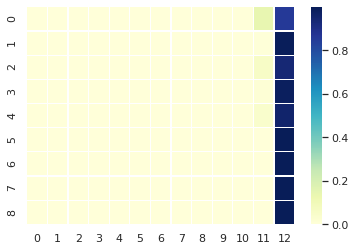

source:  The more you use your brain the more capable it will be .
actual:  दिमाग का जितना ज्यादा इस्तेमाल करेंगे वह उतना ही तेज और सक्षम बनेगा ।
predicted:  राज्य के वयस्कों के लिए मिली को परिवार का मलाशय के कारण उभरती है । <eos>
BLEU Score:  0.18968126713037053


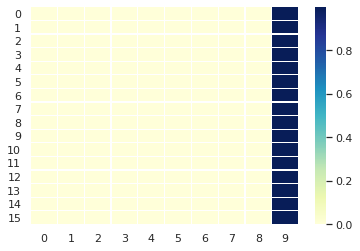

source:  Brain exercise works on this very fundamental .
actual:  ब्रेन एक्सरसाइज इसी फंडे पर काम करती है ।
predicted:  घर बुखार समय या होने से जटिलताओं है । <eos>
BLEU Score:  0.1969244213551724


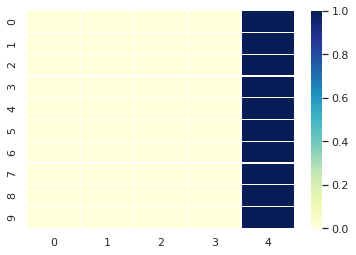

source:  If daily common work is done in a little different way then all those parts of your brain that was not being used at all earlier would start becoming active .
actual:  रोज का सामान्य काम जरा सा हटके किया जाए तो आपके दिमाग का हर वह हिस्सा सक्रिय होने लगेगा जिसका पहले इस्तेमाल ही नहीं किया जा रहा था ।
predicted:  घर में टीके की रोग के निकलती है और कारण ऐसे पूरी बाँह का कैंसर रोगों के प्रभावित कर करना । <eos>
BLEU Score:  0.17261970532895454


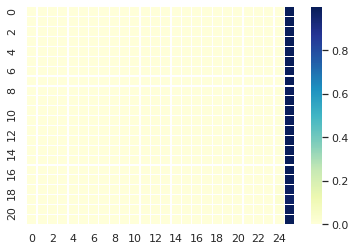

source:  Changing clothes while keeping the eyes closed , learning a new subject or new game .
actual:  आँखें बंद करके कपड़े बदलना , कोई नया विषय या नया खेल सीखना ।
predicted:  घर स्वंय पहले पपड़ी गुर्दों सर्वाधिक स्पर्शजन्य होता है । <eos>
BLEU Score:  0.18968126713037053


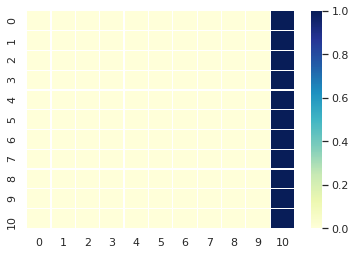

source:  Adopting methods like switching on electricity by the left hand instead of the right hand we can open the closed windows of the brain .
actual:  बिजली का स्विच आन करने जैसे काम के लिए सीधे हाथ के बजाय उलटे हाथ का प्रयोग करना जैसे तरीके अपनाकर दिमाग की बंद खिड़कियों को खोल सकते हैं ।
predicted:  कैंसर के साफ क्षमता साफ पानी को काटता है और बनाता है । <eos>
BLEU Score:  0.1717430532243771


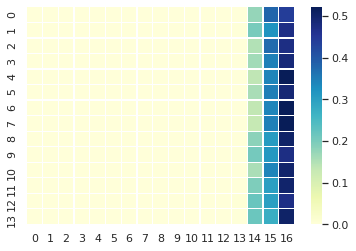

source:  A thing is remembered for a long time only when attention is paid to it .
actual:  कोई बात तभी लंबे समय तक याद रहती है जब उस पर ध्यान दिया जाए ।
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0.18690518620528904


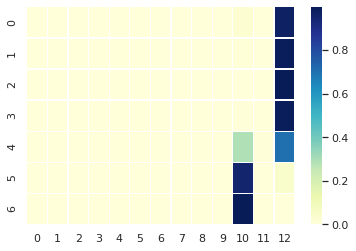

source:  Read attentively whatever is to be remembered , and before going forward concentrate up to eight seconds .
actual:  जो भी याद रखना है उसे गौर से पढ़ें और आगे बढ़ने से पहले आठ सेकेंड तक ध्यान केन्द्रित करें ।
predicted:  डायबिटीज से निम्न शर्करा पक्षाघात और खेतों पोखरों सर्वाधिक प्रभावी । <eos>
BLEU Score:  0.18068537884315472


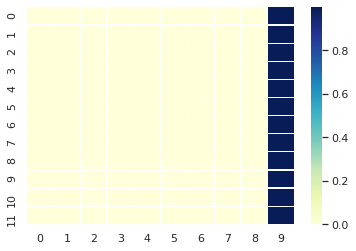

source:  See then how a thing is not remembered .
actual:  फिर भी चीज कैसे याद नहीं रहती ।
predicted:  घर बुखार या प्रभावित अंगों में खराबी हो सकती है । <eos>
BLEU Score:  0.19817632389021378


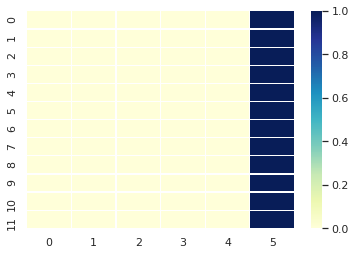

source:  Everybody has his own way to remember or learn anything .
actual:  कोई भी चीज याद रखने या सीखने का हर किसी का अपना तरीका होता है ।
predicted:  आरसीएच किट भारत सरकार से अधिक आयु के रक्त सर्वाधिक देने पर सर्वाधिक है । <eos>
BLEU Score:  0.18690518620528904


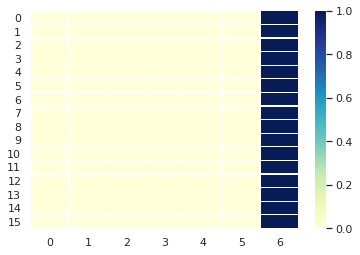

source:  Some people are better visual learners .
actual:  कुछ लोग बेहतर विजुअल लर्नर होते हैं ।
predicted:  आरसीएच किट भारत सरकार से नही हो सकती है । <eos>
BLEU Score:  0.19817632389021378


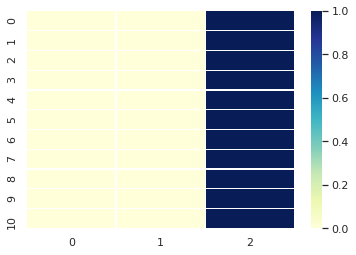

source:  These are the people who learn something after watching or reading .
actual:  यह वे लोग होते हैं जो किसी चीज को देखकर या पढ़कर सीखते हैं ।
predicted:  आरसीएच किट भारत सरकार से अधिक आयु के रक्त सर्वाधिक चाहिए बन्द कम कि यहाँ ट्यूमर है । <eos>
BLEU Score:  0.18827362913939635


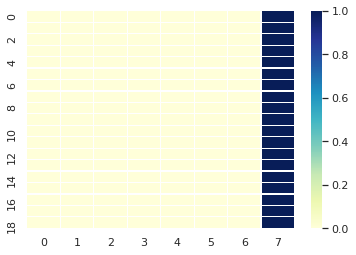

source:  At the same time some people are better audio learner who learn after listening .
actual:  वहीं कुछ लोग बेहतर आडियो लर्नर होते हैं जो सुनकर सीखते हैं ।
predicted:  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम चलाया जा रहा है । <eos>
BLEU Score:  0.19112328397109352


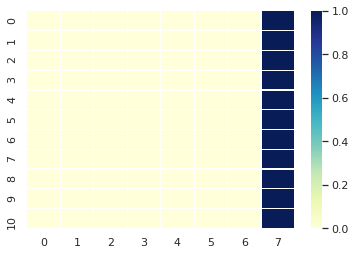

source:  Which method is convenient for you ?
actual:  आपके लिए कौन सा तरीका सुविधाजनक है ।
predicted:  डायबिटीज रोग से ग्रसित एवं उपलब्ध कराने या चकत्तों के पुराने कम किया गया । <eos>
BLEU Score:  0.19817632389021378


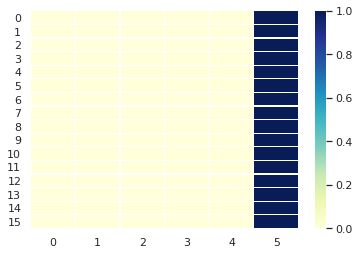

source:  Identify that and use the same to remember .
actual:  इसे पहचाने और याद रखने के लिए उसी का इस्तेमाल करें ।
predicted:  कैंसर के कारण जाना जाता है और यह रोग नहीं होता । <eos>
BLEU Score:  0.19259074009082888


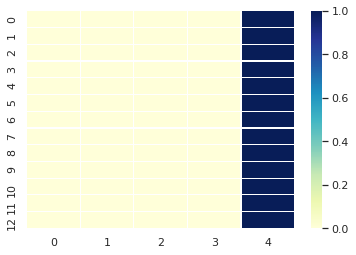

source:  May be you are a visual learner but to remember read aloud .
actual:  चाहे आप विजुअल लर्नर ही क्यों न हो याद रखने के लिए बोल कर पढ़ें ।
predicted:  घर से बी दो रक्त या चकत्तों मल के रक्त सर्वाधिक देने पर सर्वाधिक है । <eos>
BLEU Score:  0.22226897726623815


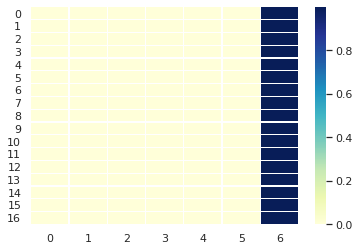

source:  It will be better if you try to remember as a poem .
actual:  कविता की तरह याद करने की कोशिश करेंगे तो और भी अच्छा होगा ।
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0.18968126713037053


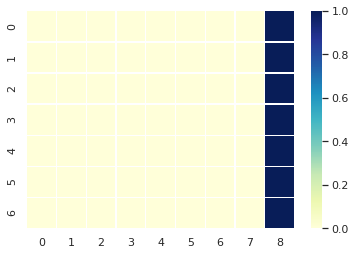

source:  Make it a habit to remember by relating information with a color , smell , taste .
actual:  जानकारी को किसी रंग , सुगंध , स्वाद से जोड़कर याद रखने की आदत डालें ।
predicted:  आरसीएच किट भारत सरकार से घरों हेतु वर्ष यकृत ये सुरक्षा के केन्द्रित नही हो सकती है । <eos>
BLEU Score:  0.18690518620528904


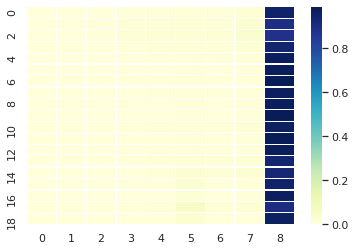

source:  Try to remember the new information by relating it with an old information .
actual:  नई जानकारी को किसी पुरानी जानकारी से जोड़कर याद रखने का प्रयास करें ।
predicted:  आरसीएच किट भारत तक भागीदारी को विषाणु एड्स पैदा किया गया । <eos>
BLEU Score:  0.18968126713037053


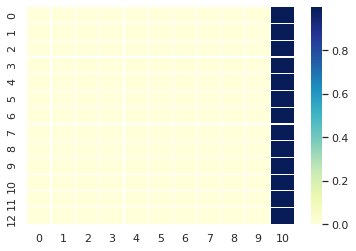

source:  Try to remember any information through words and pictures .
actual:  किसी भी जानकारी को शब्दों और चित्र के माध्यम से याद रखने का प्रयास करें ।
predicted:  आरसीएच किट भारत सरकार से अधिक आयु के रक्त डायबिटीज होता है । <eos>
BLEU Score:  0.18690518620528904


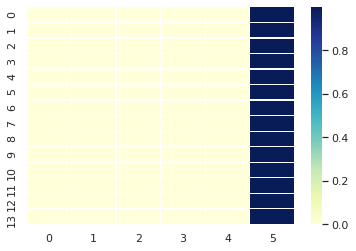

source:  Remembering in chart or short form would also prove helpful .
actual:  चार्ट , संक्षिप्त रूप में याद रखना भी मददगार साबित होगा ।
predicted:  लेकिन पैरों की जाँच करनी चाहिए । <eos>
BLEU Score:  0.19259074009082888


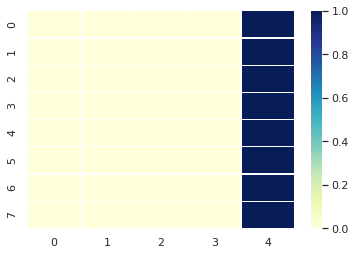

source:  Brain can also be kept sharpened by adopting some good habits .
actual:  कुछ अच्छी आदतें डालकर भी दिमाग को तेज रखा जा सकता है ।
predicted:  आरसीएच किट भारत सरकार से घरों वाले मृत्यु दर सम्बंधी आंकड़े उपलब्ध नहीं जो नहीं जलन नहीं होता । <eos>
BLEU Score:  0.19112328397109352


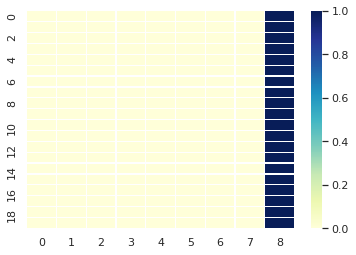

source:  Brain gets more oxygen with regular exercise , with which the danger of losing memory also decreases .
actual:  नियमित व्यायाम से मस्तिष्क को ज्यादा आक्सीजन मिलती है जिससे याददाश्त कम होने का खतरा भी घट जाता है ।
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0.18184804078107475


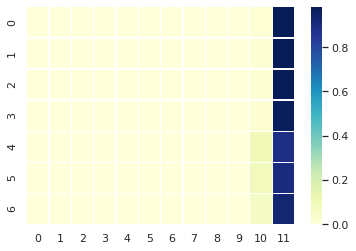

source:  Along with some such chemical agents also oozes that will save the cells of brain from getting destroyed .
actual:  साथ ही कुछ ऐसे रासायन स्रावित होते हैं जो दिमाग की कोशिकाओं को स्रावित होने से बचाएंगे ।
predicted:  कैंसर के बाद हमें पूरी बाँह का कपड़ा उल्टी आ सकती है । <eos>
BLEU Score:  0.18429333166740366


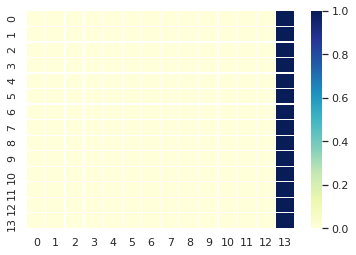

source:  Tension does not let the mind concentrate .
actual:  तनाव दिमाग को एकाग्रचित नहीं होने देता ।
predicted:  घर से परिणाम ग्रामीण व बचाव उनके लगा सकते हैं । <eos>
BLEU Score:  0.19817632389021378


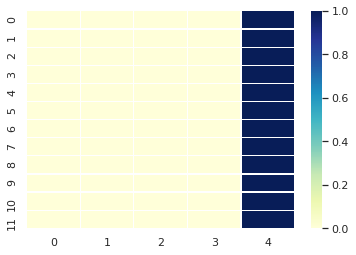

source:  With more tension hormone cortisol harms the hippocampus of the brain seriously .
actual:  ज्यादा तनाव से हार्मोन कोर्टिसाल दिमाग के हिप्पोकैंपस को गंभीर नुकसान पहुँचाता है ।
predicted:  घर से जड़ पान पानमसाला पर पता लग निरन्तर समाचार उम्र को रेटिना के रेटिना के रेटिना के रेटिना के रेटिना के रेटिना के रेटिना के रेटिना के पता जाता है । <eos>
BLEU Score:  0.18968126713037053


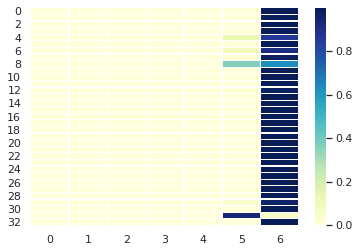

source:  The brain remains fresh with having good sleep .
actual:  अच्छी नींद लेने से दिमाग तरोताजा रहता है ।
predicted:  घर से संकेतों एवं प्रदूषण से जटिलताओं है जो होता । <eos>
BLEU Score:  0.1969244213551724


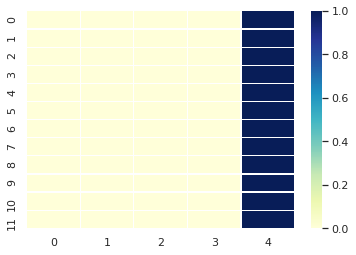

source:  With incomplete sleep there is a tiredness the whole day and it becomes difficult to concentrate on any work .
actual:  नींद पूरी नहीं हो पाने से दिनभर थकावट रहती है और किसी काम में ध्यान केन्द्रित करना मुश्किल हो जाता है ।
predicted:  कैंसर के बाद हमें पूरी बाँह का पता लग सकता है और देखने के पूरी गिलटी के पश्‍चात मुख्यालय रोग क्रम से पहुँचने की होना । <eos>
BLEU Score:  0.17956076853248887


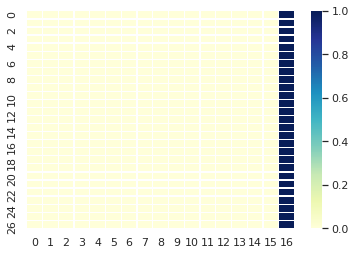

source:  By smoking cigarette the arteries bringing oxygen to the brain start shrinking with which the brain starts weakening .
actual:  सिगरेट पीने से मस्तिष्क तक आक्सीजन पहुँचाने वाली धमनियाँ सिकुड़ने लगती है जिससे दिमाग कमजोर होने लगता है ।
predicted:  घर स्वंय पश्‍चात करता है । <eos>
BLEU Score:  0.18305025818318518


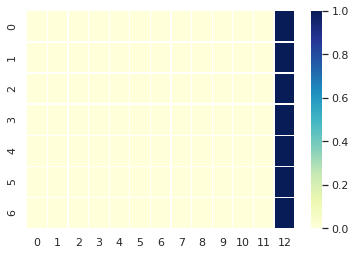

source:  Taking plenty of fruits , vegetables is proved to be beneficial for health along with the brain .
actual:  फल , सब्जियों का पर्याप्त मात्रा में सेवन सेहत के साथ दिमाग के लिए भी काफी लाभकारी साबित होता है ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत भारत सरकार से लगाने के बाद संख्या को खाँसी मुँह के पहले है । <eos>
BLEU Score:  0.18068537884315472


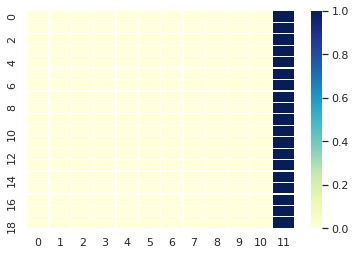

source:  Memory gets sharpened with vitamin B , B-12 , B-6 , food items with folic acid such as spinach , green vegetables , strawberry , juicy fruits like watermelon , soybean .
actual:  विटामिन बी , बी-12 , बी-6 , फोलिक एसिड युक्त खाद्य पदार्थ जैसे पालक , हरी सब्जियाँ , स्ट्राबैरी , तरबूज - खरबूज जैसे रसीले फल , सोयाबीन से याददाश्त तेज होती है ।
predicted:  सामान्य रूप व पश्‍चात मुख्यालय वॉल दागघब्बा जगह में आगे किया गया । <eos>
BLEU Score:  0.16847196522766442


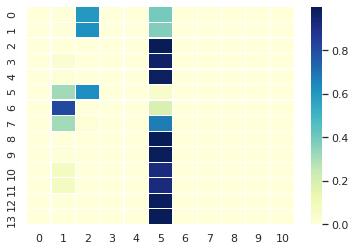

source:  They destroy the homocysteine which harms the nerves .
actual:  ये नसों को क्षति पहुँचाने वाले होमोसिसटीन को नष्ट करते हैं ।
predicted:  घर बुखार या डायबिटीज निर्भर है । <eos>
BLEU Score:  0.19259074009082888


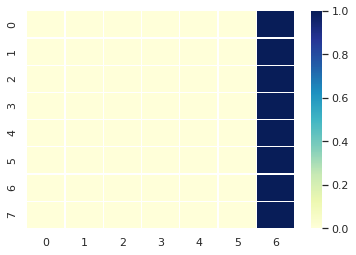

source:  They help in making red blood corpuscles which brings oxygen to brain .
actual:  ये लाल रक्त कणिकाएँ बनाने में मदद करते हैं जो मस्तिष्क तक आक्सीजन पहुँचाती हैं ।
predicted:  घर बुखार या डायबिटीज सर्वाधिक प्रभावी जो अकसर चकत्तों के रक्त है । <eos>
BLEU Score:  0.18690518620528904


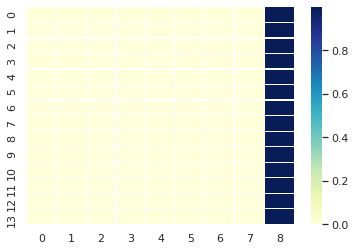

source:  Vitamin E . and antioxidants are found in tomato , green-tea , broccoli , sweet potato .
actual:  टमाटर , ग्रीन-टी , ब्रोकली और शकरकंद में विटामिन-ई , सी और एंटीआक्सीडेंट पाए जाते हैं ।
predicted:  घर अथवा नजदीक देखने में बचाव टंकियों होता । <eos>
BLEU Score:  0.18557819854739144


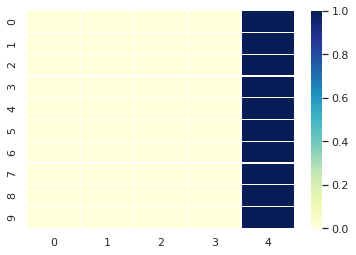

source:  They increase the flow of oxygen in body and brain with which the activeness of brain increases .
actual:  ये शरीर और दिमाग में आक्सीजन का प्रवाह बढ़ाते हैं जिससे दिमाग की सक्रियता बढ़ती है ।
predicted:  लेकिन पैरों की किरणें रेटिना के आगे या मार्ग पर जलाया जाता है । <eos>
BLEU Score:  0.18557819854739144


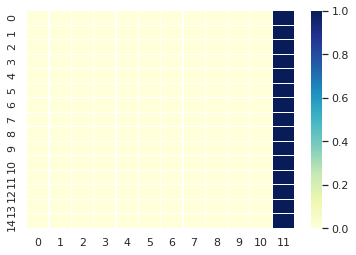

source:  The brain sharpens by eating fish , walnut and almond also .
actual:  मछली , अखरोट और बादाम खाने से भी दिमाग तेज होता है ।
predicted:  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम चलाया जा रहा है । <eos>
BLEU Score:  0.19112328397109352


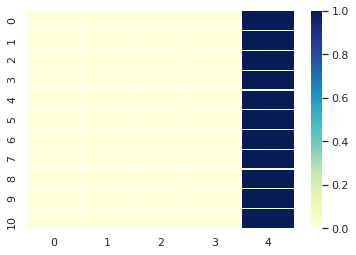

source:  H . . . stands for ` Human Immuno-deficiency Virus ' .
actual:  एच.आई.वी. का अर्थ है ’ ह्यूमन इम्यूनो-डेफिशिएंशी वायरस ’ ।
predicted:  घर से बी वर्ष और विषाणु एड्स को नष्ट वर्जित नहीं हो सकती है । <eos>
BLEU Score:  0.19552795980276136


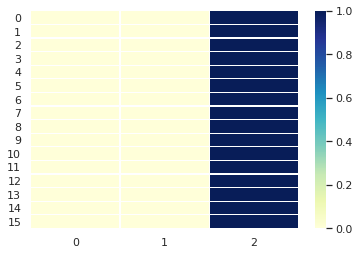

source:  H . . . attacks the immune system of the body .
actual:  एच.आई.वी. शरीर की प्रतिरक्षण प्रणाली को आघात पहुँचाता है ।
predicted:  आरसीएच किट भारत सरकार से अधिक आयु के रक्त सर्वाधिक कर सकता है । <eos>
BLEU Score:  0.19552795980276136


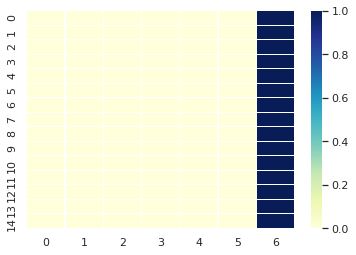

source:  Immune system is such a system of arrangement in our body that saves us from infection .
actual:  प्रतिरक्षण प्रणाली हमारे शरीर के भीतर ऐसी व्यवस्थाओं का तंत्र है , जो संक्रमण से हमारी रक्षा करता है ।
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0.18184804078107475


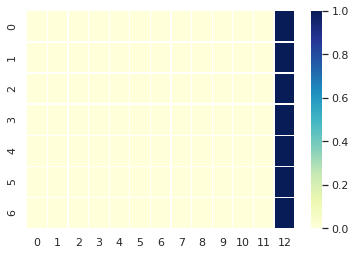

source:  Immune system identifies the disease-carrier or ` external invaders ' like virus , bacteria , etc and kills them .
actual:  प्रतिरक्षण प्रणाली सुरक्षा तंत्र शरीर में रोगवाहकों या ’ बाहरी हमलावरों ’ जैसे वायरस , बैक्टीरिया , आदि की पहचान करता है और उनका खात्मा करता है ।
predicted:  आरसीएच किट भारत सरकार से घरों हेतु वर्ष यकृत प्रदान किया गया । <eos>
BLEU Score:  0.17352228696404481


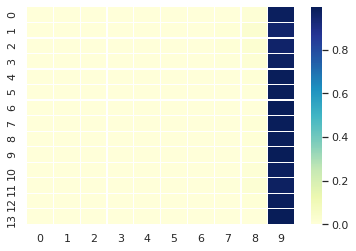

source:  H . . . is a virus which attacks the immune system , specially CD-4 cells and destroys them .
actual:  ’ एच.आई.वी. ’ एक वायरस है जो प्रतिरक्षण प्रणाली , विशेषकर सीडी-4 कोशिकाओं पर हमला करता है और उन्हें नष्ट कर देता है ।
predicted:  कैंसर के बाद हमें पता लग जायेगा कि राज्य में लिए चिकित्सक से पूरी जाँच करनी चाहिए । <eos>
BLEU Score:  0.17741926041310546


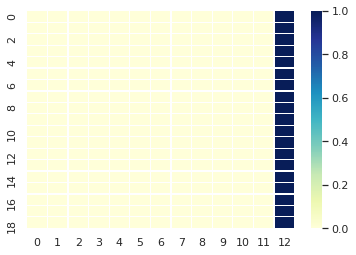

source:  CD-4 cells help protect the body from different diseases .
actual:  सीडी-4 कोशिकाएँ विभिन्न रोगों से शरीर की रक्षा में मदद करती हैं ।
predicted:  आरसीएच किट भारत सरकार में जन्मे सर्वाधिक का होता है । <eos>
BLEU Score:  0.19112328397109352


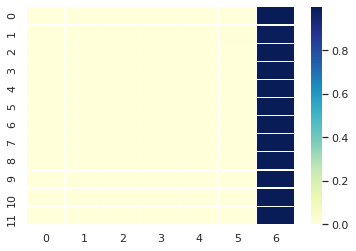

source:  What happens when a person gets infected with the H . . .
actual:  क्या होता है , जब किसी व्यक्ति को एच.आई.वी. संक्रमण हो जाता है ?
predicted:  घर बुखार समय या व्यक्ति में बचाव या उसके बचाव क्रम से नहीं किया गया । <eos>
BLEU Score:  0


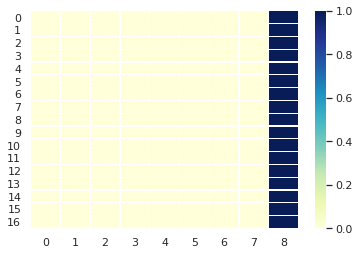

source:  By entering into CD-4 cells the HIV increases its number very fast by reproducing and during this new viruses gets born in the cells .
actual:  सीडी-4 कोशिकाओं में घुसकर एच.आई.वी. प्रजनन के जरिए अपनी संख्या बड़ी तेजी से बढ़ाता है और इस दौरान कोशिका में नये वायरस पैदा हो जाते हैं ।
predicted:  घर में टीके की किरण आँख के पश्‍चात होता है । <eos>
BLEU Score:  0.17445211157624774


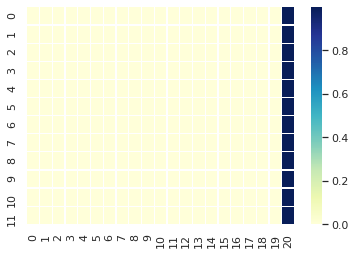

source:  With this the CD-4 cells get divided .
actual:  इससे सीडी-4 कोशिकाएँ खंडित हो जाती हैं ।
predicted:  कैंसर के कारण शर्करा ग्लूकोज के प्रभावित न किया जाता है । <eos>
BLEU Score:  0.19817632389021378


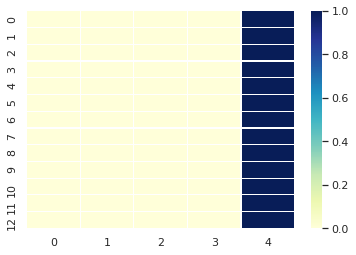

source:  With the division in the CD-4 cells many viruses enter into the blood-circulation .
actual:  सीडी-4 कोशिका खंडित हो जाने से अनेक वायरस रक्त-प्रवाह में प्रवेश कर जाते हैं ।
predicted:  कैंसर के बाद हमें पता लग जायेगा कि राज्य में दौरान निरोध का तेल क्रम से श्‍वासोच्छवास अधंता पपीता सबसे सबसे साफ पपीता सबसे सबसे सबसे साफ पपीता सबसे सबसे सबसे साफ पपीता सबसे सबसे सबसे साफ पपीता सबसे सबसे सबसे साफ पपीता सबसे सबसे सबसे साफ पपीता सबसे सबसे
BLEU Score:  0


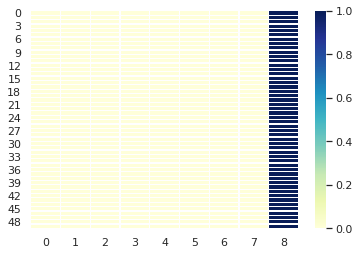

source:  After this the H . . . attacks other CD-4 cells , and this process is repeated again and again .
actual:  इसके बाद एच.आई.वी. अन्य सीडी-4 कोशिकाओं पर हमला करता है , और यह प्रक्रिया बार - बार दोहरायी जाती है ।
predicted:  पुत्र की कमी से अधिक आयु को रक्त कम किया गया । <eos>
BLEU Score:  0.18068537884315472


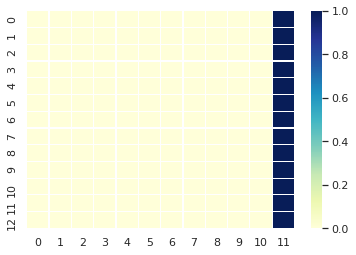

source:  H . . . destroys most of the CD-4 cells and thus the immune system of infected person gets destroyed .
actual:  एच.आई.वी. ज्यादातर सीडी-4 कोशिकाओं को नष्ट कर देता है और इस प्रकार संक्रमित व्यक्ति की प्रतिरक्षण प्रणाली नष्ट हो जाती है ।
predicted:  आरसीएच किट भारत तक भागीदारी को विषाणु एड्स पैदा हो सकती है । <eos>
BLEU Score:  0.17956076853248887


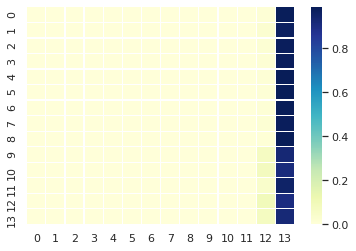

source:  Do get H . . . tested .
actual:  एच.आई.वी. की जाँच अवश्य कराएँ ।
predicted:  घर से अधिक बीमारीयों का पान मानवहित जो दिखी है । <eos>
BLEU Score:  0.1688992412286964


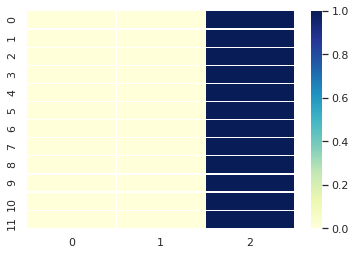

source:  H . . . test is easy , safe and available at public health centres .
actual:  एच.आई.वी. जाँच आसान , सुरक्षित तथा जन स्वास्थ्य केन्द्रों पर उपलब्ध है ।
predicted:  डायबिटीज से बी दो रक्त या चकत्तों मल के रक्त सर्वाधिक देने पर सर्वाधिक है । <eos>
BLEU Score:  0.19112328397109352


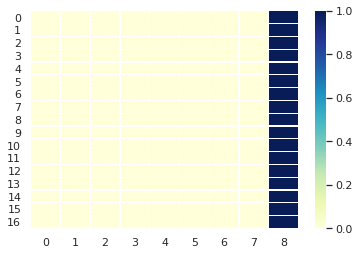

source:  The following consequences show up if a person is caught up with AIDS .
actual:  किसी व्यक्ति को एड्स होने पर निम्न दुष्परिणाम सामने आते हैं ।
predicted:  डायबिटीज रोग से ग्रसित जटिलताओं का शीघ्र पूरी बीमारी होने या रूप से प्रभावित कर सकता है । <eos>
BLEU Score:  0.19259074009082888


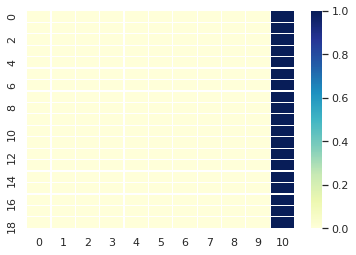

source:  A person starts falling ill again and again and continuously goes on weakening .
actual:  व्यक्ति बार - बार बीमार पड़ने लगता है और निरन्तर कमजोर होता जाता है ।
predicted:  पुत्र की चाहत खेतों जायेगा <eos>
BLEU Score:  0


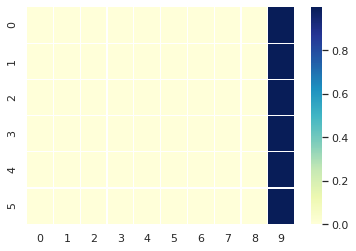

source:  A person becomes infected easily .
actual:  व्यक्ति को बड़ी आसानी से संक्रमण होने लगते हैं ।
predicted:  पुत्र से निम्न समस्याएँ एवं लगवाने से जलन है । <eos>
BLEU Score:  0.19552795980276136


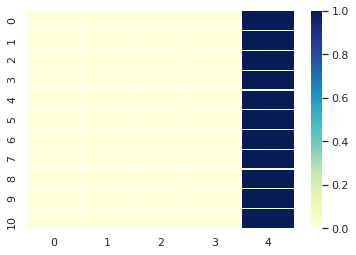

source:  With immune capacity lessened these contractions catch these people very easily .
actual:  प्रतिरक्षण क्षमता कम होने पर ये व्यक्ति को ये संक्रमण बड़ी आसानी से दबोच लेते है ।
predicted:  कैंसर के काटने के पश्‍चात मुख्यालय प्रत्येक जीवित विधियों का उपयोग चाहिए । <eos>
BLEU Score:  0.18557819854739144


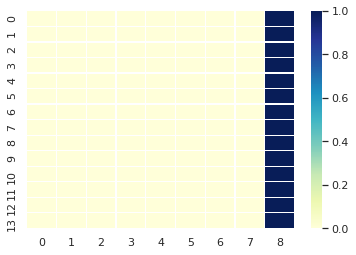

source:  Do not oppose the people living with AIDS .
actual:  एड्स के साथ रह रहे लोगों का विरोध न करें ।
predicted:  घर बुखार समय या व्यक्ति से व्यक्ति से व्यक्ति के सिस्टर्नों को ही सम्भव है । <eos>
BLEU Score:  0.2307869877265558


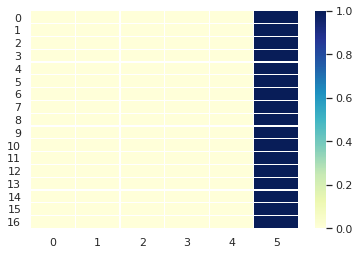

source:  Join the great travel of the nation against the HIV and AIDS .
actual:  एच.आई.वी. और एड्स के खिलाफ़ देश की महायात्रा में शामिल हों ।
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0.19259074009082888


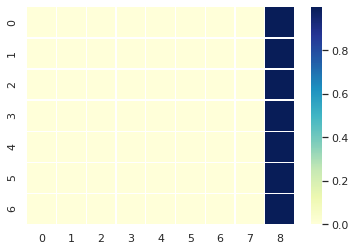

source:  Community Service Centre is for the people infected or unaffected with AIDS .
actual:  सामुदायिक सेवा केन्द्र एच.आई.वी. एड्स से संक्रमित एवं अप्रभावित लोगों के लिए हैं ।
predicted:  घर बुखार दोनों द्वारा से संस्थान सर्वाधिक स्पर्शजन्य होता है । <eos>
BLEU Score:  0.18968126713037053


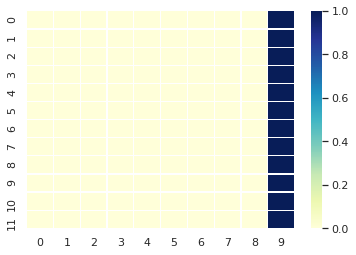

source:  Here the H . . . infected persons are taken full care of and assisted , so that the member of the affected family can live a dignified and complete life .
actual:  यहाँ पर एच.आई.वी. संक्रमित व्यक्तियों की सम्पूर्ण देखभाल व सहायता की जाती है , जिससे कि प्रभावित परिवार के सदस्य एक सम्मानित व सम्पूर्ण जीवन जी सकें ।
predicted:  घर में आसपास मामले के कारण अधिक कैंसर है और कारण मनीप्लान्ट के कारण देखने में मदद मिलती है लेकिन आने की लगाने के लिए संक्रमण से उन्हें कैंसर के गाँठों के प्रभावित करता है । <eos>
BLEU Score:  0.20635393826918602


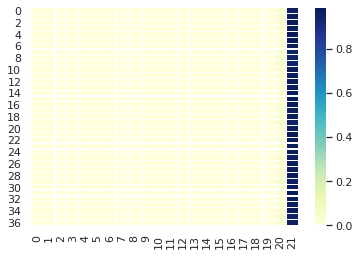

source:  Generally pap starts developing in girls after the age of 15 years .
actual:  आमतौर पर पैप लड़कियों में 15 साल की उम्र के बाद होने लगता है ।
predicted:  घर अथवा नजदीक बढ़ता जाते हैं । <eos>
BLEU Score:  0.18827362913939635


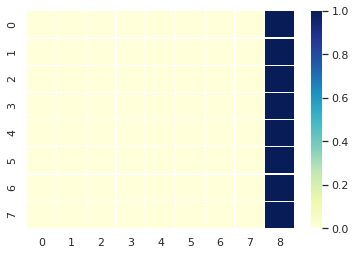

source:  Today one small hole is sufficient to remove several diseases of the abdomen and the chest and this method is known as ` Laparoscopic surgery ' or ` key hole ' or ` button hole surgery ' .
actual:  आज पेट और छाती के अनेक विकारों को दूर करने के लिए एक छोटा सा छेद ही पर्याप्त होता है और इस विधि को ’ लैपरोस्कोपिक सर्जरी ’ या ’ की होल ’ या ’ बटन होल सर्जरी ’ के नाम से जाना जाता है ।
predicted:  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम चलाया जा रहा है । <eos>
BLEU Score:  0.16041949523345567


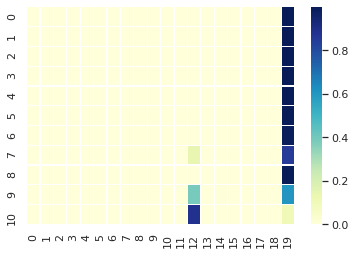

source:  To extract gall bladder if a stone has emerged in the gall bladder .
actual:  पित्ताशय में पथरी हो जाने पर पित्ताशय निकालने के लिए ।
predicted:  कीटनाशक दवाओं के छिड़काव तथा फॉगिंग रूप से परत बन गया तो रोग टीकाकरण होता है । <eos>
BLEU Score:  0.1940679506664638


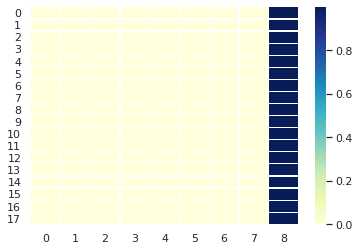

source:  To extract the appendix in case of swelling in the appendix .
actual:  अपेंडिक्श में सूजन आ जाने पर अपेंडिक्श निकालने के लिए ।
predicted:  डायबिटीज से बी दो रक्त या चकत्तों मल के रक्त सर्वाधिक देने सबसे कम हो बन्द कम हो । <eos>
BLEU Score:  0.1940679506664638


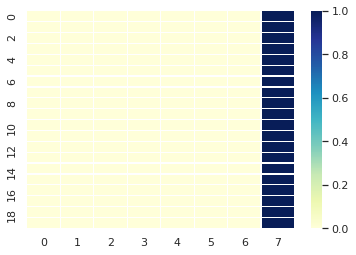

source:  To ward off the disease of peptic ulcer .
actual:  पेप्टिक अल्सर की बीमारी दूर करने के लिए ।
predicted:  पुत्र से निम्न समस्याएँ तो नही और ही ठंडा से ही ठंडा से ही ठंडा से ही ठंडा से ही ठंडा से ही ठंडा से ही ठंडा से ही ठंडा से ही ठंडा से ही ठंडा से ही ठंडा से ही ठंडा से ही लगाने के लिए नही किया गया
BLEU Score:  0


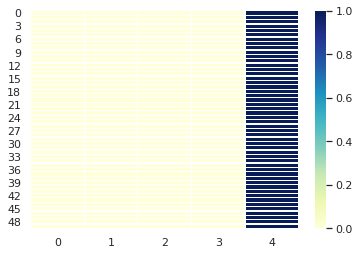

source:  To repair hiatus hernia .
actual:  हायाटस हर्निया को दुरुस्त करने के लिए ।
predicted:  पूरी रूप से जाँच करनी सकती है । <eos>
BLEU Score:  0.19817632389021378


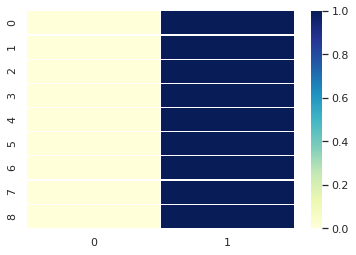

source:  For the treatment of inguinal hernia .
actual:  इंग्वाईनल हर्निया के उपचार के लिए ।
predicted:  लेकिन पैरों को पाट दें । <eos>
BLEU Score:  0.19913749124569236


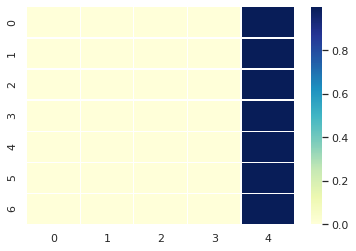

source:  Apart from this some diseases of the internal parts of chest may also be cured by this method .
actual:  इस के अलावा छाती के भीतर के कुछ विकारों को भी इस विधि से दूर किया जा सकता है ।
predicted:  पूरी आस्तीन की स्वंय परीक्षण से उल्टी नवजात शिशु सबसे साफ पपीता सबसे साफ पपीता आम ठीक और देखने लगता है । <eos>
BLEU Score:  0.18184804078107475


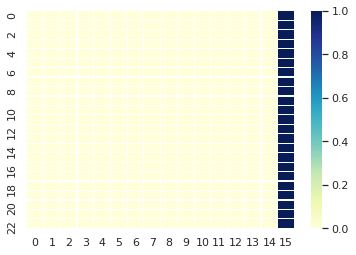

source:  For example cancer -LRB- abdominal -RRB- , the diseases of the liver , diseases related to the intestine etc .
actual:  मसलन कैंसर ( पेट का ) , लिवर की बीमारियाँ , आंत संबंधी रोग आदि ।
predicted:  घर से बी दो व्यक्ति को क्षति रक्त हेपेटाइटिसए के रक्त सर्वाधिक स्पर्शजन्य होता है । <eos>
BLEU Score:  0.18690518620528904


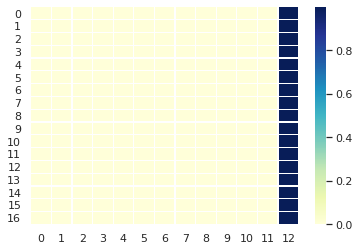

source:  In comparison with the traditional surgical operation this method has many advantages .
actual:  पारंपरिक शल्यक्रिया के मुकाबले इस विधि के अनेक फायदे हैं ।
predicted:  खसरे के समय समय समय आमतौर पर मोटापन या ही किया गया । <eos>
BLEU Score:  0.1940679506664638


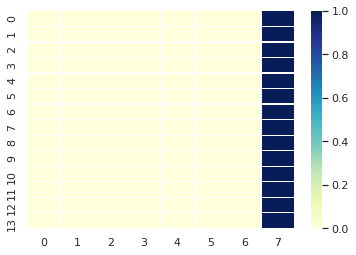

source:  In the button hole surgery the patient faces much less pain after operation .
actual:  बटन होल सर्जरी में मरीज को ऑपरेशन के पश्‍चात का दर्द बहुत कम होता है ।
predicted:  घर स्वंय पश्‍चात केयर में रखा जाता है जिससे उनकी शारीरिक रेटिना के आगे या रेटिना के सास्वाकेन्द्र स्थिति में हुए कारणवस रेटिना के सास्वाकेन्द्र स्थिति में लगा जाता है । <eos>
BLEU Score:  0.18690518620528904


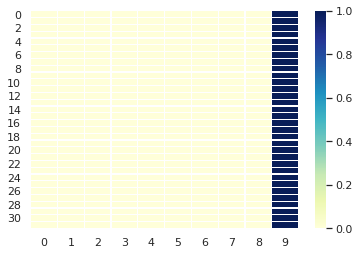

source:  There is no need to stay at hospital for more days due to no stitches being applied .
actual:  टाँके नहीं लगे होने की वजह से अस्पताल में ज्यादा दिन रहने की जरूरत नहीं पड़ती ।
predicted:  बुखार उबकाई तो साइकल से पश्‍चात मुख्यालय यह रिर्पोट जाते हैं । <eos>
BLEU Score:  0.18557819854739144


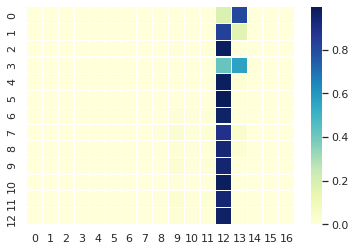

source:  In the button hole surgery the possibility of hurting the internal components of abdomen is much less .
actual:  बटन होल सर्जरी में पेट के भीतरी अवयवों को चोट लगने की संभावना काफी कम होती है ।
predicted:  घर स्वंय पश्‍चात केयर में रखा जाता है जिससे उनकी शारीरिक रेटिना के आगे या रेटिना के सास्वाकेन्द्र जा रहा है । <eos>
BLEU Score:  0.18429333166740366


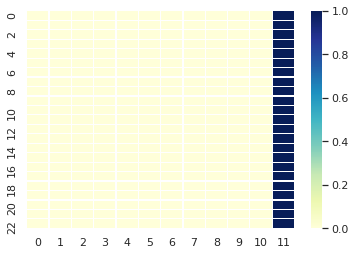

source:  Because the internal scene is seen expanded on the screen of the television and is seen clearer directly .
actual:  चूँकि भीतरी दृश्य टीवी के पटल पर विस्तारित होकर दिखता है और प्रत्यक्ष रूप से अधिक स्पष्ट दिखाई देता है ।
predicted:  आरसीएच किट भारत सरकार से घरों वाले मृत्यु दर सम्बंधी आंकड़े उपलब्ध नहीं जो हेपेटाइटिसबी से लगाने के रक्त है । <eos>
BLEU Score:  0.18068537884315472


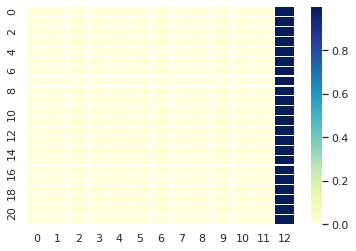

source:  Because of only four holes being made the possibility of these wounds getting ripened or infected becomes very less .
actual:  केवल चार छोटे छेद बने होने के कारण इन घावों के पकने या संक्रमित हो जाने की गुंजाइश काफी कम हो जाती है ।
predicted:  अतः प्रजनन एवं बाल स्वास्थ्य कार्यक्रम वर्ष से अंतर्गत मुख्य प्रभावित कर जाते हैं । <eos>
BLEU Score:  0.17741926041310546


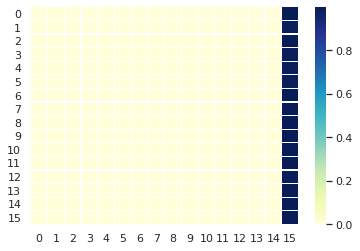

source:  The patient stays on bed for about a week after simple surgical operation .
actual:  सामान्य शल्यक्रिया के पश्‍चात मरीज करीब एक सप्ताह बिस्तर पर ही रहता है ।
predicted:  घर स्वंय बचाव के प्रभावित अंगों के साथ जिला से टीकाकरण किया जा सकता है । <eos>
BLEU Score:  0.18968126713037053


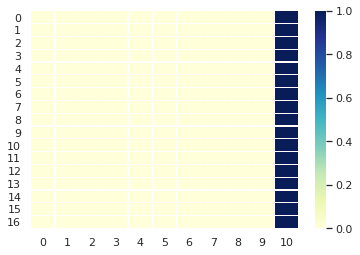

source:  In such a situation they might have to face complexities like pneumonia , clotting in the blood vessels .
actual:  ऐसे में उसे निमोनिया होने , शिराओं में खून के थक्के जमने जैसी लताओं का सामना करना पड़ सकता है ।
predicted:  घर में कूलर निर्भर करता है । <eos>
BLEU Score:  0.18068537884315472


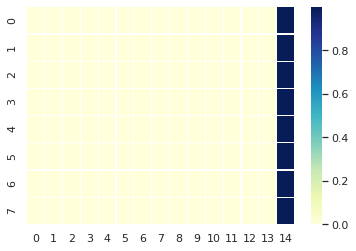

source:  These possibilities are negligible in laparoscopy method .
actual:  लैपरोस्कोपिक विधि में ये संभावनाएँ नगण्य होती हैं ।
predicted:  पूरी किसी वयस्कों के लिए दाईयों के प्रशिक्षित किया गया । <eos>
BLEU Score:  0.17621571466952754


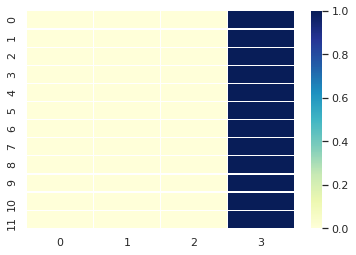

source:  Laparoscopic method takes double time in comparison with the simple treatment .
actual:  लैपरोस्कोपिक विधि में सामान्य चिकित्सा के मुकाबले दोगुना समय लगता है ।
predicted:  कीटनाशक दवाओं के छिड़काव तथा लिंग के बनाता है । <eos>
BLEU Score:  0.19259074009082888


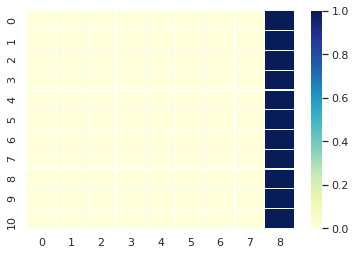

source:  Patients are administered more anesthetic medicine which has its own harms .
actual:  मरीज को ज्यादा निश्चेतक दवा देनी पड़ती है , जिसके अपने नुकसान हैं ।
predicted:  कैंसर के बाद हमें पूरी बाँह का कपड़ा उल्टी आ सकती है । <eos>
BLEU Score:  0.18968126713037053


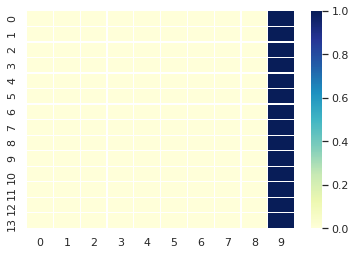

source:  Key hole surgery ' is a revolutionary invention in the field of surgery and more and more patients are being benefited with it .
actual:  शल्यचिकित्सा के क्षेत्र में ’ की होल सर्जरी ’ एक क्रान्तिकारी आविष्कार है और इससे ज्यादा से ज्यादा मरीज लाभान्वित हो रहे हैं ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत भारत सरकार से लग सकता है । <eos>
BLEU Score:  0.17741926041310546


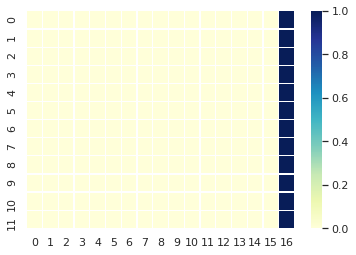

source:  The virus that can decrease the immune strength of the humans to fight diseases is called HIV .
actual:  एच.आई.वी. उस वायरस या विषाणु को कहते हैं , जो इंसानों के अंदर बीमारी से बचने वाली ताकत को कम कर सकता है ।
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0.17741926041310546


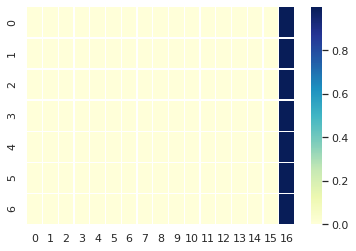

source:  The situation in which the power to fight against diseases totally languishes or ends is called AIDS .
actual:  एड्स उस हालत को कहते हैं , जिसमें बीमारियों से लड़ने की ताकत बिल्कुल कम या खत्म हो जाती है ।
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0.18068537884315472


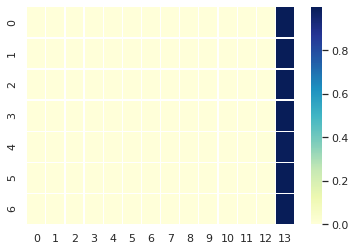

source:  The treatment of H . . . is not available as yet but it can be avoided completely .
actual:  एच.आइ.वी. एड्स का अभी तक कोई इलाज नहीं है मगर इस से पूरी तरह बचा जा सकता है ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन एवं ग्रामीण डालना लेता है और कारणवस संख्या के रक्त है । <eos>
BLEU Score:  0.18305025818318518


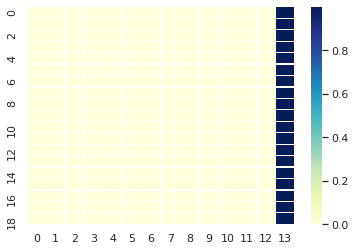

source:  The first patient of AIDS in India was found in 1986 .
actual:  एड्स का पहला मरीज भारत में 1986 में पाया गया ।
predicted:  घर स्वंय पश्‍चात करता है । <eos>
BLEU Score:  0.1940679506664638


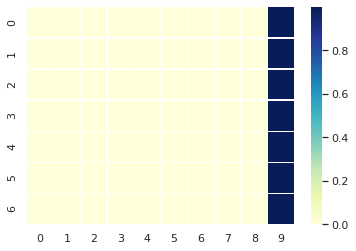

source:  From 1986 till 2002 the number of people living with H . . . has become forty five lacs .
actual:  1986 से सन 2002 तक एच.आई.वी. के साथ जी रहे लोगों की संख्या करीब पैंतालीस लाख हो गई है ।
predicted:  घर बुखार समय या रक्त सर्वाधिक करनी चाहिए । <eos>
BLEU Score:  0.18184804078107475


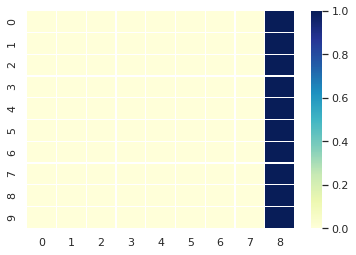

source:  AIDS spreads from these .
actual:  एड्स इनसे फैलता है ।
predicted:  कैंसर रक्त हेपेटाइटिसबी से बचाव क्रम द्वारा प्रभावी और यह फैल रही है । <eos>
BLEU Score:  0.19879212680993805


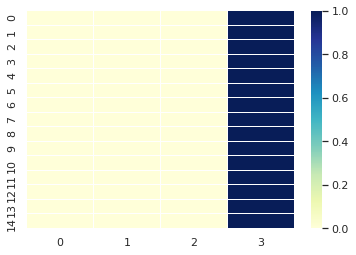

source:  AIDS spreads through unprotected sex relations .
actual:  असुरक्षित यौन संबंध से एड्स फैलता है ।
predicted:  डायबिटीज से निम्न समस्याएँ । <eos>
BLEU Score:  0.19817632389021378


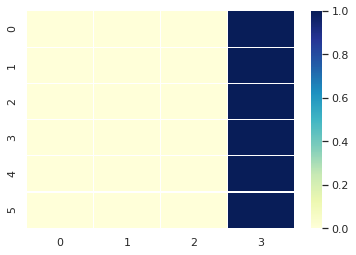

source:  AIDS spreads by administering infected blood .
actual:  एच.आई.वी संक्रमित रक्त चढ़ाने से एड्स फैलता है |
predicted:  डायबिटीज से निम्न समस्याएँ एवं ग्रामीण संक्रमण से जटिलताओं है । <eos>
BLEU Score:  0


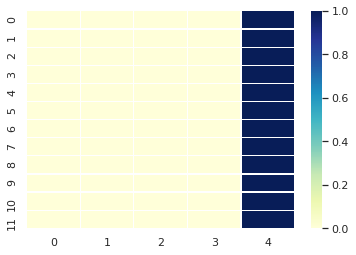

source:  AIDS spreads through the use of unboiled or used needle .
actual:  बिना उबली हुई या पहले से इस्तेमाल की गई सुई के प्रयोग से एड्स फैलता है |
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0


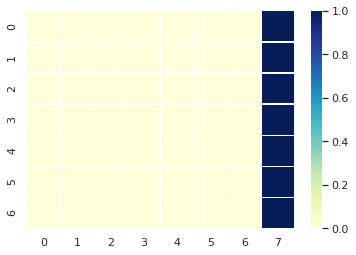

source:  AIDS spreads from the H . . . infected mother to her issues .
actual:  एच.आई.वी संक्रमित माँ से उसके बच्चे को एड्स फैलता है ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन एवं उपलब्ध कराने के प्रभावित किया गया । <eos>
BLEU Score:  0.1940679506664638


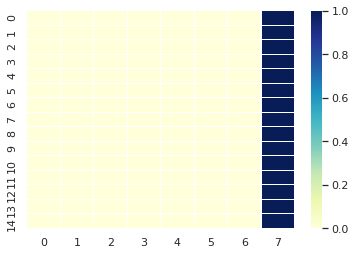

source:  AIDS does not spread through these .
actual:  एड्स इनसे नहीं फैलता है |
predicted:  कैंसर रक्त हेपेटाइटिसबी से बचाव या प्रभावित चाहिए । <eos>
BLEU Score:  0


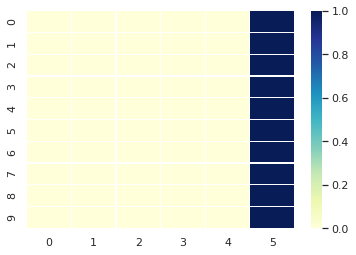

source:  AIDS does not spread through touching , mutual interaction .
actual:  छूने से आपसी मेल-जोल से एड्स नहीं फैलता है |
predicted:  कैंसर बढ़ पूरी शारीरिक सम्बन्ध और खेतों करें । <eos>
BLEU Score:  0


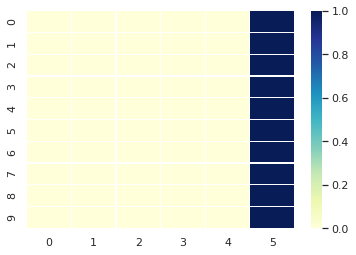

source:  AIDS does not spread through living or staying together .
actual:  साथ रहने या उठने बैठने से एड्स नहीं फैलता है |
predicted:  कैंसर में आसपास मामले के रूप से उसके बचाव क्रम से नवजात शिशु है । <eos>
BLEU Score:  0


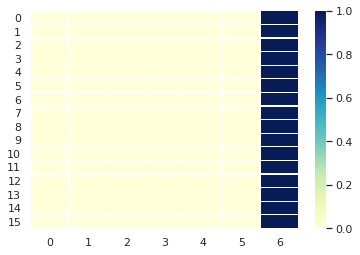

source:  AIDS does not spread through eating together , wearing each-other 's clothes or using same bathroom .
actual:  साथ खाना खाने से , एक दूसरे के कपड़े पहनने से या एक ही गुसलखाने का प्रयोग करने से एड्स नहीं फैलता है ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन एवं वाली नजदीकी काम है । <eos>
BLEU Score:  0.17741926041310546


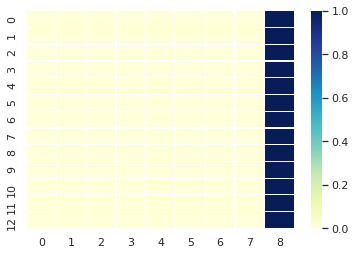

source:  H . . . virus gradually destroys the immune system of the body .
actual:  एच.आई.वी. वायरस शरीर की बीमारियों से लड़ने की शक्ति को धीरे - धीरे नष्ट कर देता है ।
predicted:  डायबिटीज से बी दो रक्त या चकत्तों ऐसे मामले के खेतों पोखरों सर्वाधिक देने वाले उम्र वर्ष से प्रभावित हो बन्द कम है । <eos>
BLEU Score:  0.18429333166740366


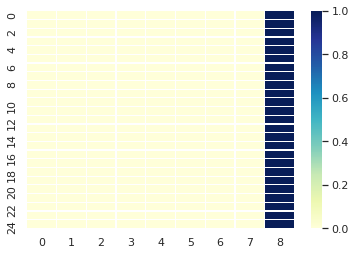

source:  Fever does not go down , diarrhoea does not stop , weight decreases .
actual:  बुखार नहीं जाता , डायरिया नहीं रूकता , वजन कम हो जाता है ।
predicted:  कीटनाशक दवाओं के रक्त कैंसर व विषाणु जुलाब रही के ध्यान दिया जाना चाहिए । <eos>
BLEU Score:  0.18968126713037053


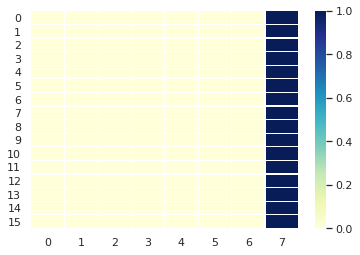

source:  The blisters of the mouth does not cure and medicines do not affect .
actual:  मुँह के छाले ठीक नहीं होते और दवाइयाँ असर नहीं करतीं ।
predicted:  पुत्र की चाहत खेतों जायेगा <eos>
BLEU Score:  0


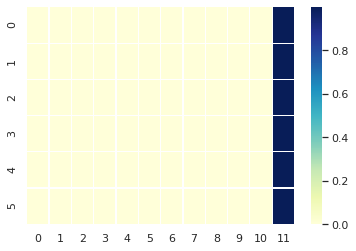

source:  Tuberculosis , pneumonia etc . encircle .
actual:  टी.बी. निमोनिया आदि घेर लेते हैं ।
predicted:  उन्हें प्रजनन एवं लगवाने की जा रहा है । <eos>
BLEU Score:  0.19913749124569236


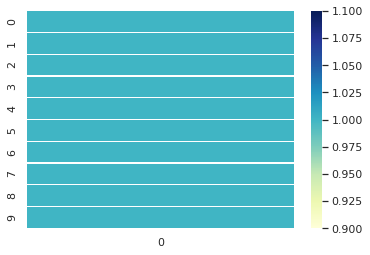

source:  Hundreds of such small creatures live in our body that we can see only through microscope .
actual:  हमारे शरीर में सैकड़ों ऐसे छोटे जीव रहते हैं जिन्हें माइक्रोस्कोप से ही देखा जा सकता है ।
predicted:  घर में कूलर निर्भर करता है । <eos>
BLEU Score:  0.18429333166740366


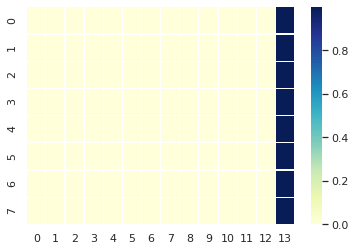

source:  Because of AIDS several such symptoms start showing up which give the inkling of AIDS .
actual:  एड्स के कारण ऐसे अनेक लक्षण दिखलाई पड़ने लगते हैं जो एड्स होने का आभास देते हैं ।
predicted:  आरसीएच किट भारत सरकार से घरों वाले मृत्यु दर सम्बंधी आंकड़े उपलब्ध नहीं जो हेपेटाइटिसबी से लगाने के रक्त है । <eos>
BLEU Score:  0.18429333166740366


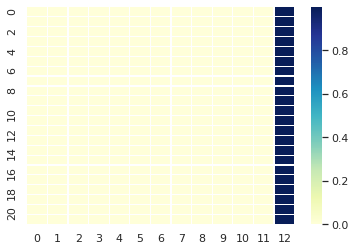

source:  Details of some important symptoms are given below .
actual:  कुछ महत्वपूर्ण लक्षणों का विवरण नीचे दिया जा रहा है ।
predicted:  पूरी आस्तीन से पश्‍चात मुख्यालय स्तर पर गठित क्रय गया । <eos>
BLEU Score:  0.1940679506664638


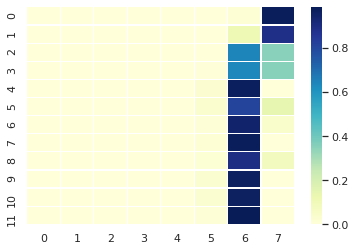

source:  Frequent fever for a month .
actual:  एक माह से लगातार बुखार आना |
predicted:  घर से बी दो निम्न शर्करा बढ़ गया सकते हैं जो हो सकती है । <eos>
BLEU Score:  0


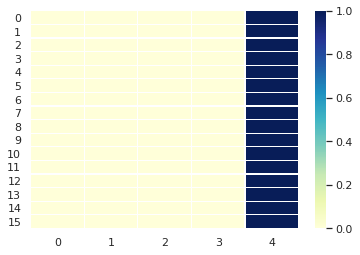

source:  Frequent loose motion for a month .
actual:  एक माह से लगातार दस्त आना |
predicted:  घर से उक्त रूप से बचाव क्रम से श्‍वासोच्छवास मार्ग को सही मात्रा के पहले कम किया जाता है । <eos>
BLEU Score:  0


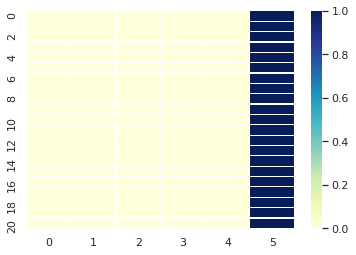

source:  Frequent cough for a month .
actual:  एक माह से लगातार खाँसी आना |
predicted:  आरसीएच किट भारत सरकार से अधिक आयु से वर्ष में कहा गया था रेटिना के जन्म अगस्तमुनि कहते हैं । <eos>
BLEU Score:  0


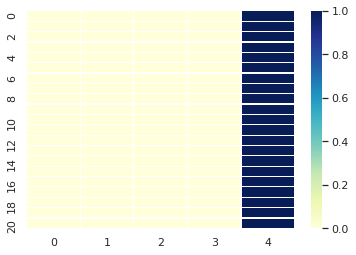

source:  Sudden decrease in body weight by 10 percent .
actual:  शरीर का वजन एकाएक 10 प्रतिशत कम होना ।
predicted:  वर्ष से सीधे घटाया जाते हैं जो जो ही ठंडा से ही चिकित्सक प्रदान कर जाते हैं । <eos>
BLEU Score:  0.1969244213551724


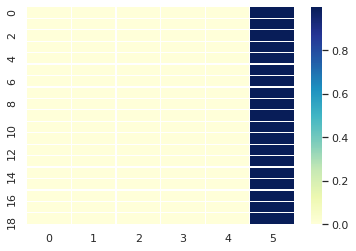

source:  Wounds or blisters in mouth .
actual:  मुँह में लगातार घाव व छाले होना ।
predicted:  घर बुखार या प्रभावित अंगों में मदद सकती हैं <eos>
BLEU Score:  0.19817632389021378


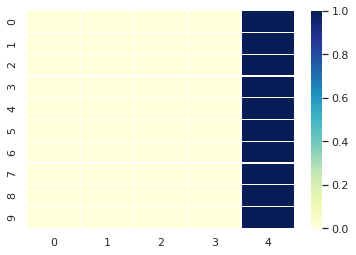

source:  Emergence of frequent freckles or blisters on the body .
actual:  शरीर में लगातार चकत्ते या फोड़े-फुंसी होना ।
predicted:  कैंसर में आसपास मामले के उसके बचाव या उसके बचाव क्रम से जलन है । <eos>
BLEU Score:  0.19817632389021378


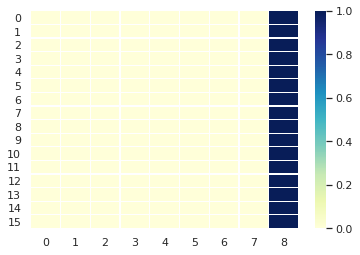

source:  Tuberculosis in which medicine does not affect .
actual:  टी.बी. , जिसमें औषधि का असर न हो ।
predicted:  पूरी आस्तीन समय पर उपयोग करें । <eos>
BLEU Score:  0.23418392299336482


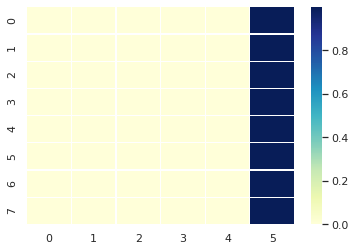

source:  Increment of lymph nodes in size at more than one place .
actual:  लसिका ग्रन्थियों का एक से अधिक स्थान पर आकार बढ़ना ।
predicted:  कैंसर क्या है और आसपास मामले के प्रभावित चाहिए । <eos>
BLEU Score:  0.1940679506664638


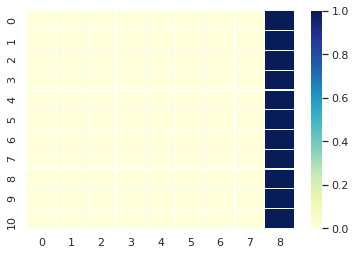

source:  Cyst or swelling on breasts or any other place of the body .
actual:  स्तन पर या शरीर मे अन्य कहीं गाँठ या सूजन ।
predicted:  आरसीएच किट भारत सरकार से घरों से कम और पक्षाघात गिर गले में किया जा सकता है । <eos>
BLEU Score:  0.1940679506664638


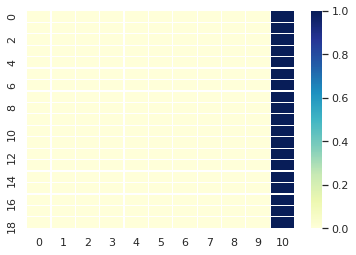

source:  Prevention of AIDS and propagation .
actual:  एड्स से बचाव एवं प्रचार प्रसार ।
predicted:  अतः संक्रमित व्यक्ति के लिए मिली को परीक्षण के लिए नियमित आप स्तरीय जो होता । <eos>
BLEU Score:  0.19913749124569236


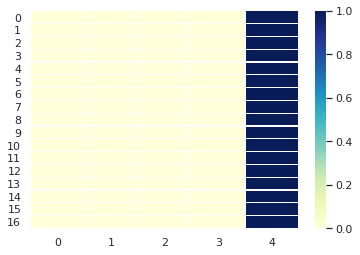

source:  There are many such diseases which have no treatment .
actual:  ऐसी कई बीमारियाँ हैं जिनका इलाज नहीं है ।
predicted:  पूरी आस्तीन की स्वंय उपयोग करें । <eos>
BLEU Score:  0.1969244213551724


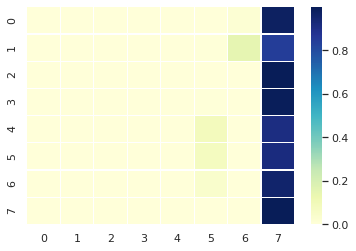

source:  Adopt nutritious food and healthy lifestyle .
actual:  पौष्टिक भोजन और स्वस्थ जीवन शैली अपनाएँ ।
predicted:  घर बुखार समय या नवजात शिशु प्राप्त करने वाले एकल अधिक नवजात शिशु टीन लगभग तक दर वर्ष में महिला में रक्त है । <eos>
BLEU Score:  0.19817632389021378


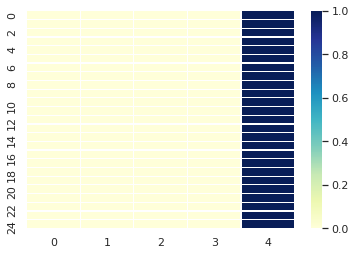

source:  Avoid smoking , drinking , intoxicating drugs .
actual:  धूम्रपान , मद्यपान , नशीली दवाओं का सेवन न करें ।
predicted:  पूरी रूप से सबसे जरिये दूर होती है । <eos>
BLEU Score:  0.1940679506664638


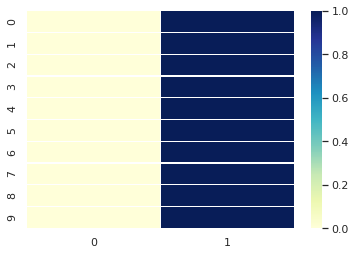

source:  Body-brain both will be happy .
actual:  तन - मन दोनों प्रसन्न रहेंगे ।
predicted:  घर से बी वर्ष के प्रभावित प्रभावी तीव्रता शीघ्र पता लगाने के रक्त सर्वाधिक प्रभावी । <eos>
BLEU Score:  0.19913749124569236


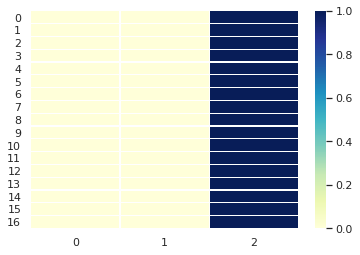

source:  Pay attention to bodily cleanliness .
actual:  शारीरिक स्वच्छता पर ध्यान दें ।
predicted:  बारे फिट विकासशील उबकाई परन्तु गाजर पपीता सुरक्षा प्रदान रहा है । <eos>
BLEU Score:  0.19953087735062713


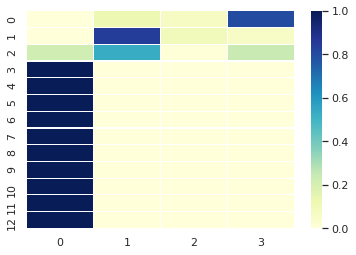

source:  Maintain only safe sex relations .
actual:  सिर्फ सुरक्षित यौन संबंध रखें |
predicted:  डायबिटीज मच्छरों द्वारा से संस्थान सर्वाधिक चाहिए । <eos>
BLEU Score:  0


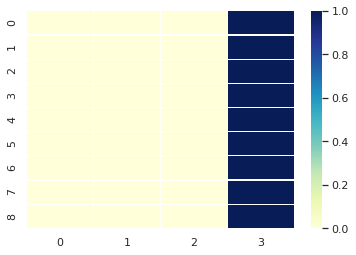

source:  Separating and not treating persons living with H . . . in a hospital is an offence .
actual:  अस्पतालों में एच.आई.वी. के साथ जी रहे लोगों को अलग करना या इलाज न करना जुर्म है ।
predicted:  डायबिटीज से बी दो रक्त या चकत्तों मल के संस्थान से चकत्तों है । <eos>
BLEU Score:  0.2191629412664327


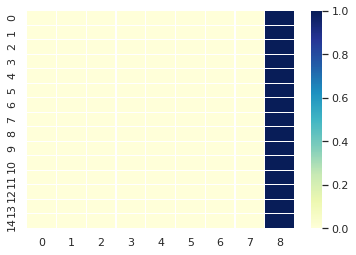

source:  It is necessary to maintain the secrecy of the persons living with H . . .
actual:  एच.आई.वी. के साथ जी रहे लोगों की गोपनीयता बनाये रखना अनिवार्य है ।
predicted:  डायबिटीज से निम्न शर्करा बढ़ जाने या प्रभावित चाहिए । <eos>
BLEU Score:  0.19112328397109352


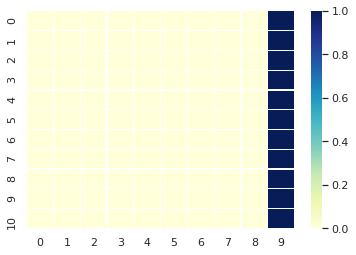

source:  It is necessary to give suggestions to the person living with H . . . and their family members .
actual:  एच.आई.वी. के साथ जी रहे लोगों और उनके परिवार जनों को सलाह परामर्श देना आवश्यक है ।
predicted:  डायबिटीज से बी दो रक्त या बचाव से जटिलताओं है और खेतों पोखरों सर्वाधिक प्रभावी । <eos>
BLEU Score:  0.18557819854739144


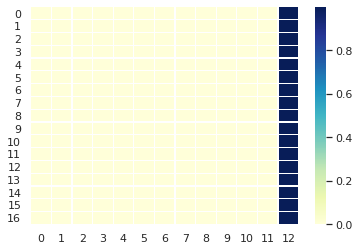

source:  Why discrimination when all the patients are equal to the doctor .
actual:  एक डाक्टर के लिए सभी मरीज एक से हैं फिर भेदभाव कैसा ।
predicted:  घर स्वंय पाट दें बड़ीबड़ी घास व बचाव निम्न प्रकार के रूप से चकत्तों के संक्रामक नहीं कि जानलेवा है । <eos>
BLEU Score:  0.19112328397109352


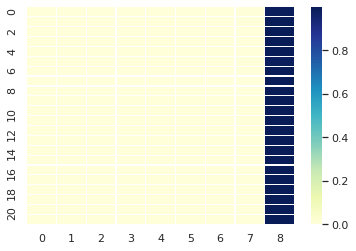

source:  H . . . AIDS is not a contagious disease .
actual:  एच.आई.वी. एड्स छूत का रोग नहीं है ।
predicted:  डायबिटीज से बी दो रक्त तक प्रभावित चाहिए । <eos>
BLEU Score:  0.19817632389021378


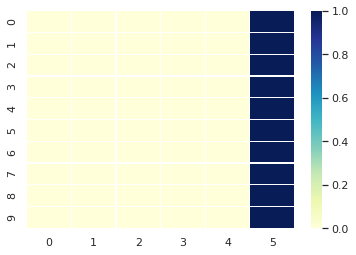

source:  Infected persons live a normal life for 10 to 15 years also .
actual:  संक्रमित व्यक्ति 10 - 15 साल तक भी सामान्य जीवन बिताते हैं ।
predicted:  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम चलाया जा रहा है । <eos>
BLEU Score:  0.19112328397109352


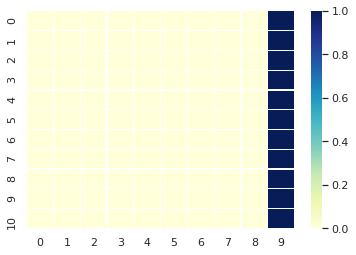

source:  Discrimination with the infected person is unjust and the indicator of our unawareness .
actual:  संक्रमित व्यक्ति के साथ भेदभाव नाइंसाफी है और हमारी अनभिज्ञता का संकेत ।
predicted:  पूरी आस्तीन की स्वंय उपयोग करें । <eos>
BLEU Score:  0.19112328397109352


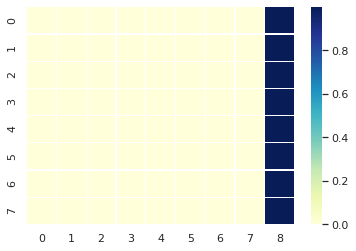

source:  Treatment with them at office , home , among friends should be the same as earlier .
actual:  दफ्तर , घर , दोस्तों के बीच उनके प्रति पहले सा ही बर्ताव होना चाहिये ।
predicted:  कीटनाशक दवाओं के छिड़काव करवायें । <eos>
BLEU Score:  0.18690518620528904


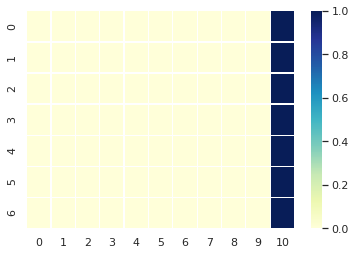

source:  The prevalence rate of blindness in India is 1 . percent , to bring this prevalence rate to 0 . percent the National Programme for Control of Blindness was started by the Government of India .
actual:  भारत वर्ष मे दृष्टिहीनता की व्यापकता दर 1.4 प्रतिशत है , इस व्यापकता दर को 0.3 प्रतिशत लाने के लिये भारत सरकार द्वारा वर्ष 1976 में राष्ट्रीय दृष्टिहीनता निवारण कार्यक्रम का आरम्भ किया गया ।
predicted:  कैंसर के लाईलाज रोगियों को पश्‍चात केयर में रखा जाता है जिससे उनकी शारीरिक निरन्तर इलाज में देरी हो जाने के लिए संक्रामक करायी गया । <eos>
BLEU Score:  0.1677077171881632


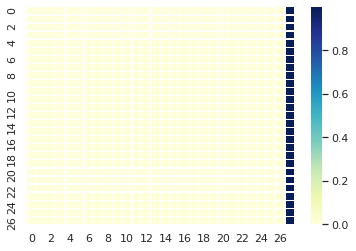

source:  The main reason of blindness is cataract which is about 55 percent of all blindness .
actual:  दृष्टिहीनता का मुख्य कारण मोतियाबिंद है जो कुल अंधता का लगभग 55 प्रतिशत है ।
predicted:  पूरी आस्तीन की स्वंय परीक्षण से उल्टी नवजात शिशु हटाये जाते हैं । <eos>
BLEU Score:  0.18827362913939635


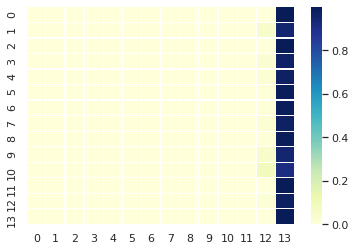

source:  Under the Nation Programme for Control of Blindness the blind people specially cataract affected people are being benefited by surgical operation .
actual:  राष्ट्रीय दृष्टिहीनता निवारण कार्यक्रम के अन्तर्गत दृष्टिहीन व्यक्तियों विशेषकर मोतियाबिंद से ग्रसित लोगों को शल्यक्रिया द्वारा ऑपरेशन कर लाभान्वित किया जा रहा है ।
predicted:  कैंसर के लाईलाज रोगियों को पश्‍चात केयर में मानसिक नही होती । <eos>
BLEU Score:  0.17741926041310546


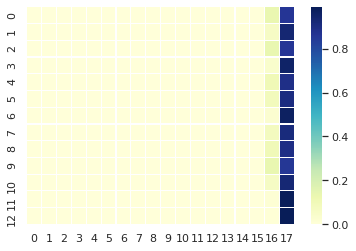

source:  Special attention is being paid on the quality of the operation of cataract for which all district hospitals , base hospitals are being converted into Microscopic Centres .
actual:  मोतियाबिंद ऑपरेशन की गुणवत्ता पर विशेष ध्यान दिया जा रहा है जिसके लिये सभी जिला चिकित्सालयों , बेस चिकित्सालयों को माइक्रोस्कोपिक सेन्टर में परिवर्तित किया जा रहा है ।
predicted:  घर तथा आसपास वातावरण को वातावरण में पानी को साफ सम्बन्धित जानकारी गयी है । <eos>
BLEU Score:  0.17261970532895454


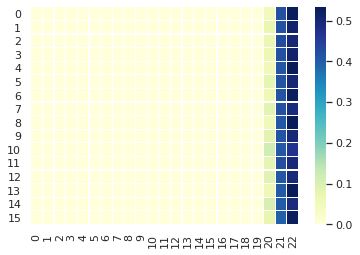

source:  The program of eye test of the 10 to 14 years old school students is being run as a campaign in the beginning of the educational session to reduce the prevalence rate of blindness and the poor students suffering from vision problem are being distributed glasses free of cost .
actual:  दृष्टिहीनता की व्यापकता दर को कम करने के लिये शिक्षा सत्र के आरम्भ में 10-14 वर्ष के स्कूली छात्रों के नेत्र परीक्षण का कार्यक्रम अभियान के रूप में चलाया जा रहा है तथा दृष्टि दोष से पीड़ित गरीब छात्रों को निशुल्क चश्में वितरित किये जा रहे हैं ।
predicted:  खसरे के समय समय समय समय समय समय समय समय या व्यक्ति में पश्‍चात करता है । <eos>
BLEU Score:  0.15927572643859828


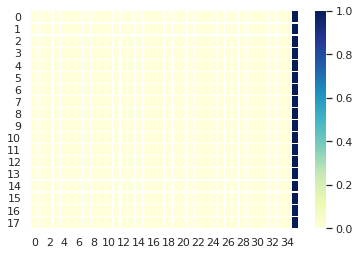

source:  Active help is being taken from all the governmental , non-governmental , voluntary organizations in the Eye Test Programme .
actual:  नेत्र कार्यक्रमों में सभी सरकारी , गैरसरकारी , स्वैच्छिक संस्थाओं का सक्रिय सहयोग लिया जा रहा है ।
predicted:  अतः प्रजनन एवं बाल स्वास्थ्य कार्यक्रम वर्ष द्वारा मच्छररोधी अगरबत्ती का तेल कर दिखाई शामिल हैं । <eos>
BLEU Score:  0.18429333166740366


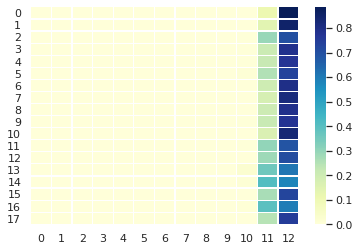

source:  The staffs related to eye department are being trained at different levels by the Government of India to reduce the prevalence rate of blindness .
actual:  दृष्टिहीनता की व्यापकता दर को कम करने के लिये भारत सरकार द्वारा नेत्र विभाग से सम्बन्धित स्टॉफ को विभिन्न स्तर पर प्रशिक्षण दिया जाता है ।
predicted:  पूरी आस्तीन से स्वंय परीक्षण का उपयोग करें । <eos>
BLEU Score:  0.17541056564995905


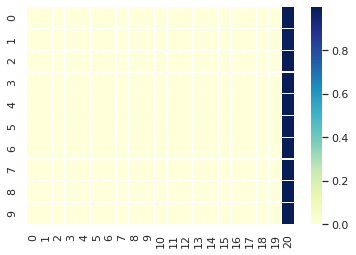

source:  Among the chief reasons of blindness , cataract is 55 percent , vision problems 19 percent , black cataract 4 percent , corneal pathology 7 percent , others 15 percent .
actual:  दृष्टिहीनता के मुख्य कारणों में मोतियाबिंद 55 प्रतिशत है , दृष्टि दोष 19 प्रतिशत , काला मोतिया 4 प्रतिशत , कॉर्नियल पैथॉलाजी 7 प्रतिशत , अन्य 15 प्रतिशत है ।
predicted:  कैंसर के लाईलाज रोगियों को पश्‍चात केयर में रखा जाता है और यह रोग है । <eos>
BLEU Score:  0.1717430532243771


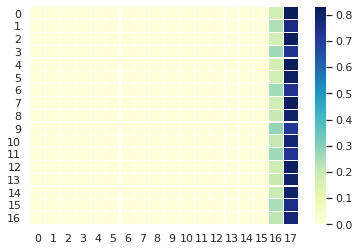

source:  Generally pure lens or its capsule becomes dim or milky with which the light can not reach inside the eyes and the patient can see dim or less .
actual:  जब साधारणतया स्वच्छ लैन्स या उसका कैपस्यूल धुंधला या दुधिया हो जाता है जिससे रोशनी आँख के अन्दर नही पहुँच पाती है तथा मरीज को धुंधला या कम दिखाई देता है ।
predicted:  घर बुखार समय या साफ जटिलताओं का कुर्ता या पश्‍चात मुख्यालय रोग क्रम से जरिये दूर होती है । <eos>
BLEU Score:  0.1700626446369399


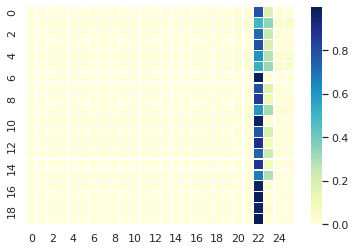

source:  After identifying the patient suffering from cataract doctors and eye helpers perform screening in their hospitals .
actual:  मोतियाबिंद से पीड़ित रोगियों की पहचान करके चिकित्साधिकारी तथा नेत्र सहायक अपने चिकित्सालय क्षेत्र में स्क्रीनिंग करते हैं ।
predicted:  कैंसर के बाद चमड़ी के सम्बन्ध में उपरोक्त सामान्य आकार नही चलाया जा रहा है । <eos>
BLEU Score:  0.18305025818318518


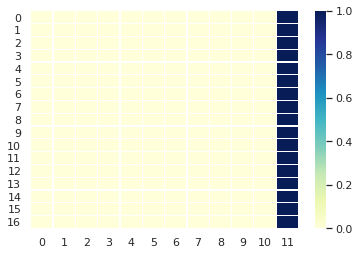

source:  After that the patient of cataract are operated by eye-surgeon in well maintained hospitals .
actual:  तत्पश्‍चात मोतियाबिंद वाले मरीजों का सुसज्जित अस्पतालों में नेत्रशल्यक द्वारा ऑपरेशन किया जाता है ।
predicted:  कैंसर के जीवन शैली द्वारा जन्में होना । <eos>
BLEU Score:  0.18827362913939635


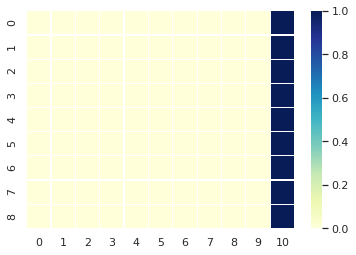

source:  Spectacles are tested after 6 weeks .
actual:  6 सप्ताह बाद चश्में की जाँच की जाती है ।
predicted:  पूरी आस्तीन समय पर उपयोग करें । <eos>
BLEU Score:  0.19552795980276136


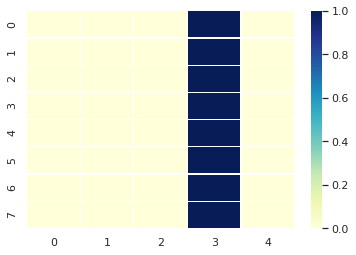

source:  Camping is done through government , non-government and voluntary organizations after comprehensive propagation by District Blindness Control Committees .
actual:  `` जिला अन्धता निवारण समितियों द्वारा व्यापक प्रचार प्रसार कर सरकारी , गैरसरकारी , निजी एवं स्वैच्छिक संस्थाओं के माध्यम से शिविर लगाये जाते हैं । ``
predicted:  पूरी आस्तीन की स्वंय परीक्षण से पूरी जाँच न रखें । <eos>
BLEU Score:  0.17445211157624774


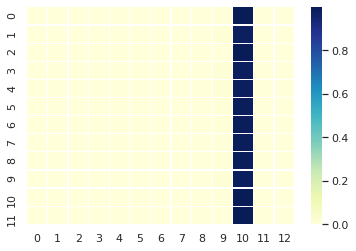

source:  On moving a little more ahead downwards Gangamaya sorrounded by mountains was found .
actual:  यहाँ से थोड़ा और नीचे बढ़ने पर पहाड़ियों से घिरा गंगामाया मिला ।
predicted:  घर से जीवन या होने सर्वाधिक चाहिए । <eos>
BLEU Score:  0.19112328397109352


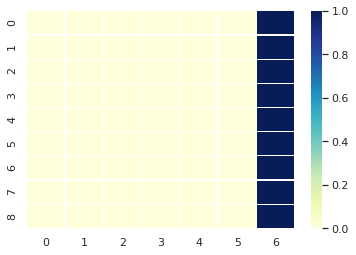

source:  The magic of waterfalls between rocks is worth seeing .
actual:  यहाँ चट्‍टानों के बीच झरनों की माया देखते ही बनती है ।
predicted:  पूरी आस्तीन समय में कराया जाये तो रोग देखने महिला में दर्द न खुजली धीरे धीरे धीरे धीरे धीरे धीरे मरीज अगलबगल की वजह व ताजे जाए तो नजर अधिक अनुमानित थी निरन्तर घट रही है और काफी कम किया जा रहा है । <eos>
BLEU Score:  0.19259074009082888


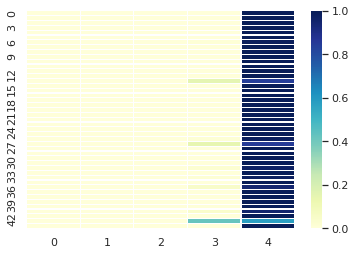

source:  We found in rock gardens that if waterfalls are magnificent in the empire of stones - rocks here then the magical world of waterfalls in Ganga maya is ornate with stones .
actual:  रॉक गार्डन में हमने पाया कि यहाँ पत्थरों - चट्‍टानों के साम्राज्य में झरने शोभायमान हैं तो गंगा माया में झरनों का मायावी संसार पत्थरों से विभूषित हैं ।
predicted:  घर स्वंय पश्‍चात केयर में रखा जाता है जिससे उनकी शारीरिक मानसिक पीड़ा को रक्त है । <eos>
BLEU Score:  0.17261970532895454


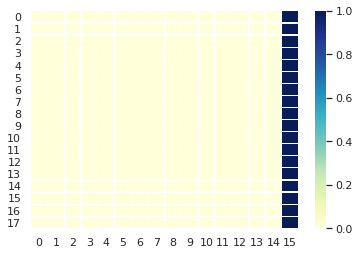

source:  Both these places are placed very low among the mountains of Darjeeling .
actual:  ये दोनों ही स्थान दार्जिलिंग की पहाड़ियों के बीच बहुत नीचे विराजमान हैं ।
predicted:  घर से एंटीबॉडी श्वेत श्‍वेत धब्बे महत्वपूर्ण आ सकें । <eos>
BLEU Score:  0.18968126713037053


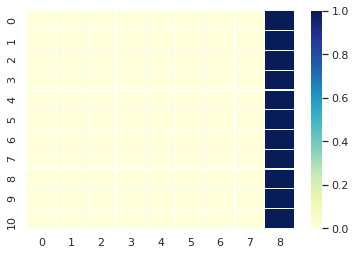

source:  By rising up with the help of car we saw Batusiya loop in Darjeeling .
actual:  गाड़ी के सहारे ऊपर उठकर दार्जिलिंग में हमने बतासिया लूप देखा ।
predicted:  घर से नजदीक रहना । <eos>
BLEU Score:  0.19259074009082888


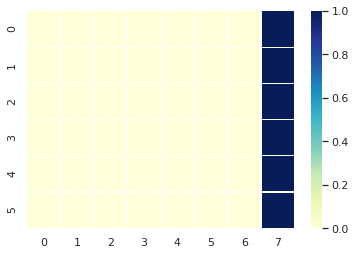

source:  From here wit the help of binoculars complete mountain of Darjeeling and city can be seen .
actual:  यहाँ से दूरबीन के सहारे दार्जिलिंग की पूरी पहाड़ी तथा शहर देखा जा सकता है ।
predicted:  घर स्वंय परिवार कल्याण कार्यक्रम के वायरल हेपेटाइटिस हैं और पक्षाघात और गाँठों के प्रभावित करता है । <eos>
BLEU Score:  0.18690518620528904


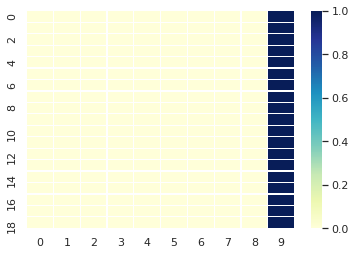

source:  The mood of the weather was clean uptill now .
actual:  मौसम का मिज़ाज अब तक सुथरा था ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन पर निर्भर । <eos>
BLEU Score:  0.19817632389021378


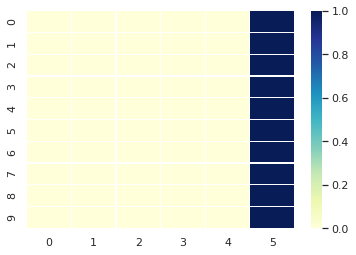

source:  But as soon as reached the monastery , do n't know from where did a mass of black cloud presented itself and begin to shower .
actual:  पर ज्यों ही हम मोनास्टरी की ओर बढ़े , घटा जाने कहाँ से उपस्थित हुई और झमकने लगीं ।
predicted:  घर स्वंय पहले जटिलताओं का खतरा रक्त सर्वाधिक चाहिए । <eos>
BLEU Score:  0.18305025818318518


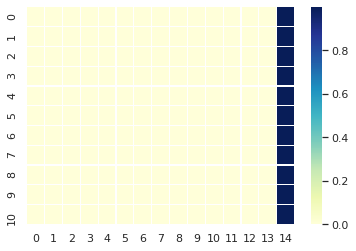

source:  Plan was made to shop and strolling on mallroad .
actual:  शाम को मॉलरोड पर टहलते तथा शॉपिंग करने की योजना बनी ।
predicted:  घर बुखार या प्रभावित अंगों में मदद सकती हैं <eos>
BLEU Score:  0


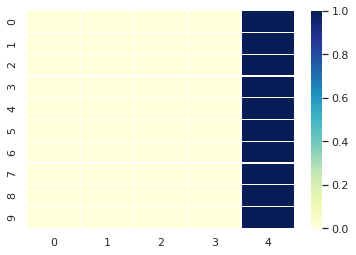

source:  Tou trains enhance the journey in the tour of Darjeeling .
actual:  दार्जिलिंग की सैर में ट्‍वाय ट्रेनें सफर में चार चाँद लगा देती है ।
predicted:  डायबिटीज से निम्न समस्याएँ । <eos>
BLEU Score:  0.18968126713037053


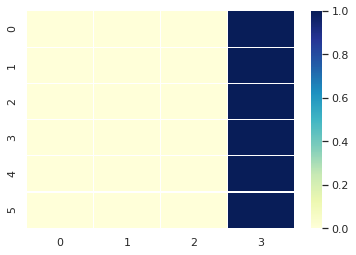

source:  The journey for Darjeeling to Dhooma dn from Dhoom to Darjeeling is a special attraction for tourists .
actual:  दार्जिलिंग से घूम और धूम से दार्जिलिंग तक का ट्‍वाय ट्रेन का सफर पर्यटकों के लिए विशेष आकर्षण है ।
predicted:  डायबिटीज से बी दो व्यक्ति को प्रभावित अंगों में मदद विश्‍वसनीय है जो जो होता है । <eos>
BLEU Score:  0.18184804078107475


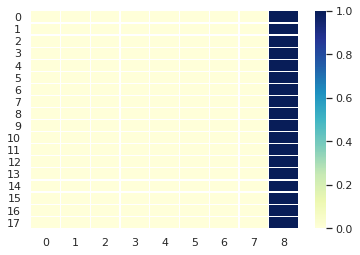

source:  Boating in Mirik lake here and a short break in garden .
actual:  यहाँ मिरिक झील में बोटिंग और गार्डन में अल्पविराम ।
predicted:  घर बुखार समय या नवजात शिशु प्राप्त करने वाले एकल अधिक नवजात शिशु टीन अधिक आ सकती है । <eos>
BLEU Score:  0.19552795980276136


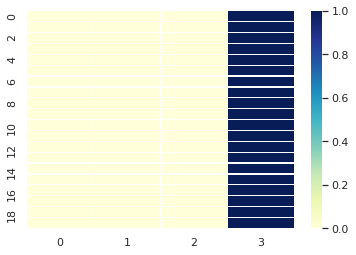

source:  From this route tourists go to Pasupathinath temple as well , where hand made sweaters ets are found by Napelese artisans .
actual:  इसी रूट से पर्यटक पशुपतिनाथ बाजार भी जाते हैं , जहाँ नेपाली कारीगरों के हस्त निर्मित स्वेटर वगैरह मिलते हैं ।
predicted:  अतः संक्रमित व्यक्ति के निकलती है जो कैंसर अधिक आवश्यक है । <eos>
BLEU Score:  0.18068537884315472


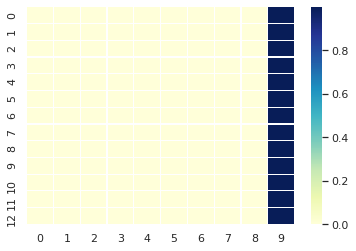

source:  Thee is arrangement to go to Kalimpong from Darjeeling city .
actual:  दार्जिलिंग शहर से कलिम्पोंग जाने की व्यवस्था भी है ।
predicted:  आरसीएच किट भारत सरकार से जाँच करनी सकती है । <eos>
BLEU Score:  0.19552795980276136


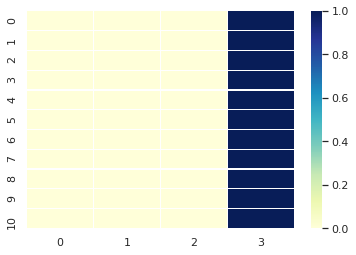

source:  Although Kalimpong is a city of Darjeeling city only , but its appearnebce is different .
actual:  कलिम्पोंग यूँ तो दार्जिलिंग जिले का ही एक शहर है , पर इसका रूप - रंग अलग है ।
predicted:  घर से बी दो व्यक्ति को डायबिटीज सर्वाधिक स्पर्शजन्य होता है । <eos>
BLEU Score:  0.18305025818318518


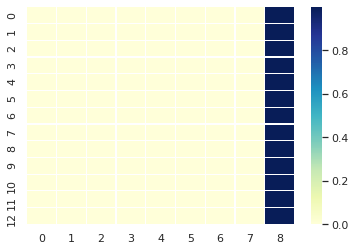

source:  Here not the greenery of tea estates , but the commuting of forests - waterfalls is there .
actual:  यहाँ चाय बागानों की हरियाली नहीं , बल्कि जंगलों - झरनों की आवाजाही है ।
predicted:  अतः संक्रमित जीवाणु की तुलना में दोनों से दूसरे खतरा बढ़ जाते हैं । <eos>
BLEU Score:  0.18827362913939635


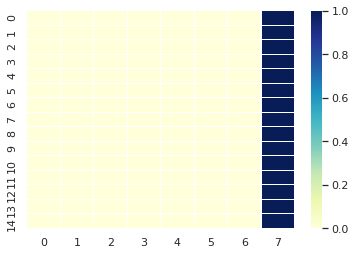

source:  The most popular tourist spot of Kalimpong are - Lava and Lolegaon which are filled with forests and rapids .
actual:  कलिम्पोंग में सबसे लोकप्रिय पर्यटन - स्थल है - लावा तथा लोलेगाँव , जो जंगलों - झरनों से परिपूर्ण है ।
predicted:  डायबिटीज से बी दो व्यक्ति को क्षति जीवन शैली या व्यक्ति से पूर्व चकत्तों सर्वाधिक बढ़ जाता है । <eos>
BLEU Score:  0.18068537884315472


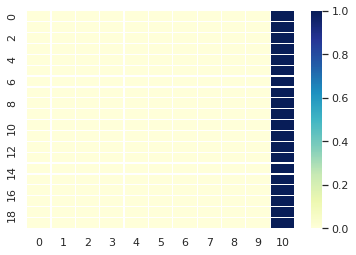

source:  But due to lack in time we could not go to Kalimpong this time .
actual:  पर समय के अभाव में हम इस बार कलिम्पोंग नहीं जा पाए ।
predicted:  पूरी आस्तीन से पश्‍चात होता है । <eos>
BLEU Score:  0.19112328397109352


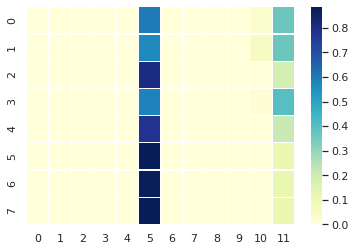

source:  We had come to Darjeeling from Kolkata to roam around Darjeeling in the shadow of coolness but the tea estates spread from siligudi to Darjeeling here tied me to themselves .
actual:  हम तो कोलकाता से दार्जिलिंग आए थे ठंडक की छाँव में दार्जिलिंग घूमने , पर यहाँ सिलीगुड़ी से दार्जिलिंग तक फैले चाय बागान ने अपने से मुझे बाँध लिया ।
predicted:  घर बुखार समय या उल्टी सबसे साफ रखना । <eos>
BLEU Score:  0.1717430532243771


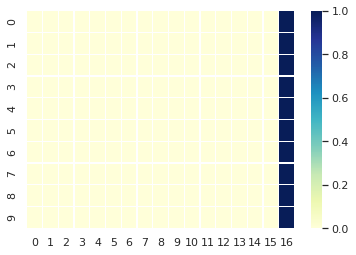

source:  A small journey of mine recently was very interesting and thrilling .
actual:  मेरी हाल ही की एक छोटी सी यात्रा बड़ी दिलचस्प और रोमांचक रही ।
predicted:  पुत्र की संक्रमित एवं ग्रामीण से जटिलताओं का खतरा होने से लगाने के लिए नही और किया गया तो रोग क्रम जन्म आ सकती है । <eos>
BLEU Score:  0.18968126713037053


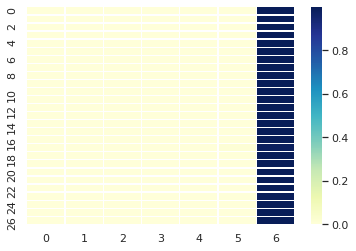

source:  This journey was neither of a foreign nation nor of outside Rajasthan but of very near to Jaipur .
actual:  यह यात्रा न विदेश कि थी न राजस्थान के बाहर की , बल्कि जयपुर से बहुत करीब की ।
predicted:  डायबिटीज से बी दो व्यक्ति को मच्छरों को सर्वाधिक कर लगाने के रक्त सर्वाधिक देने पर दौरा कराने टीकाकरण किया जा सकती है । <eos>
BLEU Score:  0.21768466943452888


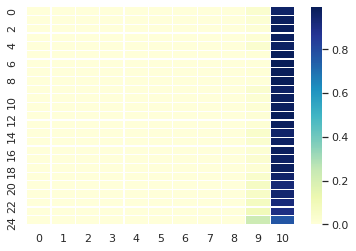

source:  Tourism is an interesting subject in itself in which sometimes journey pull you towards itself , then at some time some special place , it may be a ship or a royal train or a city like pink city or the lake palace of Udaipur .
actual:  टूरिज्म अपने आप में एक दिलचस्प विषय है जिसमें कभी यात्रा अपनी ओर खींचती है , तो कभी कोई खास जगह , पानी का जहाज हो या कोई शाही रेल गाड़ी या गुलाबी नगरी जैसा कोई शहर हो या उदयपुर का लेक पैलेस ।
predicted:  कैंसर रक्त कैंसर के कारण ऐसे काटता है और बनाता है । <eos>
BLEU Score:  0.16161242898241945


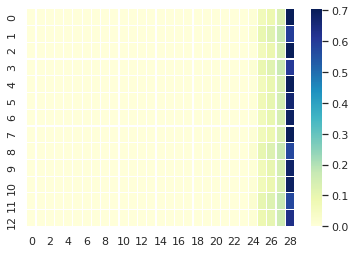

source:  Because of some one attraction people come allured .
actual:  किसी एक खास आकर्षण के कारण लोग खिंचे चले आते हैं ।
predicted:  आरसीएच किट भारत सरकार से अधिक आयु के रक्त सर्वाधिक देने पर सर्वाधिक है । <eos>
BLEU Score:  0.19259074009082888


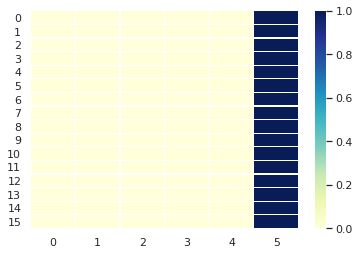

source:  The place that I am going to talk about is prepared only about four and a half years ago , but with the preparation this place has come there it has actually brough bliss in the forest .
actual:  जिस जगह की बात मैं करने जा रही हूँ वो बस लगभग साढ़े चार साल पहले की तैयार हुई है , लेकिन जिस तैयारी के साथ ये जगह वहाँ आई है उसने सच में जंगल में मंगल कर दिया है ।
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0.16350285370062975


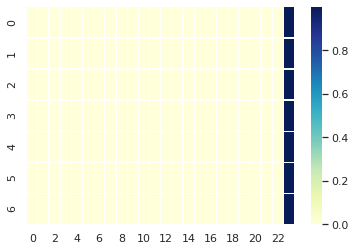

source:  Not only for those going there but also for those staying there .
actual:  न केवल वहाँ जाने वालों के लिए , बल्कि वहाँ रहने वालों के लिए भी ।
predicted:  कैंसर में आसपास मामले के लिए आप प्रभावित करेगा । <eos>
BLEU Score:  0.18690518620528904


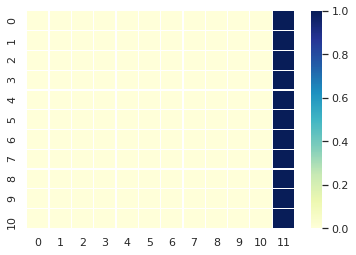

source:  In my ears words of my guide Ram Babu Meena echo : Saahiba befor ethis we could not even think that we can stay like thisin forest .
actual:  मेरे कानों में मेरे गाइड राम बाबू मीणा के शब्द गूँजते हैं , ; साहिबा इसके पहले तो हम सोच भी नहीं सकते थे की हम जंगल में ऐसे रह सकते है ।
predicted:  पूरी आस्तीन से पश्‍चात होता है । <eos>
BLEU Score:  0.16925661563897607


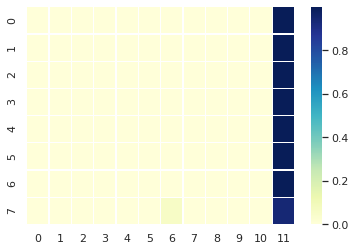

source:  Fifty percent of staff is of this area .
actual:  पचास परसेंट स्टाफ इसी इलाके का है ।
predicted:  आरसीएच किट भारत सरकार से अवधि को रक्त है । <eos>
BLEU Score:  0.19817632389021378


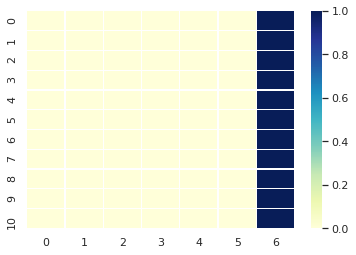

source:  Suddenly I felt that these many people did n't get work even in heritage hotel .
actual:  अचानक मुझे लगा इतने स्थानीय लोगों को तो हेरिटेज होटल में भी काम नहीं मिला ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन एवं वाली सही नियंत्रण से लगाने के लिए संक्रमण से उन्हें वर्ष में महिला में मदद मिलती है । <eos>
BLEU Score:  0.18690518620528904


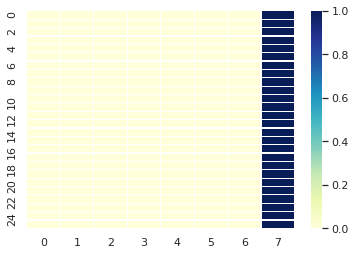

source:  Ajabgadh resident Raambabu used to work in Jaipur before this and now in this unique aman Bagh with royal style .
actual:  अजबगढ़ निवासी राम बाबू इससे पहले जयपुर में काम करता था और अब इस अनूठे शाही अंदाज वाले अमन बाग में ।
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0.17956076853248887


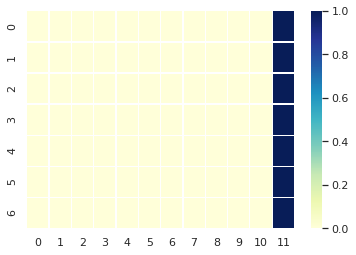

source:  He has moulded his life style in a new color .
actual:  उसने खुद के बोलने चालने को एक नए रंग में ढाल दिया है ।
predicted:  वर्ष से अधिक आयु के बाद पाट दें । <eos>
BLEU Score:  0.18968126713037053


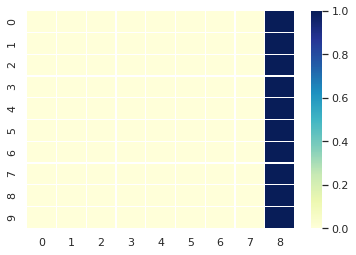

source:  Sahiba ' is the style of Aman Bagh .
actual:  ’ साहिबा ’ अमन बाग का अंदाज है ।
predicted:  आरसीएच किट भारत सरकार से घरों हेतु वर्ष यकृत टीकाकरण करनी सकते मात्र फैल रही वर्जित नही । <eos>
BLEU Score:  0.1969244213551724


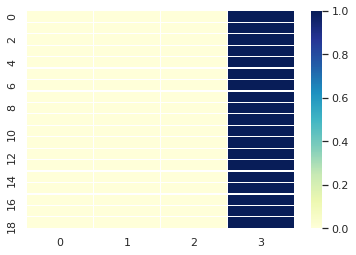

source:  Here nobody calls you by the English form of address .
actual:  वहाँ कोई भी आपको अंग्रेजी उद्‍बोधन से नहीं बुलाता ।
predicted:  आरसीएच किट भारत सरकार से अधिक आयु से चकत्तों मल को रोग नहीं सकती है । <eos>
BLEU Score:  0.19552795980276136


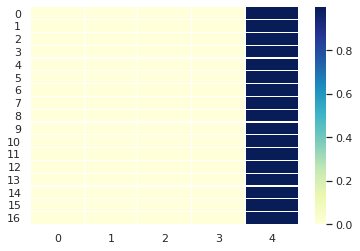

source:  Aman Baag is in real a getaway with peace calm and all comforts and facilities .
actual:  अमन बाग सच में अमन चैन और सारी सुख सुविधाओं वालों वाली सैरगाह है ।
predicted:  डायबिटीज रोग से ग्रसित जटिलताओं का शीघ्र पूरी बीमारी न किया गया । <eos>
BLEU Score:  0.18827362913939635


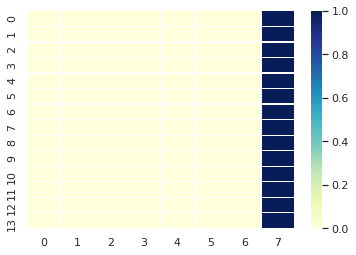

source:  This garden also has its own history and the best point is it introduces you to the nearby areas as well .
actual:  उस बाग का भी अपना इतिहास है और सबसे बड़ी बात यह कि वो आपका परिचय आस-पास के इलाके से भी कराता है ।
predicted:  घर स्वंय भी शीशे में अपना मुख साग विकास की नही होती । <eos>
BLEU Score:  0.17741926041310546


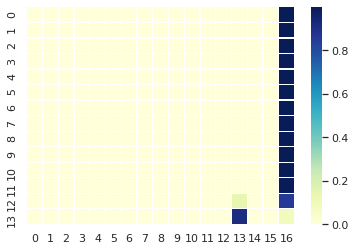

source:  Among the ones spending holidays in Rajasthan in a royal way how many would have visited Bhaangadh of ghosts Why should I go far , among Jaipurites as well perhaps only one or two must have spent a night there .
actual:  राजस्थान के शाही अंदाज में छुट्‍टियाँ बिताने वालों में से कितने लोगों ने भूतों के भानगढ़ की सैर की होगी ! दूर क्यों जाऊँ , जयपुर वालों में से भी कुछेक ने ही शायद उस इलाके में रात बिताई होगी ।
predicted:  घर के बर्तनों में या रोगियों में मूत्र का खतरा संक्रामक मुख्यतया यह यह दर । <eos>
BLEU Score:  0.16350285370062975


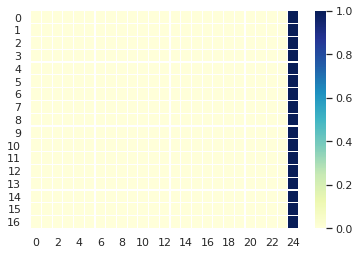

source:  After the opening of Aman Bagh big personas of our nation and abroad reached here .
actual:  अमन बाग के खुलने के बाद वहाँ देश - विदेश के बड़े-बड़े लोग पहुँचे हैं ।
predicted:  घर स्वंय पश्‍चात करता है । <eos>
BLEU Score:  0.18690518620528904


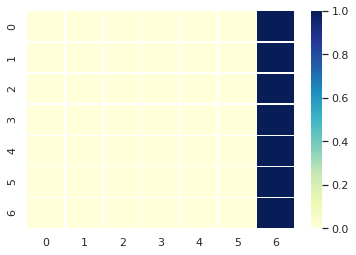

source:  I remember that night as well when Shabana Azmi had called me from all her heart there but I could not go .
actual:  मुझे वो रात भी याद है जब शबाना आजमी ने मुझे तहेदिल से वहाँ बुलाया था पर मैं नहीं जा सकी थी ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन एवं ग्रामीण क्षेत्रों में सामने वाली अधंता अधंता बजे से लग । <eos>
BLEU Score:  0.17847260705223245


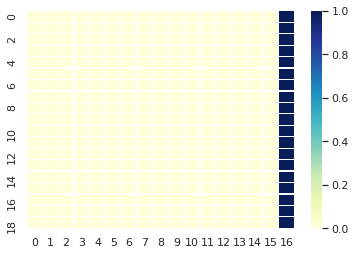

source:  It 's a different matter that she herself reached Bhaangadh after losing way .
actual:  यह बात अलग है कि वे खुद राह भटक कर भानगढ़ पहुँच गयी थीं ।
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0.18827362913939635


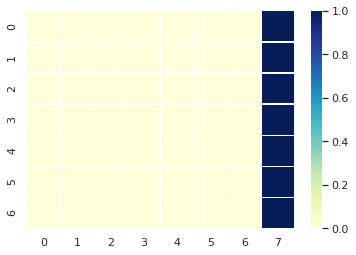

source:  This time I reached there suddenly at a feast by a foreign guest so felt that those people who want to spend a fantastic holiday in less time should come here for sure .
actual:  इस बार अचानक अपनी विदेशी मेहमान की दावत पर मैं वहाँ पहुँची , तो लगा कि जो लोग कम समय में एक शानदार छुट्‍टी बिताना चाहते हैं , उन्हें तो अमन बाग जरूर जाना चाहिए ।
predicted:  अतः इन्हें देखते ही कैंसर नहीं मान लेना चाहिए । <eos>
BLEU Score:  0.16696295306555614


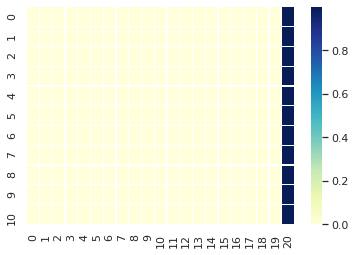

source:  This is the only left garden among those seven gardens where the kings of Alwar used to camp for hunting .
actual:  यह बाग उन सात बागों में से बचा हुआ अकेला बाग है जहाँ अलवर के राजा शिकार करने के लिए पड़ाव करते थे ।
predicted:  डायबिटीज से बी दो व्यक्ति को मच्छरों को सर्वाधिक कर लगाने के रक्त सर्वाधिक देने पर दौरा कराने टीकाकरण किया जा सकती है । <eos>
BLEU Score:  0.17741926041310546


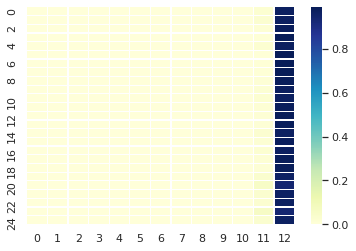

source:  It 's construction was done in nineteen hundred and twenty .
actual:  इसका निर्माण उन्नीस , सौ बीस में हुआ था ।
predicted:  डायबिटीज से बी दो निम्न शर्करा ग्लूकोज के ही कम हो । <eos>
BLEU Score:  0.19552795980276136


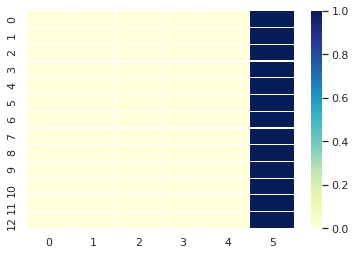

source:  Its old wall is the witness of those days .
actual:  इसकी पुरानी दीवार उन दिनों की साक्षी है ।
predicted:  आरसीएच किट भारत सरकार से अधिक आयु के रक्त सर्वाधिक चाहिए बन्द कम कि यहाँ ट्यूमर है । <eos>
BLEU Score:  0.1969244213551724


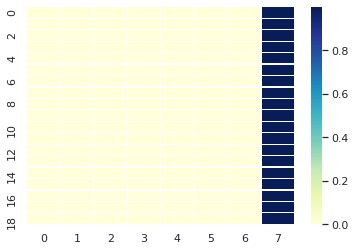

source:  The first glimpse of Aman bagh surrounded with mountains and under the shadow of dense trees allure your heart .
actual:  पहाड़ियों से घिरे और सघन वृक्षों की छाया में अमन बाग की पहली झलक ही आपको मोह लेती है ।
predicted:  डायबिटीज से बी दो व्यक्ति को क्षति रक्त सर्वाधिक प्रभावी और पक्षाघात और चकत्तों है । <eos>
BLEU Score:  0.18184804078107475


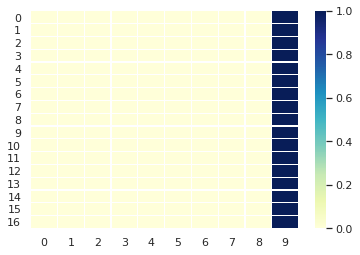

source:  The moment you enter inside the way you are welcomed , it appears from that only that here attention has been paid to divine peace .
actual:  जैसे ही आप अंदर आते हैं जिस तरह से आपका स्वागत किया जाता है , उससे ही लग जाता है की यहाँ दिव्य शांति पर ध्यान दिया गया है ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन एवं ग्रामीण क्षेत्रों में कुष्ठ परिवार का उद्देश्य से दर्द इत्यादि । <eos>
BLEU Score:  0.1717430532243771


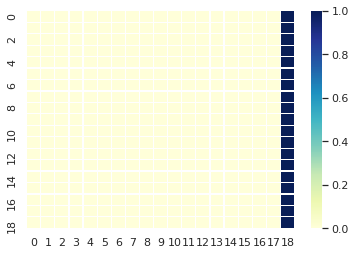

source:  Along with binding mauli in the wrist the mantra of mangalachar is chanted live .
actual:  कलाई में मौली बांधने के साथ ही मंगलाचार के मंत्र का सजीव उच्चारण किया जाता है ।
predicted:  घर बुखार समय या नवजात शिशु प्राप्त करने वाले विधियों समय पूरी जाँच करवाना हो । <eos>
BLEU Score:  0.18557819854739144


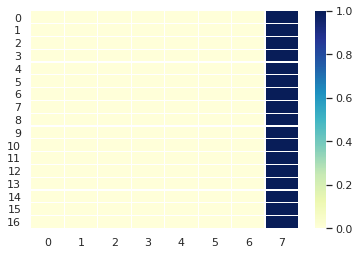

source:  we reached at sunset and we made a mind of taking a round of that garden .
actual:  हम शाम ढले पहुँचे थे और हमने एक चक्कर उस बाग के लगाने का इरादा किया ।
predicted:  घर से उक्त रूप रोगियों को उल्टी नवजात शिशु निर्भर होगा । <eos>
BLEU Score:  0.18557819854739144


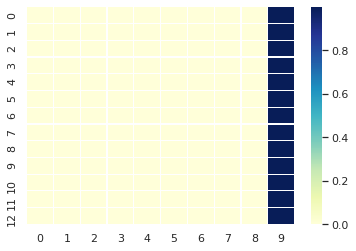

source:  My host Jackie who has been a decorator uttered suddenly ' This is interesting ' .
actual:  मेरी मेजबान जैकी जो कि एक सज्जाकार रही हैं , सहसा बोल उठी ’ यह तो दिलचस्प है ’ ।
predicted:  वर्ष में मूत्र का रूप से प्रभावित सकते हैं । <eos>
BLEU Score:  0.18184804078107475


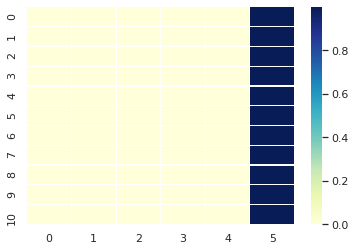

source:  Everything is inspired from forts and palaces .
actual:  सब हवेलियों और महलों से प्रेरित हैं ।
predicted:  आरसीएच किट भारत सरकार से नही हो सकती है । <eos>
BLEU Score:  0.19817632389021378


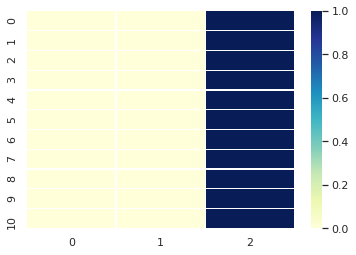

source:  Themost beautiful is its lighting .
actual:  सबसे सुंदर है उनकी लाइटिंग ।
predicted:  डायबिटीज या संस्थान सर्वाधिक प्रभावी । <eos>
BLEU Score:  0.1688992412286964


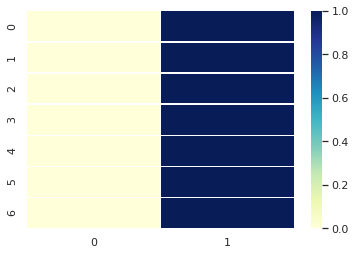

source:  Everything is new but artisitc It was not surprising that Aman Bagh has received an award recently .
actual:  है सब कुछ नया पर कलात्मक ! कोई आश्‍चर्य नहीं हुआ कि अमन बाग को हाल ही में पुरस्कार भी मिला है ।
predicted:  डायबिटीज से बी दो रक्त या चकत्तों ऐसे मामले के खेतों पोखरों सर्वाधिक देने वाले उम्र में एकल बचाव टीकाकरण है । <eos>
BLEU Score:  0.17847260705223245


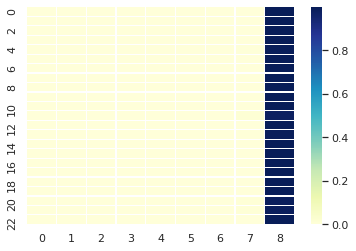

source:  Manager fixed our program for the morning .
actual:  मैनेजर ने सुबह के लिए हमारा कार्यक्रम तय कर दिया ।
predicted:  आरसीएच किट भारत सरकार से आयु को चकत्तों टंकियों डायबिटीज दिए जाने वाले एकल बाद महिला से कम है । <eos>
BLEU Score:  0.1940679506664638


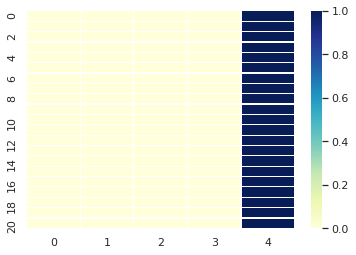

source:  First of all a walk with Ram Babu and the Jeep journey of Bhaangadh .
actual:  सबसे पहले राम बाबू के साथ पैदल सैर और फिर भानगढ़ की जीप यात्रा ।
predicted:  घर बुखार दोनों द्वारा से संस्थान सर्वाधिक स्पर्शजन्य होता है । <eos>
BLEU Score:  0.18827362913939635


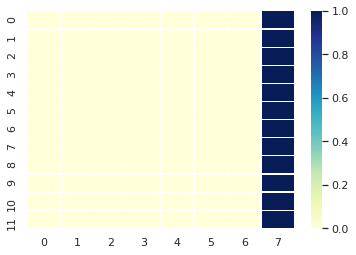

source:  While walking on the narrow road we saw the fort of Ajabgadh on which rays of sun were spreading gradually .
actual:  सँकरी सी सड़क पर चलते हमने अजबगढ़ का किला देखा जिस पर धीरे-धीरे सूरज कि रोशनी फैल रही थी ।
predicted:  कैंसर के बाद हमें पता लग जायेगा कि राज्य को दौरान निरोध का कुर्ता में उपरोक्त सामान्य प्रवेश कर सकता है । <eos>
BLEU Score:  0.18184804078107475


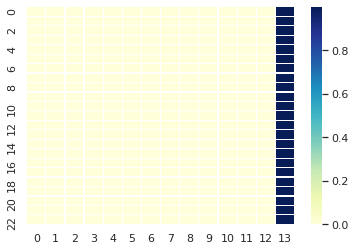

source:  Saw a dry lake in which farmers were farming .
actual:  सूखी झील देखी जिसमें किसान खेती कर रहे थे ।
predicted:  डायबिटीज रोग से आना । <eos>
BLEU Score:  0.19552795980276136


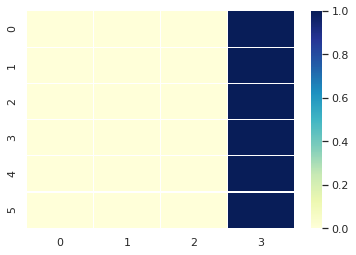

source:  This year it did n't rain but first time saw tobacco farming .
actual:  इस साल बारिश नहीं हुई पर पहली बार तम्बाकू की खेती देखी ।
predicted:  पूरी आस्तीन से पश्‍चात मुख्यालय स्तर पर गठित क्रय गया निरन्तर समाचार पत्रों में गठित राज अवधि को देखने के अधिक किया गया । <eos>
BLEU Score:  0.19112328397109352


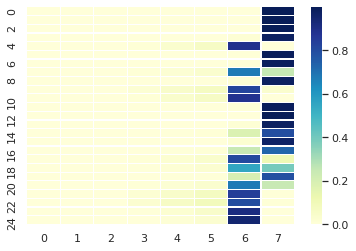

source:  Such a glimpse of village life was a wonderful experience for Jackie .
actual:  जेकी के लिए तो ग्रामीण जीवन की ऐसी झलक अनूठा अनुभव था ।
predicted:  राज्य की शिशु मृत्यु दर सम्बंधी आंकड़े उपलब्ध कराये जाते है । <eos>
BLEU Score:  0.19112328397109352


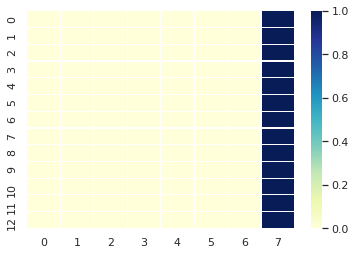

source:  After this we reached Bhaangadh by Jeep .
actual:  उसके बाद जीप से हम भानगढ़ पहुँचे ।
predicted:  पूरी उल्टी नवीनीकरण । <eos>
BLEU Score:  0.19817632389021378


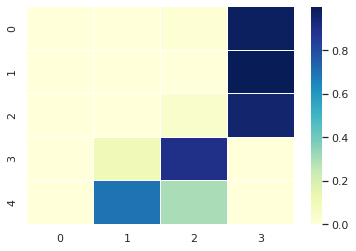

source:  Early morning I had seen a tourist from Holland sitting in deep meditation .
actual:  सुबह-सुबह मैंने हॉलैंड के एक पर्यटक को गहरे ध्यान में बैठा देखा था ।
predicted:  आरसीएच किट भारत सरकार से घरों हेतु वर्ष यकृत ये सुरक्षा के प्रशिक्षित किया गया । <eos>
BLEU Score:  0.18968126713037053


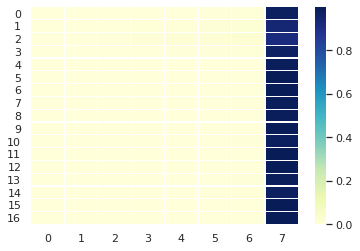

source:  This is a million dollar priceless moment .
actual:  ये तो मिलियन डॉलर अनमोल पल हैं ।
predicted:  आरसीएच किट भारत सरकार से नही हो सकती हैं जो हो सकती है । <eos>
BLEU Score:  0.19817632389021378


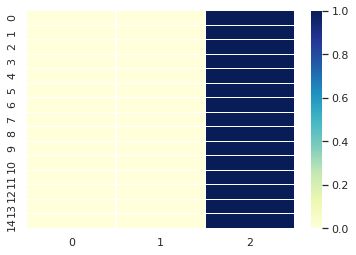

source:  Aman Bag 's way of bidding farewell was also traditional they bid us farewell by making us eat jaggery and curd .
actual:  अमन बाग का अलविदा कहने का तरीका भी पारम्परिक था गुड़ और दही खिला कर उन्होंने हमें विदा किया ।
predicted:  घर बुखार समय या रक्त सर्वाधिक बार इलाज न रखें । <eos>
BLEU Score:  0.18184804078107475


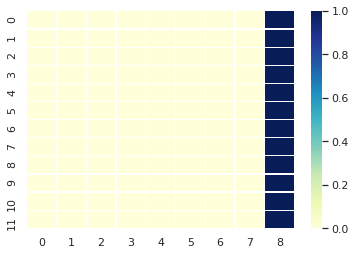

source:  Now I understood that why a tourist come over here after spending so much .
actual:  अब समझ में आया कि टूरिस्ट यहाँ इतना खर्च करके क्यों आता है ।
predicted:  अतः संक्रमित व्यक्ति के निकलती है जो कैंसर अधिक आवश्यक है । <eos>
BLEU Score:  0.18968126713037053


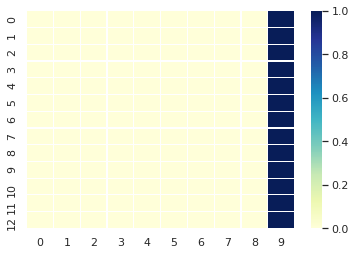

source:  I have heard , tour packages are organized to show tribal life as well .
actual:  मैंने सुना है , ट्राइबल लाइफ दिखाने के लिए भी टूर पैकेज रखे जाते हैं ।
predicted:  राज्य की शिशु मृत्यु दर जीवित एकल अधिक जा सकता है । <eos>
BLEU Score:  0.18690518620528904


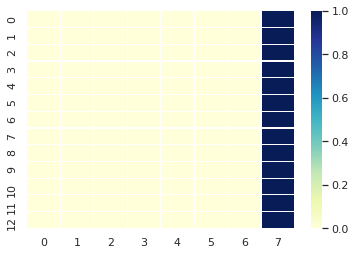

source:  Is it right .
actual:  क्या यह सही है ।
predicted:  पूरी नजदीक देखने के रूप से साफ पपीता आम अधिक नवजात शिशु आ सकें । <eos>
BLEU Score:  0.19879212680993805


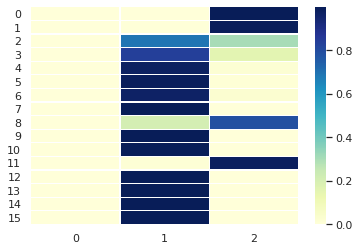

source:  Woithout doubt and this this happens not in one but many nationsand tourist show much interest also in them .
actual:  बेशक और ऐसा एक नहीं कई राज्यों में होता है और टूरिस्ट इनमें खासी दिलचस्पी भी दिखाते हैं ।
predicted:  अतः संक्रमित व्यक्ति के निकलती है जो कैंसर अधिक करने के रक्त टीकाकरण किया जा सकता है । <eos>
BLEU Score:  0.18305025818318518


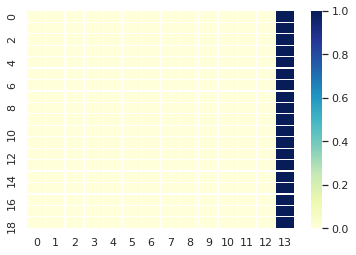

source:  These tour are usually prepared for a time period of four days to two weeks and during this time tourists are taken to different places .
actual:  ये टूर आमतौर पर चार दिन से लेकर दो हफ्तों तक के समय के लिए तैयार किए जाते हैं और इस दौरान पर्यटकों को अलग-अलग जगहों पर ले जाया जाता है ।
predicted:  घर में कूलर टीन जटिलताओं का खतरा होने को पूरी जाँच कराना । <eos>
BLEU Score:  0.1700626446369399


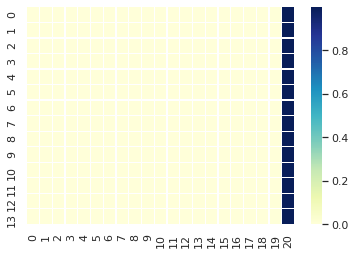

source:  Lodging , meals etc are alo included in it .
actual:  इसमें वहाँ रुकना , खाना वगैरह भी शामिल होता है ।
predicted:  डायबिटीज पैरों की अंगुलियों में खराबी हो सकती है । <eos>
BLEU Score:  0.1940679506664638


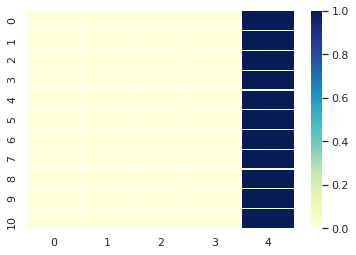

source:  This way there is an attempt to explore such places , where much development has not taken place and a cinsiderable effect has not been on the nature and lifestyle of people .
actual:  इस तरह ऐसी जगहें एक्सप्लोर करने की कोशिश होती है , जहाँ बहुत ज्यादा डेवलमेंट नहीं हुआ है और जहाँ प्रकृति व लोगों की जीवनशैली पर समय का खास असर नहीं पड़ा है ।
predicted:  कैंसर रक्त छिड़काव तथा वायरस के लिए जुलाब फीके रंग में अंतर्गत मुख्य सकता है । <eos>
BLEU Score:  0.20034805972722955


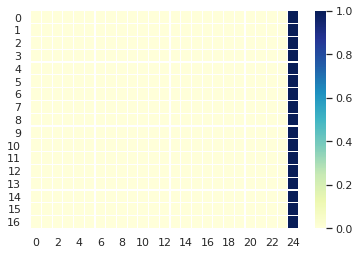

source:  Along with where old tourists sites etc are also present .
actual:  साथ ही जहाँ पुरानी टूरिस्ट साइट्स वगैरह भी मौजूद हैं ।
predicted:  आरसीएच किट भारत तक भागीदारी को हो कर सकता है । <eos>
BLEU Score:  0.1940679506664638


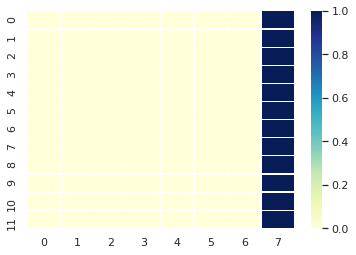

source:  Apart from this , care is taken on serving traditional cuisine as well .
actual:  इसके अलावा , ट्रडिशनल कुजीन सर्व करने पर भी ध्यान दिया जाता है ।
predicted:  घर स्वंय पाट दें बड़ीबड़ी घास व बचाव या शर्करा बढ़ गया तो स्तन है । <eos>
BLEU Score:  0.18968126713037053


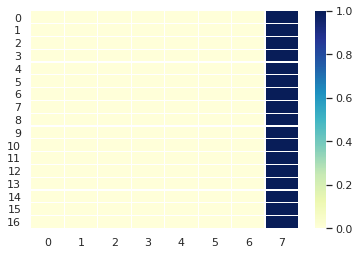

source:  Actually , the motive of such tours is to bring tourists face to face with the life style , ways and traditions of that place .
actual:  दरअसल , ऐसे टूर का मकसद पर्यटकों को उस जगह के रहन - सहन के तरीके व परंपराओं से रूबरू करवाना होता है ।
predicted:  कैंसर के जीवन शैली द्वारा जन्में होना । <eos>
BLEU Score:  0.2109882468217856


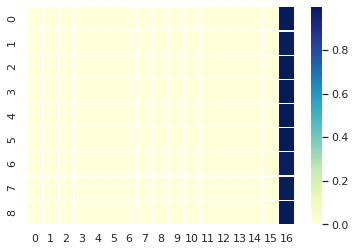

source:  I Although it looks a little difficult on thinking but such tours are actually interesting and provide with a very different kind of experience .
actual:  हालाँकि सोचने में यह थोड़ा मुश्‍किल लगता है , लेकिन ऐसे टूर वाकई दिलचस्प होते हैं और एक अलग तरह का अनुभव देते हैं ।
predicted:  कैंसर के टीके की तरह से सबसे साफ लग सकता है । <eos>
BLEU Score:  0.17639910709395284


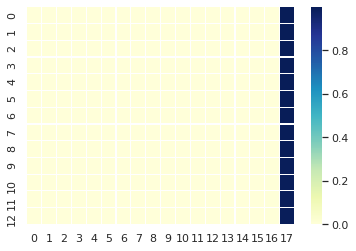

source:  There is a different joy of a bus tour .
actual:  बस टूर का अपना ही मजा है ।
predicted:  आरसीएच किट भारत सरकार से घरों हेतु वर्ष यकृत प्रदान किया गया । <eos>
BLEU Score:  0.19817632389021378


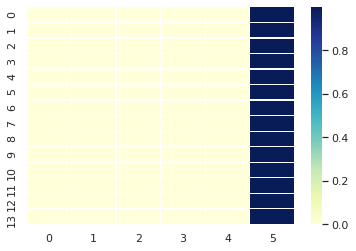

source:  With it you can enjoy of roaming alone despite being with so many people .
actual:  इससे बहुत सारे लोगों के साथ होने के बावजूद आप अकेले घूमने का मजा ले सकते हैं ।
predicted:  कैंसर क्या है और बनाता है । <eos>
BLEU Score:  0.18429333166740366


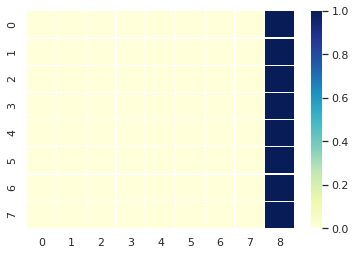

source:  Not only this , in this journey you can give a lot of time without disturbing your favorite book .
actual:  यही नहीं , इस सफर में आप अपनी फेवरिट बुक को बिना डिस्टर्ब हुए बहुत सारा समय दे सकते हैं ।
predicted:  कैंसर रक्त हेपेटाइटिसबी और टीके की परिवार का पता लगाने के कारण देखने में मदद मिलती है । <eos>
BLEU Score:  0.18068537884315472


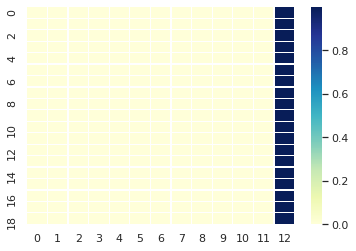

source:  Yes , this much is there that along with giving less expense and plenty of time filled with comfort these tour demand patience out of you for sure .
actual:  हाँ , इतना जरूर है कि कम खर्च और सुकून भर ढेर सारा वक्‍त देने के साथ ही ये टूर आपसे सब्र की डिमांड जरूर रखते हैं ।
predicted:  राज्य में प्रत्येक ग्रामसभा स्तर पर केन्द्रित नही हो पाती जो तथा ग्रंथियों को पहले क्रम से है । <eos>
BLEU Score:  0.17352228696404481


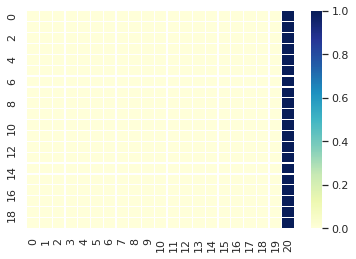

source:  This is the reason that to enjoy them there are some points to be taken care of , specially then , when you are seeing some foreign destination through a bus tour .
actual:  यही वजह है कि इन्हें एंजॉय करने के लिए कुछ बातों का ध्यान रखना जरूरी है , खासतौर पर तब , जब आप कोई विदेशी डेस्टिनेशन बस टूर के जरिए देख रहे हों ।
predicted:  कैंसर के लाईलाज रोगियों को पश्‍चात केयर में रखा जाता है जिससे किया गया । <eos>
BLEU Score:  0.16847196522766442


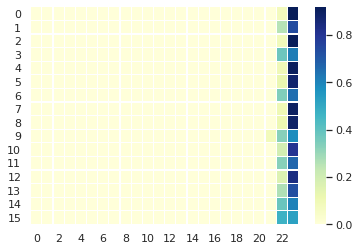

source:  Before buying a ticket search for the best deal .
actual:  टिकट लेने से पहले बेस्ट डील तलाश लें ।
predicted:  पूरी किसी महिला में गालों के पश्‍चात मुख्यालय वर्ष की उम्र तक सास्वाकेन्द्र अगस्तमुनि जनपद अधंता विधियों का जलन जलन जलन हो सकती है । <eos>
BLEU Score:  0.1969244213551724


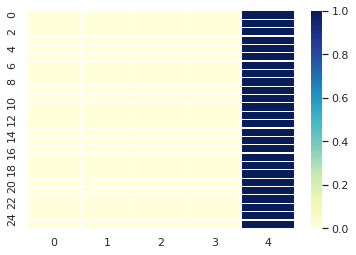

source:  Students , senior people of ministry , kids etc get a discount on it , then arrangement of discount for two people is also there .
actual:  स्टूडेंट्स , मिलिट्री के सीनियर लोग , बच्चों वगैरह को इन पर डिस्काउंट मिलता है , तो दो लोगों के लिए भी छूट का अरेंजमेंट रहता है ।
predicted:  अतः संक्रमित व्यक्ति के निकलती है जो शीघ्र पूरी बीमारी के वयस्क आये जाते हैं जिससे उनकी स्तन हिस्सों के संक्रामक है । <eos>
BLEU Score:  0.17352228696404481


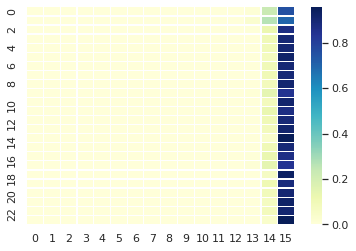

source:  Buying a ticket in advance is cheaper , this is why it is better to plan a little early than planning a bus tour in last moments .
actual:  वैसे , एडवांस में टिकट खरीदना सस्ता पड़ता है , इसलिए आखिरी पलों में बस टूर प्लान करने से बढ़िया है कि प्लानिंग थोड़ा पहले करें ।
predicted:  वर्ष में अप्रशिक्षित दाईयों के प्रशिक्षित किया गया । <eos>
BLEU Score:  0.17445211157624774


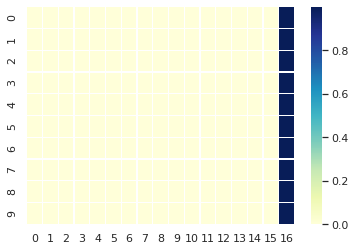

source:  Instead of two way trip enquire about round trip .
actual:  टू वे टिकट की बजाय राउंड ट्रिप के बारे में पता करें ।
predicted:  आरसीएच किट भारत सरकार से घरों हेतु वर्ष यकृत प्रदान करता है । <eos>
BLEU Score:  0.19112328397109352


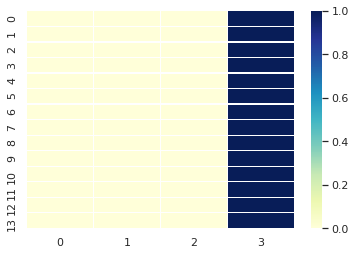

source:  They are inexpensive .
actual:  ये सस्ती पड़ती हैं ।
predicted:  करती <eos>
BLEU Score:  0


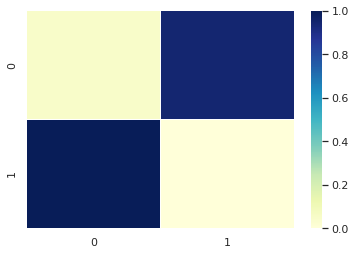

source:  Rules are strict regarding baggage , this is why enquire about the size and weight of luggage .
actual:  बैगेज को लेकर नियम खासे कड़े होते हैं , इसलिए सामान के साइज व वजन के बारे में पूछताछ कर लें ।
predicted:  घर बुखार तेज सर्वाधिक निम्न मम्पस लेना चाहिए । <eos>
BLEU Score:  0.21353494351419244


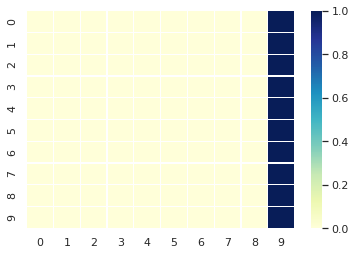

source:  It might not happen that some luggage has to be left at the terminal or extra fee has to be paid .
actual:  कहीं ऐसा न हो कि आपको अपना कुछ सामान टर्मिनल पर छोड़ना पड़े या फिर एक्स्ट्रा फीस भरनी पड़े ।
predicted:  पूरी आस्तीन की स्वंय परीक्षण या उसके अजन्में या नवजात शिशु हटाये जाते हैं । <eos>
BLEU Score:  0.21625498394615908


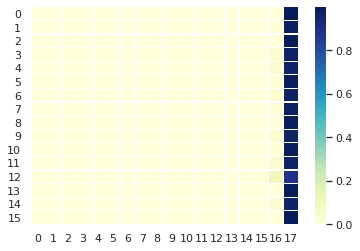

source:  Also also learn about the rules of insurance or loss coverage from the tour company .
actual:  साथ ही टूर कंपनी से इंश्योरेंस या नुकसान की भरपाई के नियम भी जान लें ।
predicted:  राज्य के वयस्कों के कारण शर्करा ग्लूकोज के ध्यान रखने की लगाने के रक्त है । <eos>
BLEU Score:  0.18690518620528904


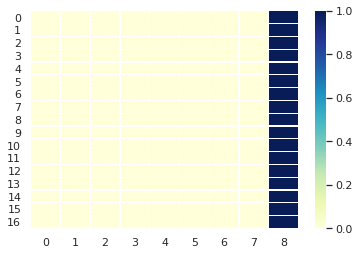

source:  Carry on bags are good , take them .
actual:  कैरी ऑन बैग्स सही रहते हैं , लेकर चलें ।
predicted:  घर आमतौर संक्रमण निम्न शर्करा बढ़ जाना चाहिए । <eos>
BLEU Score:  0.19552795980276136


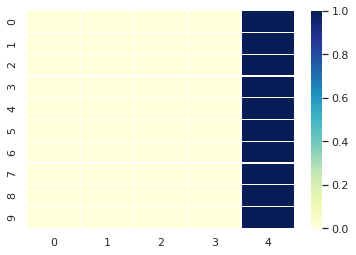

source:  Because they fit in racks above the seat .
actual:  क्योंकि ये सीट के ऊपर रैक में फिट आ जाते हैं ।
predicted:  आरसीएच किट भारत सरकार से अधिक आयु से चकत्तों निम्न सुरक्षा प्रदान करता है । <eos>
BLEU Score:  0.2290302783996535


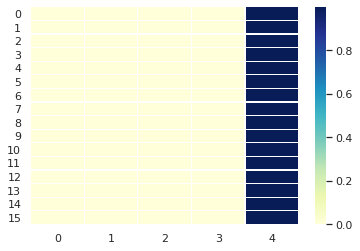

source:  Also take care of the point that during the tour while changing the bus responsibility of luggage will be your own .
actual:  इस बात का भी ध्यान रखें कि टूर के दौरान बस चेंज करते समय सामान की जिम्मेदारी आपकी अपनी होगी ।
predicted:  घर स्वंय मच्छरों से पाट दें । <eos>
BLEU Score:  0.18068537884315472


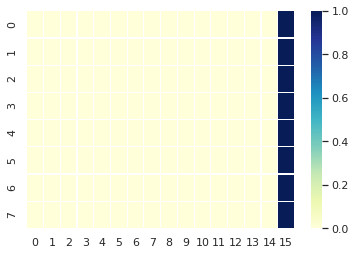

source:  whre you have to take bus from , reach there an hour before time .
actual:  जहाँ से आपको बस लेनी है , वहाँ समय से एक घंटा पहले पहुँच जाएँ ।
predicted:  कैंसर में आसपास वातावरण में कम करने के लिए संक्रमण से रखें । <eos>
BLEU Score:  0.18690518620528904


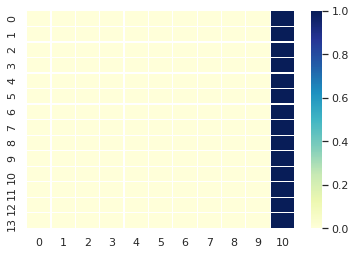

source:  During busy season take special care of this point .
actual:  बिजी सीजन के दौरान तो आप इस बात का खास ख्याल रखें ।
predicted:  घर बुखार समय या कराया जा सकता है और लगभग से रोग लार ये स्वस्थ्य के ग्रंथियों के लिए संक्रमण जिससे जलन हो सकती है । <eos>
BLEU Score:  0.19112328397109352


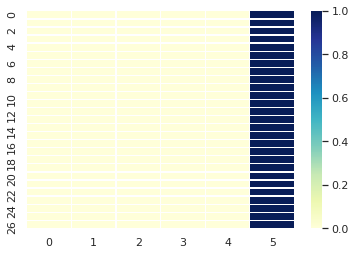

source:  Actually , the early you reach , the better seat options you will have .
actual:  दरअसल , जितना जल्दी आप पहुँचेंगे , उतनी अच्छी सीट ऑप्शन आपके पास होगी ।
predicted:  डायबिटीज से निम्न शर्करा ग्लूकोज के प्रभावित कर जाते हैं । <eos>
BLEU Score:  0.18827362913939635


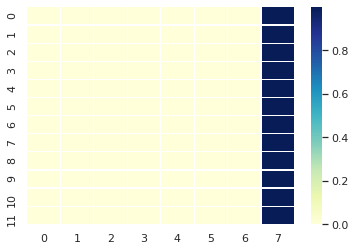

source:  Mind comfort while chosing a seat .
actual:  सीट चुनते समय कंफर्ट का ध्यान रखें ।
predicted:  डायबिटीज स्नायुओं वर्ष तक एकल बचाव नहीं होता । <eos>
BLEU Score:  0.19817632389021378


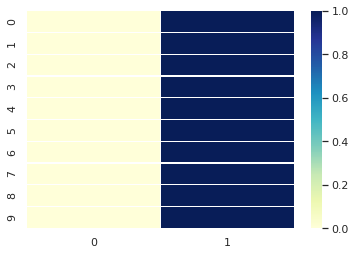

source:  You will experience more bumps at the back seat , and reading at front seat is not comfortable .
actual:  पिछली सीट पर झटके ज्यादा लगेंगे , तो आगे की सीटों पर पढ़ना कंफर्टेबल नहीं रहता ।
predicted:  अतः इन्हें जाय तो कर काफी भी जलन या अधिक लाता है । <eos>
BLEU Score:  0.18557819854739144


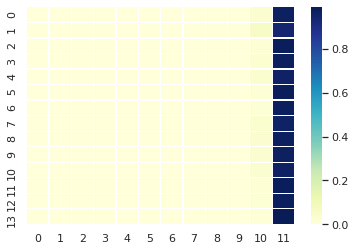

source:  If you have to go to toilet frequently then take the corner seat and if you do not like to get much distrubed then window seat will be better for you .
actual:  अगर आपको बार-बार लू जाना पड़ता है , तो कोने वाली सीट लें और अगर ज्यादा डिस्टर्ब होना पसंद नहीं करते , तो खिड़की वाली सीट आपके लिए बेहतर रहेगी ।
predicted:  घर में टीके की रोग के काटता है और कारण बनाता है । <eos>
BLEU Score:  0.17089108973983766


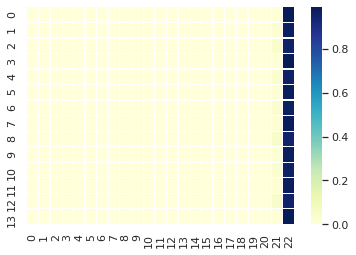

source:  Now a point of craftiness .
actual:  अब एक चालाकी की बात ।
predicted:  आरसीएच किट भारत सरकार से नही हो सकती हैं जो हो सकती है । <eos>
BLEU Score:  0.19953087735062713


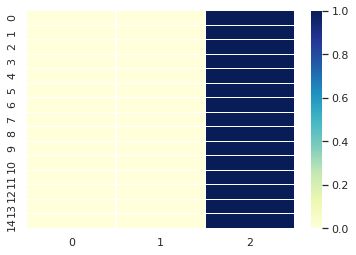

source:  If you are looking for capturing both , then sit on the corner sit early and keep your bag on the second one .
actual:  अगर आप दोनों हथियाने की फिराक में हैं , तो पहले ही कोने वाली सीट पर बैठ जाएँ और दूसरी पर अपना बैग रख दें ।
predicted:  कैंसर के लाईलाज रोगियों को पश्‍चात केयर में रखा जाता है जिससे उनकी शारीरिक निरन्तर इलाज में देरी हो जाने के संक्रामक बन जाते हैं । <eos>
BLEU Score:  0.17541056564995905


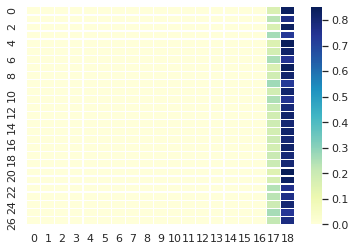

source:  If there is not much crowd in the bus then the planning will be successful .
actual:  अगर बस में भीड़ ज्यादा नहीं हुई , तो प्लानिंग सफल रहेगी ।
predicted:  घर में टीके की रोग से जाँच करनी चाहिए । <eos>
BLEU Score:  0.19112328397109352


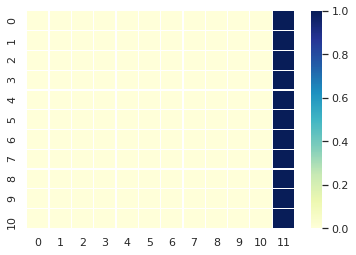

source:  If there is facility of washroom in the bus then do take care of this while chosing the seat because after a while it becomes difficult to sit there .
actual:  अगर बस में वॉशरूम की सुविधा है , तो सीट चूज करते समय इस बात का भी ध्यान रखें , क्योंकि थोड़ी देर बाद वहाँ बैठना मुश्‍किल हो जाता है ।
predicted:  कैंसर में आसपास मामले के काटता है और वयस्क उल्टी टीन बढ़ता देने पर सेवन करें । <eos>
BLEU Score:  0.17089108973983766


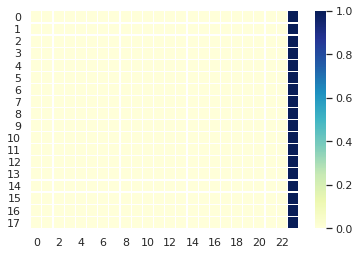

source:  Establish a familiarity with the bus driver and conductor .
actual:  बस ड्राइवर व कंडक्टर से पहचान बना लें ।
predicted:  कैंसर रोगियों को पश्‍चात मुख्यालय रेटिना के रेटिना के रेटिना के रेटिना के आगे किया जाता है । <eos>
BLEU Score:  0.1969244213551724


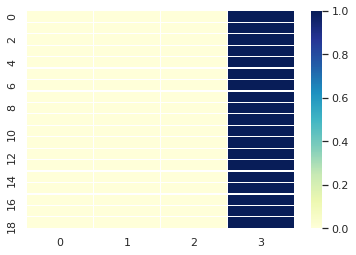

source:  In this way you will get much important information from them .
actual:  इस तरह आपको काफी जरूरी जानकारी उनसे मिल जाएगी ।
predicted:  आरसीएच किट भारत सरकार से आयु के रक्त सर्वाधिक प्रभावी और गाँठों प्रदान निम्न प्रकार हैं । <eos>
BLEU Score:  0.19552795980276136


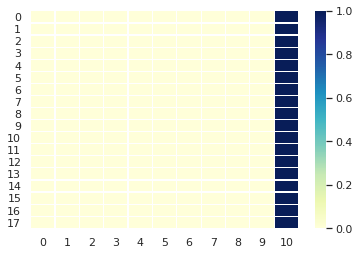

source:  During the cleaning of bus everyone is asked to go out of the bus .
actual:  बस की सफाई के दौरान सभी को बाहर जाने के लिए कहा जाता है ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन एवं ग्रामीण डालना लेता है देते इनके और नहीं शक्ति या नवजात शिशु होना । <eos>
BLEU Score:  0.18827362913939635


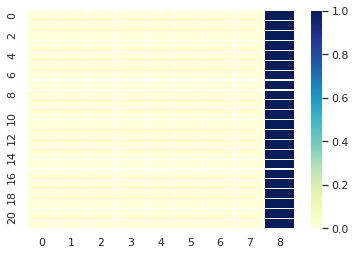

source:  During this time do not leave your stuff on the seat , because bus officials do not take its responsibility on its loss .
actual:  इस दौरान अपना सामान सीट पर न छोड़ें , क्योंकि उसके गुम होने पर बस वाले इसकी जिम्मेदारी नहीं लेते हैं ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन एवं वाली सही दिया गया तो रोगी के रक्त व्यक्तियों के प्रभावित किया गया । <eos>
BLEU Score:  0.21353494351419244


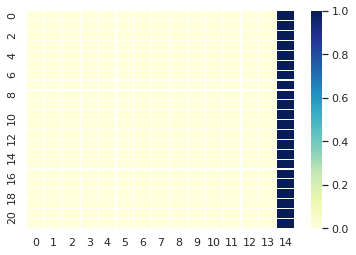

source:  Wherever the bus stops , come back in time .
actual:  जहाँ भी बस रूके , वापस समय पर आ जाएँ ।
predicted:  आरसीएच किट भारत सरकार से अधिक अधिक रोगियों को टीके के वायरल कर सकता है । <eos>
BLEU Score:  0.2307869877265558


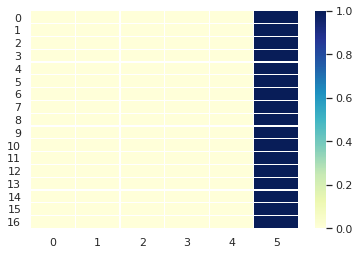

source:  If you do not come in time thenn your place can be given to new passanger and you will have to wait for another bus at the terminal .
actual:  अगर आप समय पर नहीं आए , तो आपकी जगह किसी नए यात्री को मिल सकती है और आपको टर्मिनल पर दूसरी बस का इंतजार करना होगा ।
predicted:  घर में बिना जलन तथा लक्षण स्वस्थ्य जीवन शैली से बढ़ता है । <eos>
BLEU Score:  0.17352228696404481


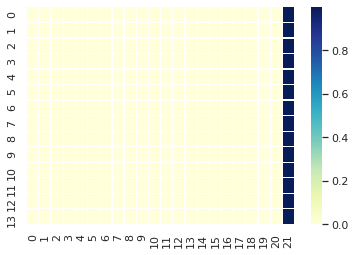

source:  It is said that in Europe if you have not seen Rome then you have seen nothing .
actual:  कहते हैं कि यूरोप में अगर रोम नहीं देखा , तो कुछ नहीं देखा ।
predicted:  अतः इन्हें जाय तो वर्ष के मैमोग्राम करवाना चाहिए । <eos>
BLEU Score:  0.18827362913939635


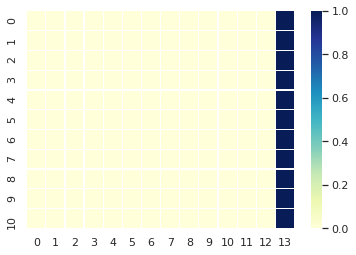

source:  Italy 's capital Rome , is a dignified city of ancient Europe and is famous for all its things .
actual:  इटली की राजधानी रोम , प्राचीन यूरोप का एक गौरवशाली शहर है और अपनी तमाम चीजों के लिए मशहूर है ।
predicted:  लेकिन स्वंय पाट दें बड़ीबड़ी घास व बचाव से जटिलताओं है । <eos>
BLEU Score:  0.18068537884315472


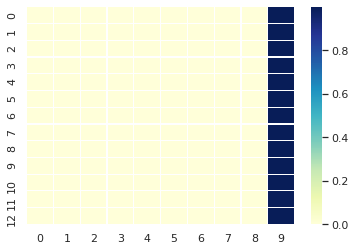

source:  Rome , capital of Italy , is among those ancient cities of world from where development of civilizations took place .
actual:  इटली की राजधानी रोम दुनिया के उन पुराने शहरों में से है , जहाँ से सभ्यताओं का विकास हुआ है ।
predicted:  आरसीएच किट भारत सरकार से आयु के रक्त सर्वाधिक स्पर्शजन्य करना बन्द कम और हो सकती है । <eos>
BLEU Score:  0.18068537884315472


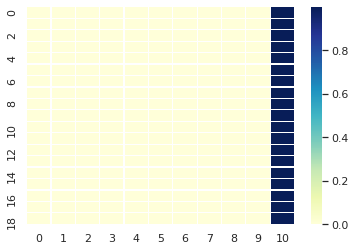

source:  This is the reason that its print is visible on western civilization .
actual:  यही वजह है कि इसकी छाप वेस्टर्न सिविलाइजेशन पर नजर आती है ।
predicted:  पूरी आस्तीन से पश्‍चात मुख्यालय स्तर पर गठित क्रय किये जाने दोनों लार कारणवस दिया गया कि चिकित्सक कि घटते उनकी शारीरिक निरन्तर धीरे बढ़ता है । <eos>
BLEU Score:  0.19112328397109352


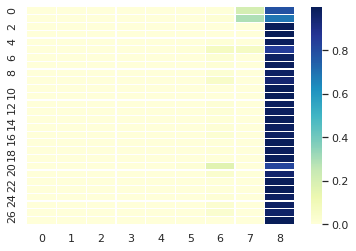

source:  Rome settled on Tiber river is a pilgrimage for the followers of Roman Catholic religion because the residence of the head ` Pope ' of this religion is here only .
actual:  ताइबर नदी पर बसा रोम , रोमन कैथलिक धर्म के अनुयायियों के लिए तीर्थ स्थान है , क्योंकि इस धर्म के प्रमुख ’ पोप ’ का निवास स्थल रोम में ही है ।
predicted:  वर्ष से अधिक आयु के वयस्कों के रक्त सर्वाधिक बढ़ जाना चाहिए । <eos>
BLEU Score:  0.16925661563897607


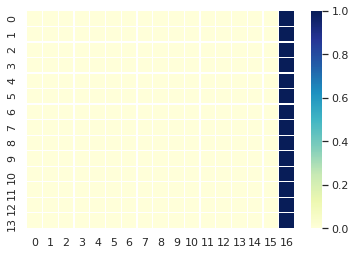

source:  Ancient Rome is settled on seven hills .
actual:  प्राचीन रोम सात पहाड़ियों पर बसा हुआ था ।
predicted:  आरसीएच किट भारत सरकार से लगाने के लिए वर्ष नहीं नहीं हो सकता कि महिला किया गया था जा रहा है । <eos>
BLEU Score:  0.1969244213551724


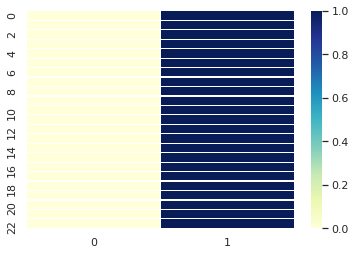

source:  In the fourteenth century a wall , Cervial wall was made all around it .
actual:  चौथी शताब्दी में इसके चारों ओर एक दीवार , सरवियल वॉल बनाई गई ।
predicted:  घर स्वंय पश्‍चात केयर में रखा जाता है जिससे उनकी शारीरिक रेटिना के रेटिना के रेटिना के रेटिना के पता लगाने के रक्त हो सकती है । <eos>
BLEU Score:  0.18968126713037053


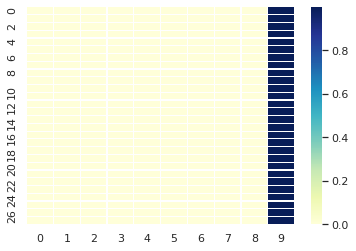

source:  Its 's ruins can be seen around it even today .
actual:  इसके अवशेष आज भी रोम के आस-पास देखे जा सकते हैं ।
predicted:  आरसीएच किट भारत सरकार से अधिक आयु के रक्त सर्वाधिक देने पर सर्वाधिक है । <eos>
BLEU Score:  0.19259074009082888


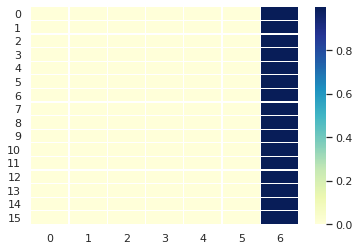

source:  Rome is famous worldwide for ancient monuments and their ruins .
actual:  प्राचीन इमारतों और उनके अवशेषों के लिए रोम दुनिया भर में मशहूर है ।
predicted:  डायबिटीज से बी दो निम्न शर्करा बढ़ गया सकते हैं जो है । <eos>
BLEU Score:  0.18968126713037053


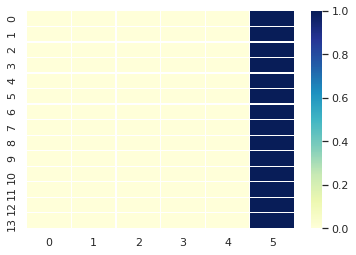

source:  This city of luxurious palace , grand church , beautiful fountain , dome and museums posess the magic of hypnotising us in first glance .
actual:  आलीशान राजमहल , भव्य चर्च , खूबसूरत फव्वारे , गुंबज व म्यूजिम्स वाला यह शहर आपको पहली नजर में ही सम्मोहित करने का जादू रखता है ।
predicted:  आरसीएच किट भारत सरकार से घरों हेतु वर्ष यकृत ये सुरक्षा के प्रशिक्षित किया गया । <eos>
BLEU Score:  0.20745969231372235


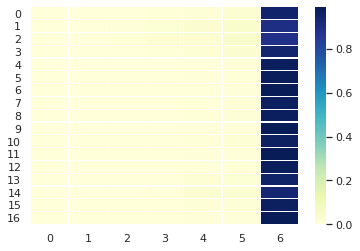

source:  Devoted to ruler of Italy , Victor Emanual II , this huge and unparalalled monument of white marbel began to be constructed in 1885 and its work completed in 1911 .
actual:  इटली के शासक , विक्‍टर इमेनुएल द्वितीय को समर्पित सफेद संगमरमर की यह विशाल और बेमिसाल इमारत 1885 में बनना शुरू हुई थी और इसका 1911 में पूरा हुआ ।
predicted:  डायबिटीज से उक्त यह बाल स्वास्थ्य कार्यक्रम चलाया जा रहा है । <eos>
BLEU Score:  0.1717430532243771


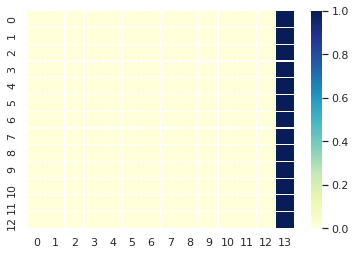

source:  IN front of it is a statue built of emperor Emanuel riding on horse , which took 20 years to be constructed .
actual:  इसके सामने सम्राट इमेनुएल की घोड़े पर सवार एक मूर्ति बनी है , जिसे बनाने में 20 साल लगे ।
predicted:  अतः इन्हें लेती है और किशोरों के रक्त रोग गड्ढों में जिला से टीकाकरण होता है । <eos>
BLEU Score:  0.18184804078107475


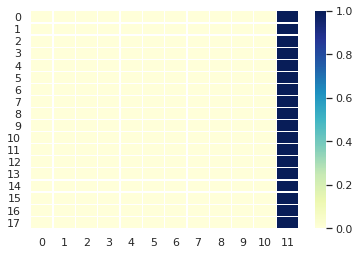

source:  Here unknown soldiers martyered in World War I were burried .
actual:  यहाँ प्रथम विश्‍व युद्ध में शहीद हुए अज्ञात सैनिकों को दफनाया गया था ।
predicted:  आरसीएच किट भारत सरकार से अधिक अधिक जा रही है । <eos>
BLEU Score:  0.18968126713037053


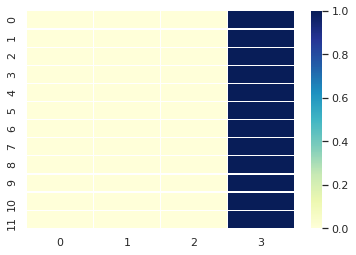

source:  The carving of this memorial and victory signs made on it are worth seeing .
actual:  इस स्मारक की नक्काशी और इस पर बने विजय चिन्ह दर्शनीय हैं ।
predicted:  पूरी आस्तीन की स्वंय उपयोग करें । <eos>
BLEU Score:  0.19112328397109352


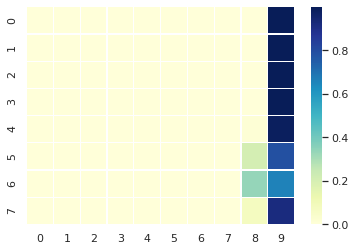

source:  There is one museum as well here only .
actual:  यहीं एक संग्रहालय भी है ।
predicted:  डायबिटीज से निम्न शर्करा ग्लूकोज के प्रभावित कर जाते हैं । <eos>
BLEU Score:  0.19953087735062713


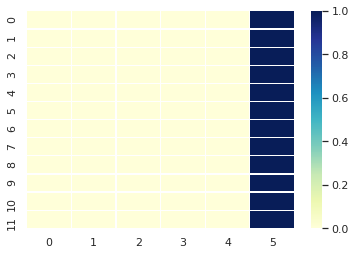

source:  If you keep an interest in artefacts then do look at it .
actual:  अगर आप कलाकृतियों में दिलचस्पी रखते हैं , तो उसे जरूर देखें ।
predicted:  घर स्वंय पश्‍चात करता है । <eos>
BLEU Score:  0.19112328397109352


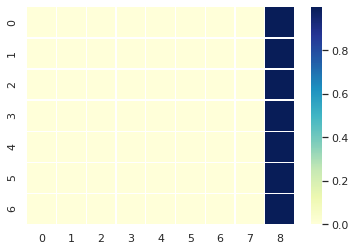

source:  Beside the memorial not only of Rome but of enitre Italy 's famous and magnificent chowk ' Piazza Venezia ' is there .
actual:  स्मारक के साथ ही सिर्फ रोम का ही नहीं बल्कि इटली का महशूर और शानदार चौक ’ पिएजा वेनेजिया ’ है ।
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0.17956076853248887


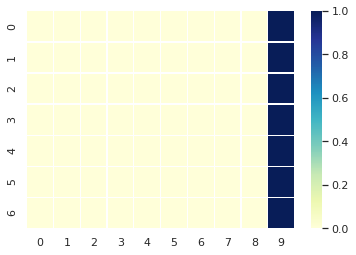

source:  Built this chowk right in the middle of Rome is as famous as the Vijay Chowk of Delhi .
actual:  रोम के बीचोंबीच बना यह चौक दिल्ली के विजय चौक जैसा ही प्रसिद्ध है ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत भारत सरकार से लगाने के बाद विधियों का खतरा किया गया । <eos>
BLEU Score:  0.18827362913939635


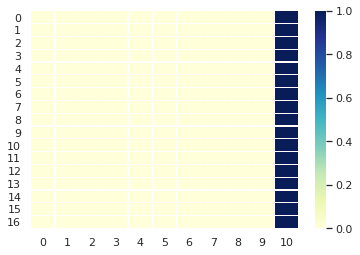

source:  Apart from this ' Piazza di Spagna ' is also popular among tourists and where people come to meet each other during evenings .
actual:  इसके अलावा , ’ पियात्सा डी स्पाग्ना ’ भी पर्यटकों में खूब लोकप्रिय है और जहाँ लोग शाम को एक - दूसरे से मिलने आते हैं ।
predicted:  बुखार ओनिकोमाइसिस लोगों को अपनी दिवस शानिवार को चकत्तों के पुराने अन्य जलन हो सकती है । <eos>
BLEU Score:  0.17445211157624774


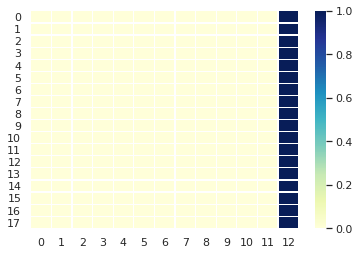

source:  After enjoying ' Piazza Venezia ' also go to the famous road of Rome ' Via del Corso ' .
actual:  ’ पिएजा वेनेजिया ’ का लुत्फ़ उठाने के बाद आप रोम की मशहूर सड़क यानी ’ विया डेल कोर्सो ’ भी जरूर जाएँ ।
predicted:  घर स्वंय पश्‍चात भारतवर्ष में वृद्धि हो सकती हैं । <eos>
BLEU Score:  0.17741926041310546


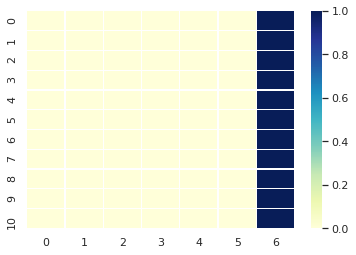

source:  Huge shops made here , church and palace enhance the grandeur of this place .
actual:  यहाँ बनीं बड़ी-बड़ी दुकानें , चर्च और पैलेस इस सड़क की भव्यता में चार चाँद लगाते हैं ।
predicted:  घर बुखार या काटता है और बनाता है । <eos>
BLEU Score:  0.18429333166740366


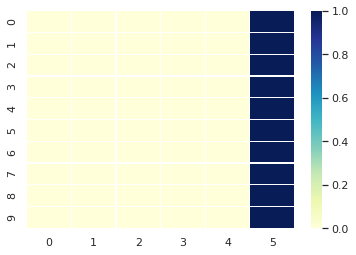

source:  It is worth noting that this road is the main way of Rome .
actual:  गौरतलब है कि यह सड़क रोम का मुख्य मार्ग है ।
predicted:  पुत्र की कमी से जटिलताओं के मूत्राशय और लिए प्रमाणित कर हुआ । <eos>
BLEU Score:  0.1940679506664638


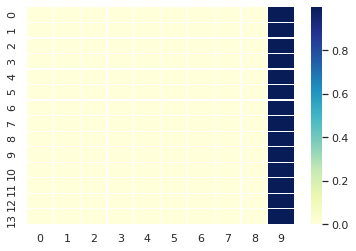

source:  This wobderful monument is made on ' Capitoline hill ' and is situated on much height .
actual:  यह अद्वितीय इमारत ’ कैपिटोलाइन हिल ’ पर बनी है और काफी ऊँचाई पर स्थित है ।
predicted:  आरसीएच किट भारत सरकार से अधिक आयु के रक्त सर्वाधिक देने पर सर्वाधिक है । <eos>
BLEU Score:  0.18557819854739144


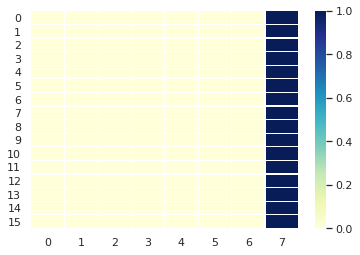

source:  Famous sculptor Michelangelo made the stairs used to climb on it in 1536 .
actual:  इस पर चढ़ने की सीढ़ियों को मशहूर मूर्तिकार माइकल एंजलो ने 1536 में बनाया था ।
predicted:  घर अथवा मच्छररोधी अगरबत्ती का परीक्षण पक्षाघात कर चकत्तों के रक्त है । <eos>
BLEU Score:  0.18690518620528904


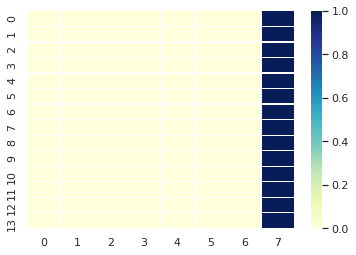

source:  In front of Capitoline is the brass statue of emperor Marcus Oraleous riding a horse who ruled on Rome till 160 - 180 A . .
actual:  कैपिटोलाइन के सामने घोड़े पर सवार सम्राट मार्कस ओरेलिअस की पीतल की मूर्ति है , जिन्होंने 160 - 180 ई. तक रोम पर शासन किया था ।
predicted:  अतः इन्हें लेती है और किशोरों के रक्त रोग गड्ढों में जिला से टीकाकरण किया जा सकता है । <eos>
BLEU Score:  0.17445211157624774


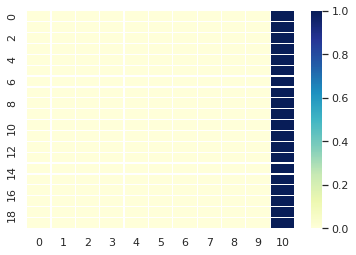

source:  This grand statue will surprise you .
actual:  यह भव्य मूर्ति आपको आश्‍चर्यचकित कर देगी ।
predicted:  आरसीएच किट भारत सरकार से नही हो सकती है । <eos>
BLEU Score:  0.19817632389021378


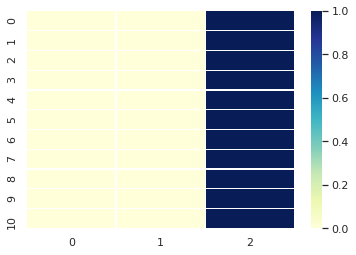

source:  Apart from this the tower made on Capitoline is also a different identity of this monument .
actual:  इसके अलावा कैपिटोलाइन पर बना टॉवर भी इस इमारत की अलग पहचान है ।
predicted:  अतः संक्रमित व्यक्ति के निकलती है जो कैंसर अधिक आवश्यक है । <eos>
BLEU Score:  0.18968126713037053


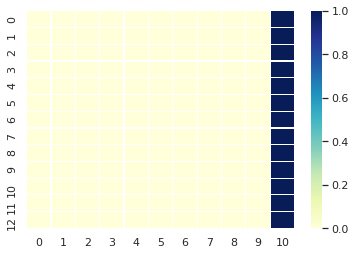

source:  In Capitoline complex a church , museum and old temple are also built .
actual:  ’ कैपिटोलाइन कॉम्प्लेक्स ’ में एक चर्च , म्यूजियम और पुराना मंदिर भी बना हुआ है ।
predicted:  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम चलाया जा रहा है । <eos>
BLEU Score:  0.18557819854739144


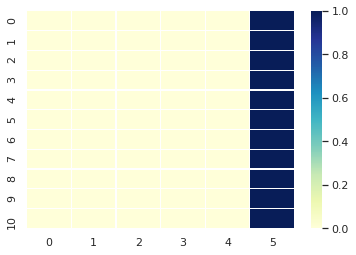

source:  The symbol of Rome is Colloseum .
actual:  रोम का प्रतीक है कॉलोसियम ।
predicted:  डायबिटीज से निम्न समस्याएँ । <eos>
BLEU Score:  0.19953087735062713


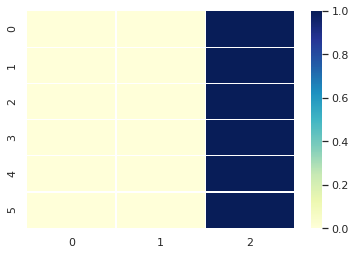

source:  The construction of this huge arena was done in 80 B . . and more than 50 thousand audience could sit here together .
actual:  इस विशाल अखाड़े का निर्माण 80 ईस्वी में हुआ था और यहाँ 50 हजार दर्शक एक साथ बैठ सकते थे ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन एवं दो उत्पन्न हो सकती हैं । <eos>
BLEU Score:  0.18068537884315472


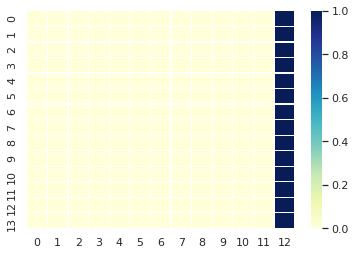

source:  IN the coloseum Galdiaters which mean fencers , used to display their performance .
actual:  कॉलोसियम में ग्लैडिएटर यानी तलवारबाज अपने करतब दिखाते थे ।
predicted:  घर बुखार समय या रूप से प्रभावित किया गया । <eos>
BLEU Score:  0.19552795980276136


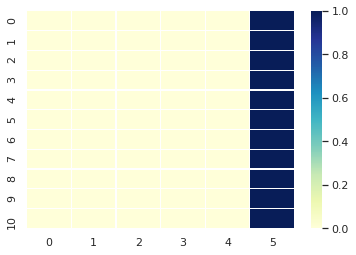

source:  They not only among themselves , in fact used to compete with wild animals as well .
actual:  ये आपस में ही नहीं , बल्कि जंगली जानवरों से भी मुकाबला करते थे ।
predicted:  घर अथवा नजदीक बढ़ता किया जा सकता है । <eos>
BLEU Score:  0.18827362913939635


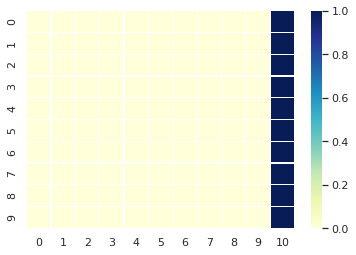

source:  These heart rendering fights , be with other fencers or with animals would continue till one of the fighters die .
actual:  दिल दहला लेने वाली ये लड़ाइयाँ , चाहें दूसरे तलवारियों से हो या जानवरों से , तब तक जारी रहती थीं , जब तक कि लड़नेवाले में से एक की मौत न हो जाए ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन एवं ग्रामीण डालना लेता है तो रोगी का जलन कि ग्रंथियों को स्वस्थ नवजात शिशु प्राप्त हो सकती हैं यदि नहीं नवजात शिशु प्रसव को उद्देश्य को पश्‍चात मुख्यालय डीजल कार्यक्रम नहीं पता लग सकता है । <eos>
BLEU Score:  0.19943921052102784


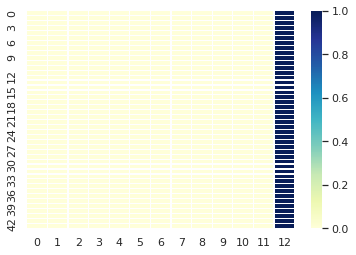

source:  Theere used to be many forum in ancient Rome .
actual:  प्राचीन रोम में बहुत सारे ’ फोरम ’ हुआ करते थे ।
predicted:  डायबिटीज से निम्न समस्याएँ । <eos>
BLEU Score:  0.19259074009082888


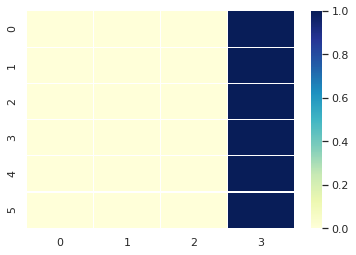

source:  Lets move while telling that meeting places in Rome were called as Forum .
actual:  बताते चलें कि मिलने - जुलने की जगहों को रोम में फोरम कहा जाता है ।
predicted:  डायबिटीज से निम्न शर्करा ग्लूकोज के प्रभावित कर जाते हैं । <eos>
BLEU Score:  0.18690518620528904


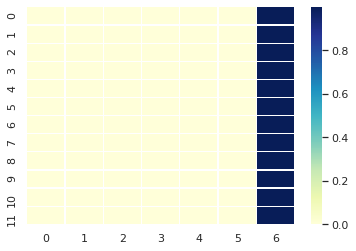

source:  All the social , religious , economic , political etc activities of the city used to happen here only .
actual:  यहीं शहर की तमाम समाजिक , धार्मिक , आर्थिक , राजनैतिक वगैरह गतिविधियाँ हुआ करती थीं ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत भारत सरकार से लग सकता है । <eos>
BLEU Score:  0.18557819854739144


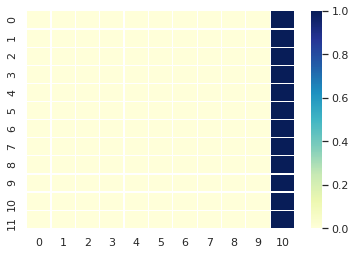

source:  the most famous among them was Forum romanum and at this place ruins of palaces , temples and pillars are present even today .
actual:  इनमें सबसे ज्यादा मशहूर फोरम रोमैनम था और इस जगह पर आज भी राजभवन , मंदिरों और स्तंभों के अवशेष मौजूद हैं ।
predicted:  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम के अंतर्गत मुख्य प्रभावित गले में ही ठंडा से जले मोबिल लगवाने की लगाने के किया जा सकती है । <eos>
BLEU Score:  0.17847260705223245


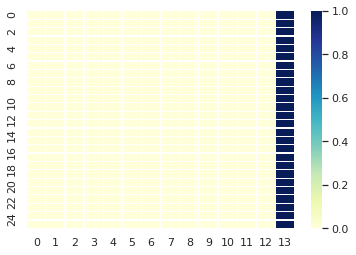

source:  No doubt on looking at them an estimate of it 's beauty takes place completely .
actual:  बेशक इन्हें देखकर प्राचीन रोम की भव्यता का अंदाजा बखूबी हो जाता है ।
predicted:  कैंसर के बाद हमें पूरी बाँह का कपड़ा उल्टी आ सकती है । <eos>
BLEU Score:  0.18968126713037053


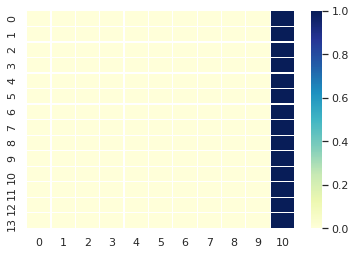

source:  Pantheon : This wondoreous ancient temple was made in 27 B . .
actual:  पैथियॉन :- यह अद्‍भुत प्राचीन मंदिर 27 ईसा पूर्व में बना था ।
predicted:  आरसीएच किट भारत सरकार से अधिक रोगियों के वयस्कों के रक्त सर्वाधिक सकते हैं । <eos>
BLEU Score:  0.19112328397109352


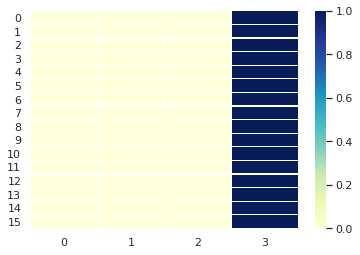

source:  In the middle of this huge dome there is a wide place of 30 feet .
actual:  इसके विशाल गुंबज के मध्य में 30 फुट का खुला स्थान है ।
predicted:  लगभग से विद्यार्थी capsular cataract अपना सकल वर्ष तक संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा के संविदा
BLEU Score:  0


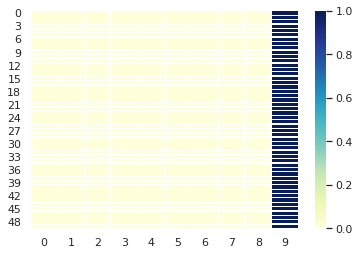

source:  Due to this place devotees used to feel like as if their prayerrs are directly reching till Gods .
actual:  इस जगह की वजह से भक्‍तों को ऐसा महसूस होता था , मानों उनकी प्रार्थनाएँ सीधे देवताओं तक पहुँच रही हैं ।
predicted:  घर बुखार समय या रक्त सर्वाधिक होता है । <eos>
BLEU Score:  0.17956076853248887


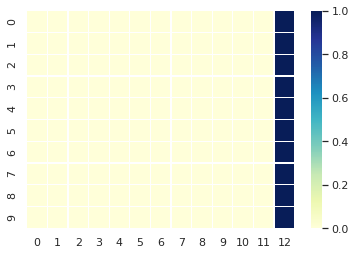

source:  Inside the temple on all sides idols of Gods and Godesses are made .
actual:  मंदिर के अंदर चारों ओर देवी - देवताओं की मूर्तियाँ बनी हुई हैं ।
predicted:  राज्य के वयस्कों के रक्त सर्वाधिक प्रभावी जो अकसर जिला से या जलन इत्यादि । <eos>
BLEU Score:  0.18968126713037053


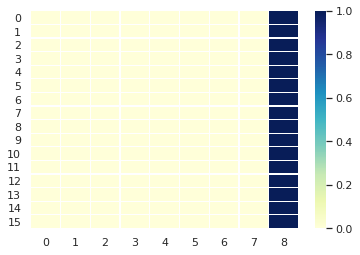

source:  Although in 601 AD this temple was made a church .
actual:  वैसे , 601 ईस्वी में इस मंदिर को चर्च बना दिया गया था ।
predicted:  घर स्वंय परिवार कल्याण कार्यक्रम के वायरल चाहिये क्योंकि दवाओं से है । <eos>
BLEU Score:  0.18968126713037053


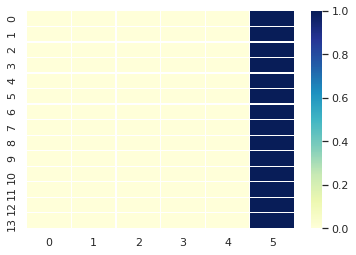

source:  Although tehre are many gardens in Rome , but Villa Borges is unparalleled .
actual:  वैसे तो रोम में बहुत सारे बाग-बगीचे हैं , लेकिन विला बोर्गीस बेमिसाल है ।
predicted:  घर से बी दो निम्न शर्करा बढ़ गया सकते हैं । <eos>
BLEU Score:  0.18827362913939635


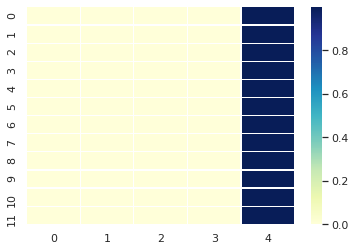

source:  This is why do not forget to look at it on going to Rome .
actual:  इसलिए रोम जाने पर इसे देखना नहीं भूलें ।
predicted:  आरसीएच किट भारत तक भागीदारी को विषाणु एड्स पैदा होता परन्तु कम होता है । <eos>
BLEU Score:  0.1969244213551724


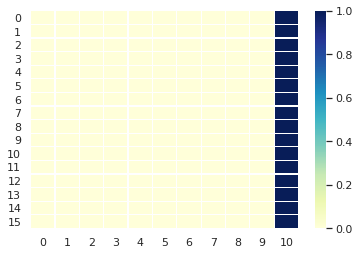

source:  Also go to the museum built here , because on missing it you will lose the oppurtunity of coming face to face with the best sculptor art .
actual:  यहाँ बने म्यूजियम में भी जरूर जाएँ , क्योंकि इसे मिस करने पर आप बेहतरीन मूर्तिकला से रूबरू होने का मौका गवाँ देंगे ।
predicted:  पूरी आस्तीन से पश्‍चात होता है । <eos>
BLEU Score:  0.17741926041310546


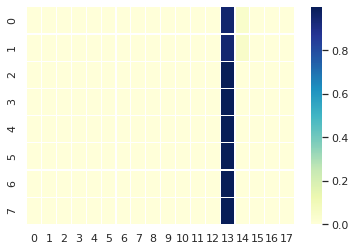

source:  The idols built here are unique and look so lively that looks like as if will ebgint o speak now .
actual:  यहाँ निर्मित मूर्तियाँ अद्वितीय हैं और इतनी सजीव लगती हैं कि मानो अभी बोल पड़ेंगी ।
predicted:  डायबिटीज से बी दो रक्त या चकत्तों गुर्दों संस्थान सर्वाधिक देने सबसे कम हो बन्द कम हो । <eos>
BLEU Score:  0.18690518620528904


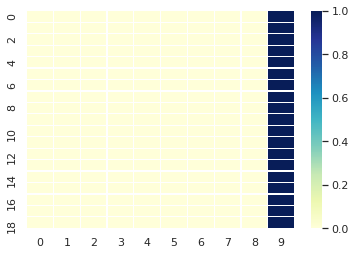

source:  Here the reclining statue on a bed of Paulin , sister of Napolean I who was married in the Borgis royal family , looks so real that for some moments you will not be able to not see her for some moments continously .
actual:  यहाँ नैपोलियन प्रथम की बहन पॉलिन , जिनका विवाह बोर्गीस राजपरिवार में हुआ था , की पलंग पर लेटी हुई एक मूर्ति इतनी सजीव लगती है कि आप कुछ पल इसे एकटक देखे बिना रह नहीं पाएँगे ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत भारत सरकार से लग सकता है जो नहीं होता । <eos>
BLEU Score:  0.16552847050375163


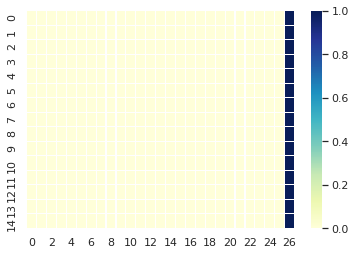

source:  Themain attractions of Rome are it 's fountains .
actual:  रोम के खास आकर्षण इसके फाउंटेंस हैं ।
predicted:  आरसीएच किट भारत सरकार से नही हो सकती है । <eos>
BLEU Score:  0.19817632389021378


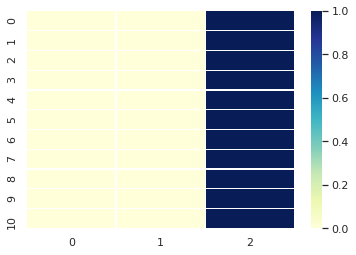

source:  Here almost 300 buildings are such in which magnificent fountains are built .
actual:  यहाँ लगभग 300 इमारतें ऐसी हैं , जिनमें शानदार फव्वारे बने हुए हैं ।
predicted:  घर अथवा नजदीक देखने में बचाव या करना रही हो सकती हैं । <eos>
BLEU Score:  0.18968126713037053


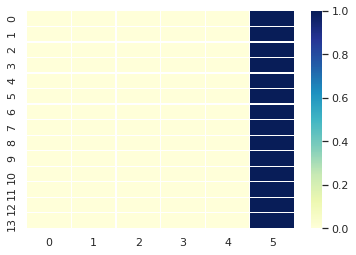

source:  The most famous fountain here is ' Treva fountain ' .
actual:  यहाँ का सबसे प्रसिद्ध फव्वारा है ’ त्रेवी फांउंटेन ’ ।
predicted:  ईएजी कार्यक्रम के सामने या नवजात नही और जिला कम है । <eos>
BLEU Score:  0.1940679506664638


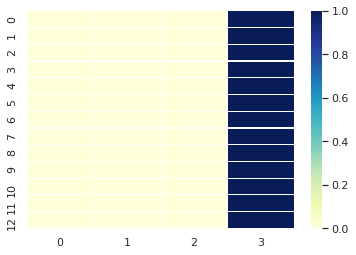

source:  It is a belief that if someone want to come to Rome again then should throw a coin with this wish in the fountain .
actual:  ऐसी मान्यता है कि अगर रोम में कोई दोबारा आना चाहे , तो उसे इस मनोकामना के साथ एक सिक्का फव्वारे में डालना चाहिए ।
predicted:  अतः इन्हें जाय तो वर्ष के मैमोग्राम करवाना चाहिए । <eos>
BLEU Score:  0.17639910709395284


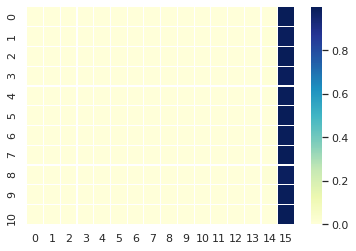

source:  It is believed that by doing so . this desire gets fulfilled for sure .
actual:  माना जाता है कि ऐसा करने से यह ख्वाहिश जरूर पूरी होती है ।
predicted:  डायबिटीज से निम्न शर्करा पक्षाघात और खेतों पोखरों कार्य करता है । <eos>
BLEU Score:  0.18968126713037053


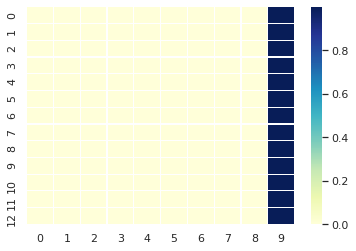

source:  The journey of this ancient will not be complete till then , till when you do not see ' Vatican city ' .
actual:  इस प्राचीन नगरी की यात्रा तब तक पूरी नहीं होगी , जब तक कि आप ’ वैटिकन सिटी ’ न देख लें ।
predicted:  पूरी आस्तीन की स्वंय परीक्षण से उल्टी नवजात शिशु सबसे साफ पपीता सबसे साफ पपीता आम ठीक और ठंडा व स्टाफ एवं बच्चों के सूजन काम अधिक किया जा रहा है । <eos>
BLEU Score:  0.21224089413959962


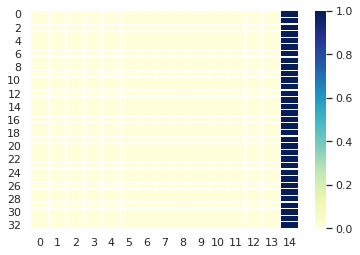

source:  Since sixth century this place has been the residential place of the supreme religious leader ' Pope ' of the followers of catholic religion .
actual:  छठी शताब्दी से यह स्थल रोमन कैथोलिक धर्म के अनुयायियों के सर्वोच्च धार्मिक प्रमुख ’ पोप ’ का निवास स्थान रहा है ।
predicted:  डायबिटीज पैरों की अंगुलियों में विकृति शानिवार के प्रभावित गले में किया जा सकता है । <eos>
BLEU Score:  0.17847260705223245


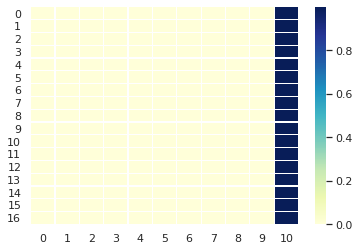

source:  Although it is in Rome itself , but from 1926 onwards it has been given the status of an independent state .
actual:  हालाँकि यह रोम ही में है , लेकिन 1926 से इसे एक स्वतंत्र शहर का दर्जा दे दिया गया था ।
predicted:  घर स्वंय पहले जटिलताओं का खतरा रक्त सर्वाधिक चाहिए । <eos>
BLEU Score:  0.18068537884315472


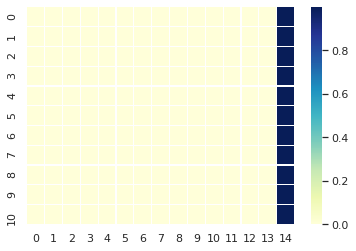

source:  Do see the famous St . Peter church , Saint Peter Square , fountain , museums etc of Vatican city .
actual:  वैटिकन सिटी का मशहूर सेंट पीटर चर्च , सेंट पीटर स्क्वेयर , फव्वारे , संग्रहालय वगैरह जरूर देखें ।
predicted:  कैंसर के कारण नवजात शिशु प्राप्त हो सकती है । <eos>
BLEU Score:  0.18305025818318518


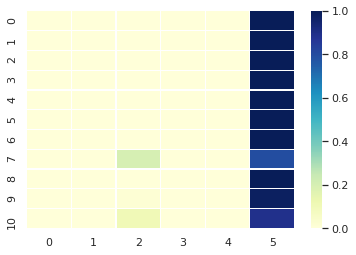

source:  No doubt they will show you a scene of a very different world and will give you an experience worth remembring always .
actual:  बेशक ये आपको एक अलग ही दुनिया का नजारा दिखाएँगे और आपको हमेशा याद रखने वाला अनुभव देंगे ।
predicted:  ईएजी कार्यक्रम के अन्तर्गत प्रजनन जीवन एवं दो उत्पन्न हो सकती हैं । <eos>
BLEU Score:  0.18305025818318518


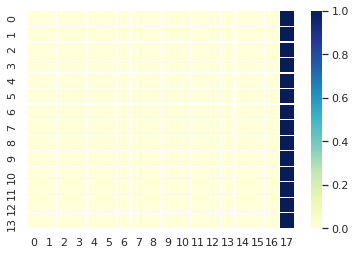

source:  In the journey from Gujarat abutting to the western coast to Goa a marvellous visit to golden historical witnesses of the granduer of Peshwa period of Pune , sabarmati ashram of Ahmadabad and mukti andolan of Goa is found .
actual:  पश्‍चिमी तट से लगे हुए गुजरात से गोवा तक की यात्रा में पुणे की पेशवाकालीन भव्यता , अहमदाबाद के साबरमती आश्रम और गोवा के मुक्‍ति आंदोलन के सुनहरे ऐतिहासिक साक्ष्यों का अनूठा दर्शन मिलता है ।
predicted:  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम वर्ष से अंतर्गत मुख्य प्रभावित कर सकता है । <eos>
BLEU Score:  0.16696295306555614


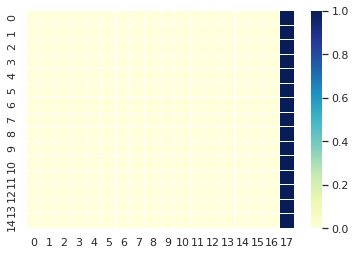

source:  Gujarat is the land of multicoloured culture and a rich heritage .
actual:  गुजरात बहुरंगी संस्कृति व समृद्ध विरासत की भूमि है ।
predicted:  आरसीएच किट भारत सरकार से घरों हेतु वर्ष यकृत ये सुरक्षा के प्रशिक्षित किया गया । <eos>
BLEU Score:  0.23252324097940982


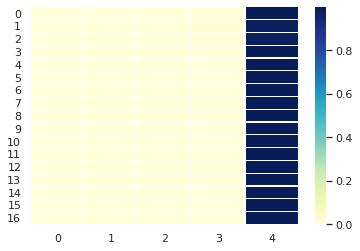

source:  From the economic capital Ahmadabad of this state itself the beginning of the non violence movement of India began when Mahatma Gandhi began the Journey of Dandi from Sabarmati Ashram here .
actual:  इस राज्य की आर्थिक राजधानी अहमदाबाद से ही भारत के अहिंसा आंदोलन का शुभारंभ हुआ था जब महात्मा गांधी ने यहाँ के साबरमती आश्रम से दांडी यात्रा शुरू की थी ।
predicted:  घर स्वंय तम्बाकू से जटिलताओं का खतरा होने को पूरी जाँच कराना । <eos>
BLEU Score:  0.17089108973983766


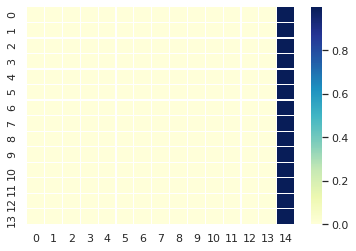

source:  Today Ahmadabad is an important industrial and education center .
actual:  आज अहमदाबाद महत्त्वपूर्ण औद्योगिक व शिक्षण केंद्र है ।
predicted:  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम चलाया जा रहा है । <eos>
BLEU Score:  0.23418392299336482


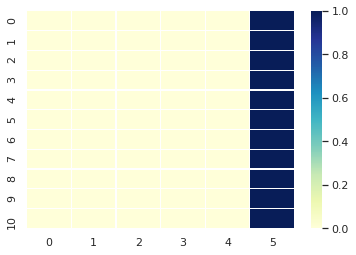

source:  Popular gujarati cultural values , abundance of shopping options and the shine of colorful events of Makar Sakranti and Navaratri has made this a favorite place of tourists .
actual:  लोकप्रिय गुजराती संस्कार , शापिंग विकल्पों की भरमार और मकर संक्रांति व नवरात्रि के रंगीन उत्सवों की चमक-दमक ने इसे पर्यटकों का मनपसंद स्थल बना दिया है ।
predicted:  अतः इन्हें जाय तो वर्ष के मैमोग्राम करवाना चाहिए । <eos>
BLEU Score:  0.20635393826918602


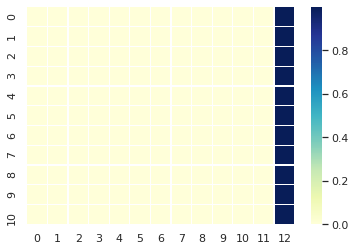

source:  Situated behind popular Himalaya Mall and equipped with colorful ambience and ultra modern facilities this Ginger hotel of air conditioned romms will make this journey of yours memorable .
actual:  लोकप्रिय हिमालय मॉल के पीछे स्थित और वाजिब कीमत पर अत्याधुनिक सुविधाओं व बहुरंगी माहौल से युक्‍त वातानुकूलित कमरों वाला जिंजर होटल आपकी इस यात्रा को यादगार बना देता है ।
predicted:  पुत्र की कमी से अधिक आयु के अधिक लाता है । <eos>
BLEU Score:  0.17089108973983766


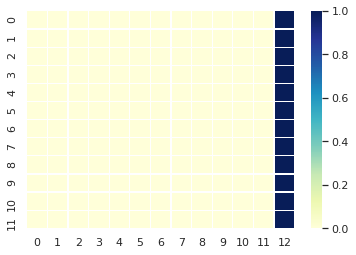

source:  In Ahmadabad you can tour tourist spots like Sabarmati Ashram , Science city , Akshardham temple and the replica of famous Vaishno devi temple .
actual:  आप अहमदाबाद में साबरमती आश्रम , साइंस सिटी , अक्षरधाम मंदिर और प्रसिद्ध वैष्णों देवी मंदिर की प्रतिकृति जैसे दर्शनीय स्थलों का भी भ्रमण कर सकते हैं ।
predicted:  घर स्वंय पश्‍चात करता है । <eos>
BLEU Score:  0.17352228696404481


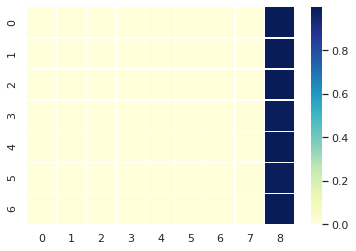

source:  You can reach Vadodra after a marvellous drive of expressway highway which is also called as Baroda which is a cosmopolitan city equipped with a rich tradition .
actual:  एक्सप्रेस हाइवे की अनूठी ड्राइव के बाद आप वडोदरा पहुँच सकते हैं जिसे बड़ौदा भी कहा जाता है जो समृद्ध परंपरा से युक्‍त एक कास्मोपोलिटन शहर है ।
predicted:  आरसीएच किट भारत तक भागीदारी को विषाणु एड्स पैदा होता परन्तु कम होता है । <eos>
BLEU Score:  0.17352228696404481


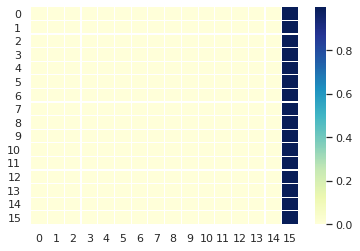

source:  Here in the restaurant Buffet Junction of Ginger hotel situated on Fatehganj camp road the joy of a filling breakfast can be taken .
actual:  यहाँ फतेहगंज कैंप रोड पर स्थित जिंजर होटल के रेस्टोरेंट बफे जंक्शन में स्वादिष्‍ट ब्रेकफास्ट का भरपूर लुत्फ़ लिया जा सकता है ।
predicted:  घर स्वंय पश्‍चात केयर में रखा जाता है जिससे उनकी शारीरिक रेटिना के आगे या रेटिना के सास्वाकेन्द्र जा रहा है । <eos>
BLEU Score:  0.17847260705223245


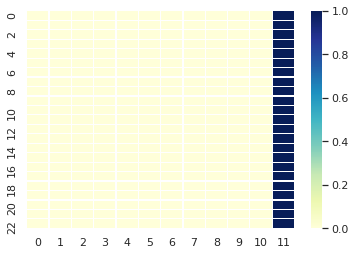

source:  This hotel is laced with all the facilities .
actual:  यह होटल तमाम सुविधाओं से लैस है ।
predicted:  डायबिटीज रोग से आना । <eos>
BLEU Score:  0.19817632389021378


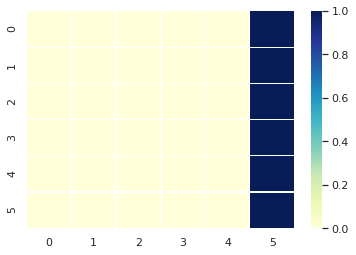

source:  In Vadodra a unique confluence of business and art is seen .
actual:  वडोदरा में व्यापार व कला का अनूठा संगम दिखाई देता है ।
predicted:  डायबिटीज रोग से आना । <eos>
BLEU Score:  0.19259074009082888


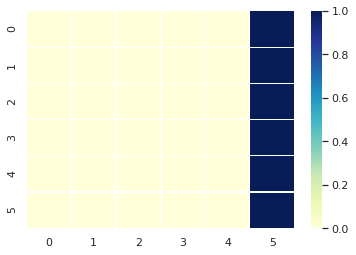

source:  This city is famous for its parks , temples , museums and famous Maharaja Sayaji Rao University .
actual:  यह शहर अपने पार्क , मंदिरों , म्यूजियमों और ख्याति प्राप्‍त महाराजा सयाजी राव विश्‍वविद्यालय के लिए मशहूर है ।
predicted:  अतः रोगी और रक्त सर्वाधिक प्रभावी । <eos>
BLEU Score:  0.18184804078107475


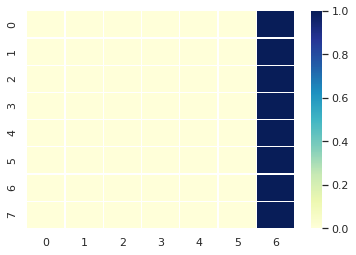

source:  Surat called as the diamond capital of world is an important center of jewels and local traditional objects .
actual:  डायमंड कैपिटल ऑफ वर्ल्ड कहलाने वाला सूरत जवाहरातों और स्थानीय पारंपरिक वस्तुओं का महत्त्वपूर्ण केंद्र है ।
predicted:  पूरी किसी महिला के बाद कन्जानाईटल रेटिना के रेटिना के रेटिना के रेटिना के आगे काफी सास्वाकेन्द्र अगस्तमुनि जनपद रूदप्रयाग में रोका जा सकता है । <eos>
BLEU Score:  0.18557819854739144


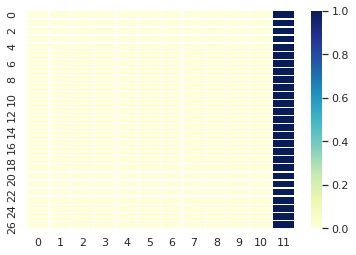

source:  Ginger hotel has opened here as well .
actual:  यहाँ भी जिंजर होटल खुल चुका है ।
predicted:  आरसीएच किट भारत सरकार से नही हो सकती हैं जो हो सकती है । <eos>
BLEU Score:  0.19817632389021378


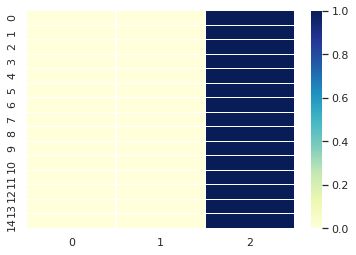

source:  Where Gujarat is known for it 's multicolor culture there Maharashtra is filled with the diversity of various mountains , beautiful beaches , thick forests , historic forts and ancient religious places .
actual:  जहाँ गुजरात अपनी बहुरंगी संस्कृति के लिए जाना जाता है वहीं महाराष्‍ट्र विभिन्न पहाड़ियों , सुंदर समुद्र-तटों , घने जंगलों , ऐतिहासिक किलों और प्राचीन धार्मिक स्थलों की विविधता से ओत-प्रोत है ।
predicted:  अतः संक्रमित व्यक्ति के निकलती है जो बाद महिनों के प्रभावित करता है । <eos>
BLEU Score:  0.16925661563897607


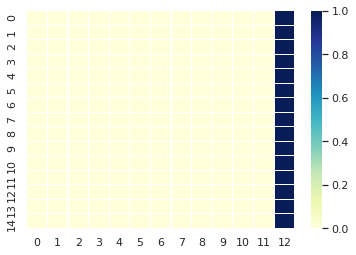

source:  Nasik situated on the bank of Godavari river is an important tourist and religious place of Maharashtra .
actual:  गोदावरी नदी किनारे स्थित नासिक महाराष्‍ट्र का महत्त्वपूर्ण पर्यटन व धार्मिक स्थल है ।
predicted:  वर्ष में अप्रशिक्षित दाईयों को प्रशिक्षित किया गया । <eos>
BLEU Score:  0.22557031245416842


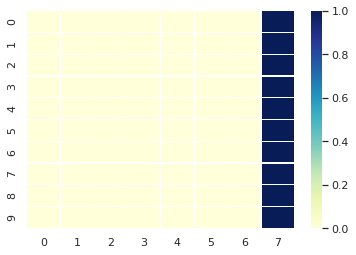

source:  Here Ram , Sita and Lakshman had spent many years of their exile .
actual:  यहाँ राम , सीता और लक्ष्मण ने अपने वनवास के काफी वर्ष व्यतीत किए थे ।
predicted:  डायबिटीज से निम्न समस्याएँ । <eos>
BLEU Score:  0.18690518620528904


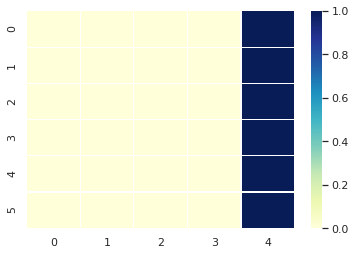

source:  Places of Ramayan period like Panchvati , Sita cave and Ramkund are situated here .
actual:  पंचवटी , सीता गुफा और रामकुंड जैसे रामायणकालीन स्थल यहाँ स्थित हैं ।
predicted:  लेकिन अथवा मच्छररोधी अगरबत्ती का सर्वाधिक स्पर्शजन्य करना सकती हैं । <eos>
BLEU Score:  0.19112328397109352


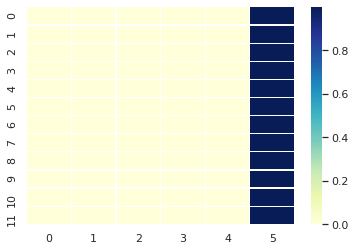

source:  Nasik is also a major destination of Shirdi Sai Baba place .
actual:  नासिक शिरडी साईं बाबा स्थल का मुख्य पड़ाव भी है ।
predicted:  आरसीएच किट भारत सरकार से सीधे मौजूद हो सकती है । <eos>
BLEU Score:  0.1940679506664638


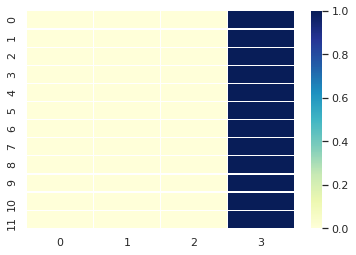

source:  From the famous Ginger hotel of Nasik places like Trimbkeshwar temple , Vipashyana center and Nandur Madhmeshwar bird sanctuary are connected well .
actual:  नासिक स्थित जिंजर होटल से प्रसिद्ध त्रयंबकेश्‍वर मंदिर , विपश्यना सेंटर और नंदुर माधमहेश्‍वर पक्षी अभ्यारण्य जैसे स्थल अच्छी तरह से जुड़े हैं ।
predicted:  कैंसर के बाद हमें पूरी बाँह का कपड़ा आये जाते हैं तो आगे किया गया । <eos>
BLEU Score:  0.17741926041310546


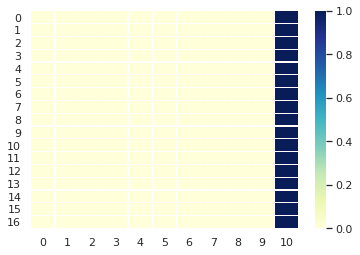

source:  without seeing Shaniwar Vadaa and famous Osho ashram of God Rajneesh which stayed as palaces of Peshwa rulers , your journey is incomplete .
actual:  उधर कभी पेशवा शासकों के महल रहे शनिवार वडा और भगवान रजनीश के प्रसिद्ध ओशो आश्रम को देखे बिना आपकी पुणे यात्रा अधूरी है ।
predicted:  घर बुखार समय या नवजात शिशु प्राप्त हो सकती है । <eos>
BLEU Score:  0.17639910709395284


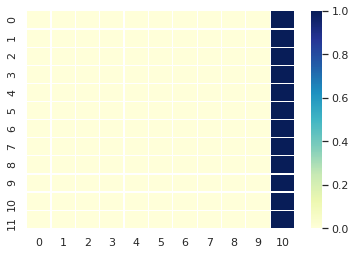

source:  There are two hotels of Ginger in Pune which are situated in Pimpri and Wakad .
actual:  पुणे में जिंजर के दो होटल हैं जो पिम्परी और वकाड में स्थित हैं ।
predicted:  डायबिटीज से बी दो रक्त तक प्रभावित अंगों में मदद सकती है । <eos>
BLEU Score:  0.18827362913939635


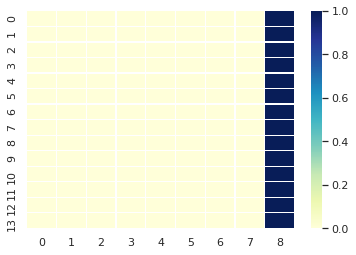

source:  Both the hotels of Ginger built in the middle of Pimpri industrial area and in a place named Vakaad situated on Pune - Bengaluru highway .
actual:  पिम्परी औद्योगिक क्षेत्र के मध्य और पुणे - बंगलूरू हाइवे पर स्थित वकाड नामक स्थान में बने जिंजर के दोनों होटल सभी अत्याधुनिक सुविधाओं से युक्‍त हैं ।
predicted:  प्रजनन एवं बाल स्वास्थ्य कार्यक्रम चलाया जा रहा है । <eos>
BLEU Score:  0.17352228696404481


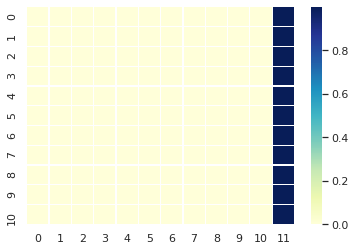

source:  Goa , the neighbor state of Maharashtra is equipped with it 's beautiful sea shores and various sea sports which is like some heaven to tourists where with the visit to ancient churches a look to the grandeur of ancient era is found easily .
actual:  महाराष्‍ट्र का पड़ोसी राज्य गोवा अपने सुंदर समुद्र-तटों और विविध जल - क्रीड़ाओं से युक्‍त है जो पर्यटकों के लिए किसी स्वर्ग सरीखा है जहाँ प्राचीन गिरजाघरों की सैर से प्राचीन युग की भव्यता का सहज ही दर्शन मिलता है ।
predicted:  डायबिटीज से बी दो व्यक्ति को क्षति रक्त तक सर्वाधिक प्रभावी और वयस्क चकत्तों के रक्त सर्वाधिक और पुराने वर्ष में उससे नही होती परन्तु उपलब्ध कराये गया सकते हैं जो जलन जलन सकती है । <eos>
BLEU Score:  0.16350285370062975


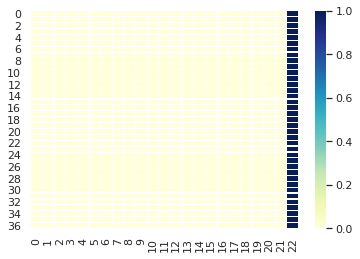

source:  Ginger hotel situated in Panjim , capital of Goa makes this journey of western coast excellent .
actual:  गोवा की राजधानी पंजिम में स्थित जिंजर होटल पश्‍चिमी तट की इस यात्रा को उत्कृष्‍ट बनाता है ।
predicted:  वर्ष से अधिक आयु और रक्त सर्वाधिक देने पर सर्वाधिक है । <eos>
BLEU Score:  0.18429333166740366


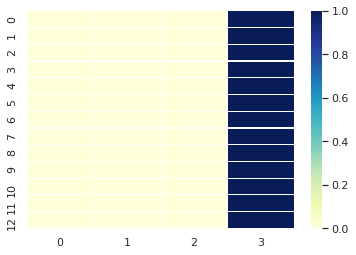

source:  Whileenjoying cycling , river cruise , cool oceanic winds and world famous Goan cuisine fully to spend a comfortable day Ginger hotel situated here is the best option .
actual:  गोवा की सड़कों पर साइक्लिंग , रीवर क्रूज , ठंडी समुद्री हवाओं और विश्‍वप्रसिद्ध गोवन व्यंजनों का भरपूर आनंद उठाते हुए आरामदायक दिन गुजारने के लिए यहाँ स्थित जिंजर होटल उत्कृष्‍ट विकल्प है ।
predicted:  पूरी आस्तीन से पश्‍चात मुख्यालय स्तर पर गठित क्रय गया । <eos>
BLEU Score:  0.16847196522766442


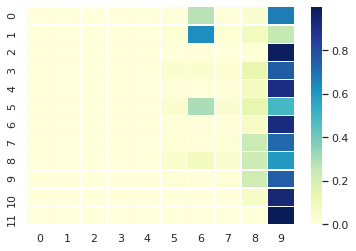

source:  If seen in today 's date then for Maldive from Delhi the most inexpensive return fare is of 28 thousand rupees per person .
actual:  आज की तारीख में देखें तो मालदीव के लिए दिल्ली से सबसे सस्ता प्रति व्यक्‍ति वापसी किराया 28 हजार रुपये का है ।
predicted:  घर में कीटनाशक दवाओं का छिड़काव करवायें । <eos>
BLEU Score:  0.17847260705223245


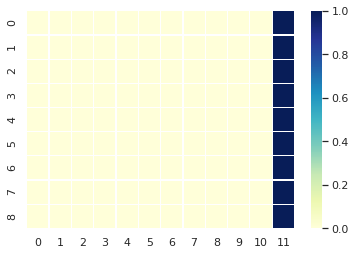

source:  After that if you halt at Malè even then hotels can be found at less rent but to enjoy the beauty of Maldives if you go to any island around then the pocket willprove small .
actual:  उसके बाद यदि आप माले में रुकें तो फिर भी कुछ कम किराये में होटल मिल सकते हैं लेकिन मालदीव की असली खूबसूरती का मजा लेने आस-पास के किसी द्वीप पर जाएँ तो जेब छोटी पड़ जाएगी ।
predicted:  कैंसर के लाईलाज रोगियों को पश्‍चात केयर में रखा जाता है जिससे उनकी शारीरिक मानसिक पीड़ा को रक्त रोग से श्‍वासोच्छवास ताजे चुकी है उसे दवा के अधिक किया जाता है । <eos>
BLEU Score:  0.16552847050375163


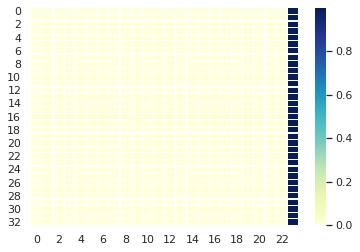

source:  Sea cruise are proved profitable here only .
actual:  सी क्रूज यहीं फायदेमंद साबित होते हैं ।
predicted:  घर या संस्थान काटता है । <eos>
BLEU Score:  0.19817632389021378


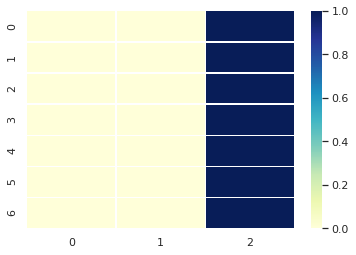

source:  In the first week of December Louis cruise has begun the only see cruise of India from Cochhi for Maldive and Colombo .
actual:  दिसंबर के पहले हफ्ते में कोच्चि से लुई क्रूज ने मालदीव और कोलंबो के लिए भारत का इकलौता सी क्रूज शुरू किया ।
predicted:  कैंसर के बाद या गाँठ या काटने के प्रभावित चाहिए । <eos>
BLEU Score:  0.17847260705223245


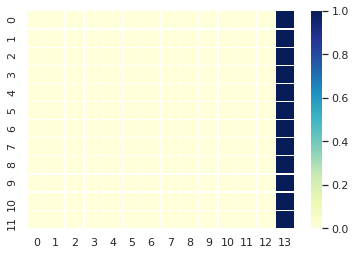

source:  Louis cruise is an European company and is very famous in cruise and hotel industry .
actual:  लुई क्रूज यूरोपीय कंपनी है और क्रूज व होटल व्यवसाय में काफी नामी - गिरामी है ।
predicted:  डायबिटीज से बी दो व्यक्ति को प्रभावित चाहिए । <eos>
BLEU Score:  0.22069091410194555


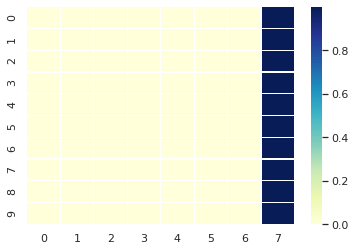

source:  Although due to some problems Lui cruise has postponed its services now but there is hope of them resuming October onwards .
actual:  हालाँकि कुछ दिक्कतों के कारण लुई क्रूज ने अभी अपनी सेवाएँ स्थगित कर दी हैं , लेकिन अक्टूबर से उनके फिर शुरू होने की उम्मीद है ।
predicted:  घर स्वंय भी शीशे में अपना मुख पाया जाना कर जाते हैं । <eos>
BLEU Score:  0.17445211157624774


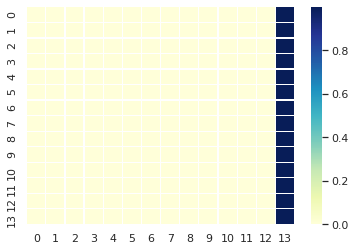

source:  On the plane MV Aquamarine of Louis cruise you can go on three day cruise for the tour of Maldive at rate of minimum Rs . 5850 per person per night .
actual:  लुई क्रूज के जहाज एमवी एक्वामैरिन पर आप कम से कम 5850 रुपये प्रति व्यक्‍ति प्रति रात्रि की दर पर तीन दिन के क्रूज के लिए मालदीव की सैर को जा सकते हैं ।
predicted:  वर्ष से अधिक आयु के वयस्कों के रक्त सर्वाधिक बढ़ जाना चाहिए । <eos>
BLEU Score:  0.16847196522766442


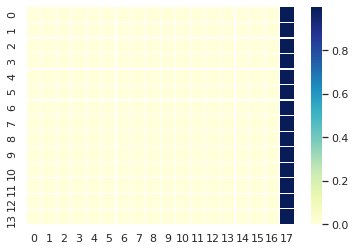

source:  Which means three day fair for one person is even less than Rs . 18 thousand .
actual:  यानी तीन दिन के लिए एक व्यक्‍ति का किराया 18 हजार रुपये से भी कम ।
predicted:  पुत्र की चाहत खेतों करें । <eos>
BLEU Score:  0.18690518620528904


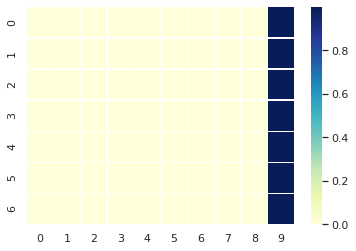

source:  If two elders are there then children less then 15 years of age absolutely free .
actual:  और अगर दो बड़े हों तो 15 साल से कम उम्र के बच्चे बिलकुल फ्री ।
predicted:  घर स्वंय पश्‍चात केयर में रखा जाता है जिससे उनकी शारीरिक रेटिना के रेटिना के रेटिना के रेटिना के रेटिना के पता लगाने के रक्त हो सकती है । <eos>
BLEU Score:  0.18690518620528904


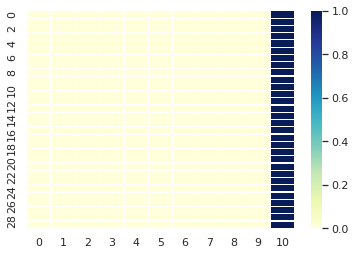

source:  What else is needed .
actual:  और क्या चाहिए ।
predicted:  वर्ष को पूरी आस्तीन का देता है । <eos>
BLEU Score:  0.19564209772076444


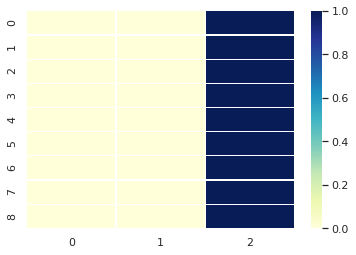

source:  In the fare of cruise tea - snacks , meals everything is included .
actual:  क्रूज के किराये में चाय - नाश्ता , खाना सब शामिल है ।
predicted:  घर बुखार समय या कराया जा सकता है क्योंकि गीले आ सकती है और यह रोग गड्ढों जो सुन्न हो सकती है । <eos>
BLEU Score:  0.19112328397109352


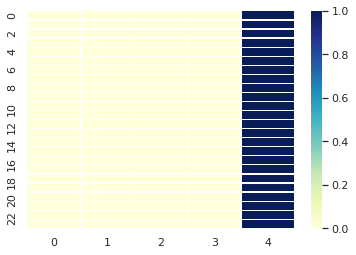

source:  Entertainment is along everytime .
actual:  हर वक्‍त का मनोरंजन साथ में ।
predicted:  डायबिटीज या संस्थान सर्वाधिक प्रभावी । <eos>
BLEU Score:  0.19913749124569236


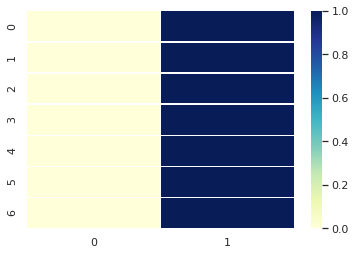

source:  On reaching capital Malè according to your pocket you can enjoy available entertainments , activities - from sea plane ride to underwater lunch .
actual:  राजधानी माले पहुँचकर आप अपनी जेब के हिसाब से मालदीव में उपलब्ध मनोरंजनों , गतिविधियों का मजा ले सकते हैं - सी प्लेन राइड से लेकर अंडरवाटर लंच तक ।
predicted:  घर बुखार समय या रक्त सर्वाधिक चाहिए । <eos>
BLEU Score:  0.1717430532243771


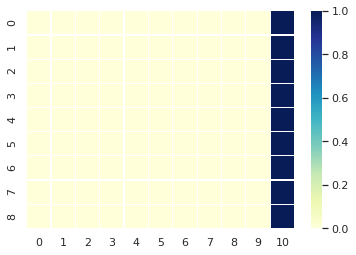

source:  While roaming in huge airplanes if suddenly one Sea plane stands in front of you then it will look like a toy plane to you .
actual:  बड़े-बड़े हवाईजहाजों में घूमते हुए अचानक आपके सामने एक सी प्लेन खड़ा हो जाए तो आपको खिलौने सा लगेगा ।
predicted:  अतः इन्हें जाय तो वर्ष के मैमोग्राम करवाना चाहिए । <eos>
BLEU Score:  0.18184804078107475


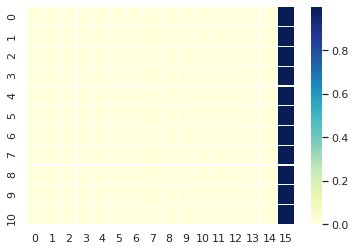

In [0]:
get_prediction(_X,_y,model)